In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.IsoPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.106027,0.212053
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.893973,-0.212053


In [12]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    if (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
    stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
    print(f"[Local] Grouping box score rows by GameID...")
    groups = stored_game_boxes.groupby('GameID')
    print(f"[Local] Generated {len(groups)} box score groups by GameID.")
    current = 0
    for (name, group) in groups:
        print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
        group_ratings = group['5FR']
        top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
        bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
        group['5FRDiff'] = [top_diff, bot_diff]
        print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
        current+=1
    print(f"[Local] Finished updating box scores with new 5FR margins.")

print(f"[Local] Writing updated box scores to file...")
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
print(f"[Local] Wrote updated box scores to file.")

[Local] Box Scores are not available, generating them from scratch...
[1/6644] Getting game information for ESPN game_id: 322432309...
[1/6644] Started processing game information for ESPN game_id: 322432309...
[1/6644] Skipping checking game_id 322432309 bc one of the teams isn't FBS.
[2/6644] Getting game information for ESPN game_id: 322432006...
[2/6644] Started processing game information for ESPN game_id: 322432006...
[2/6644] Completed processing game information for ESPN game_id: 322432006.
[2/6644] Aggreggated game_id 322432006 to master data copy.
[3/6644] Getting game information for ESPN game_id: 322430238...
[3/6644] Started processing game information for ESPN game_id: 322430238...
[3/6644] Completed processing game information for ESPN game_id: 322430238.
[3/6644] Aggreggated game_id 322430238 to master data copy.
[4/6644] Getting game information for ESPN game_id: 322432117...
[4/6644] Started processing game information for ESPN game_id: 322432117...
[4/6644] Skipping 

[36/6644] Completed processing game information for ESPN game_id: 322450103.
[36/6644] Aggreggated game_id 322450103 to master data copy.
[37/6644] Getting game information for ESPN game_id: 322450275...
[37/6644] Started processing game information for ESPN game_id: 322450275...
[37/6644] Skipping checking game_id 322450275 bc one of the teams isn't FBS.
[38/6644] Getting game information for ESPN game_id: 322452509...
[38/6644] Started processing game information for ESPN game_id: 322452509...
[38/6644] Skipping checking game_id 322452509 bc one of the teams isn't FBS.
[39/6644] Getting game information for ESPN game_id: 322450158...
[39/6644] Started processing game information for ESPN game_id: 322450158...
[39/6644] Completed processing game information for ESPN game_id: 322450158.
[39/6644] Aggreggated game_id 322450158 to master data copy.
[40/6644] Getting game information for ESPN game_id: 322450066...
[40/6644] Started processing game information for ESPN game_id: 322450066..

[70/6644] Completed processing game information for ESPN game_id: 322452483.
[70/6644] Aggreggated game_id 322452483 to master data copy.
[71/6644] Getting game information for ESPN game_id: 322452638...
[71/6644] Started processing game information for ESPN game_id: 322452638...
[71/6644] Completed processing game information for ESPN game_id: 322452638.
[71/6644] Aggreggated game_id 322452638 to master data copy.
[72/6644] Getting game information for ESPN game_id: 322450264...
[72/6644] Started processing game information for ESPN game_id: 322450264...
[72/6644] Completed processing game information for ESPN game_id: 322450264.
[72/6644] Aggreggated game_id 322450264 to master data copy.
[73/6644] Getting game information for ESPN game_id: 322450012...
[73/6644] Started processing game information for ESPN game_id: 322450012...
[73/6644] Completed processing game information for ESPN game_id: 322450012.
[73/6644] Aggreggated game_id 322450012 to master data copy.
[74/6644] Getting g

[104/6644] Completed processing game information for ESPN game_id: 322522117.
[104/6644] Aggreggated game_id 322522117 to master data copy.
[105/6644] Getting game information for ESPN game_id: 322520113...
[105/6644] Started processing game information for ESPN game_id: 322520113...
[105/6644] Completed processing game information for ESPN game_id: 322520113.
[105/6644] Aggreggated game_id 322520113 to master data copy.
[106/6644] Getting game information for ESPN game_id: 322520130...
[106/6644] Started processing game information for ESPN game_id: 322520130...
[106/6644] Completed processing game information for ESPN game_id: 322520130.
[106/6644] Aggreggated game_id 322520130 to master data copy.
[107/6644] Getting game information for ESPN game_id: 322522305...
[107/6644] Started processing game information for ESPN game_id: 322522305...
[107/6644] Completed processing game information for ESPN game_id: 322522305.
[107/6644] Aggreggated game_id 322522305 to master data copy.
[108/

[136/6644] Completed processing game information for ESPN game_id: 322520021.
[136/6644] Aggreggated game_id 322520021 to master data copy.
[137/6644] Getting game information for ESPN game_id: 322520096...
[137/6644] Started processing game information for ESPN game_id: 322520096...
[137/6644] Completed processing game information for ESPN game_id: 322520096.
[137/6644] Aggreggated game_id 322520096 to master data copy.
[138/6644] Getting game information for ESPN game_id: 322520142...
[138/6644] Started processing game information for ESPN game_id: 322520142...
[138/6644] Completed processing game information for ESPN game_id: 322520142.
[138/6644] Aggreggated game_id 322520142 to master data copy.
[139/6644] Getting game information for ESPN game_id: 322520026...
[139/6644] Started processing game information for ESPN game_id: 322520026...
[139/6644] Completed processing game information for ESPN game_id: 322520026.
[139/6644] Aggreggated game_id 322520026 to master data copy.
[140/

[168/6644] Completed processing game information for ESPN game_id: 322590008.
[168/6644] Aggreggated game_id 322590008 to master data copy.
[169/6644] Getting game information for ESPN game_id: 322590213...
[169/6644] Started processing game information for ESPN game_id: 322590213...
[169/6644] Completed processing game information for ESPN game_id: 322590213.
[169/6644] Aggreggated game_id 322590213 to master data copy.
[170/6644] Getting game information for ESPN game_id: 322592006...
[170/6644] Started processing game information for ESPN game_id: 322592006...
[170/6644] Skipping checking game_id 322592006 bc one of the teams isn't FBS.
[171/6644] Getting game information for ESPN game_id: 322590097...
[171/6644] Started processing game information for ESPN game_id: 322590097...
[171/6644] Completed processing game information for ESPN game_id: 322590097.
[171/6644] Aggreggated game_id 322590097 to master data copy.
[172/6644] Getting game information for ESPN game_id: 322592572...


[201/6644] Completed processing game information for ESPN game_id: 322590024.
[201/6644] Aggreggated game_id 322590024 to master data copy.
[202/6644] Getting game information for ESPN game_id: 322590061...
[202/6644] Started processing game information for ESPN game_id: 322590061...
[202/6644] Completed processing game information for ESPN game_id: 322590061.
[202/6644] Aggreggated game_id 322590061 to master data copy.
[203/6644] Getting game information for ESPN game_id: 322590099...
[203/6644] Started processing game information for ESPN game_id: 322590099...
[203/6644] Skipping checking game_id 322590099 bc one of the teams isn't FBS.
[204/6644] Getting game information for ESPN game_id: 322590127...
[204/6644] Started processing game information for ESPN game_id: 322590127...
[204/6644] Completed processing game information for ESPN game_id: 322590127.
[204/6644] Aggreggated game_id 322590127 to master data copy.
[205/6644] Getting game information for ESPN game_id: 322590021...


[232/6644] Completed processing game information for ESPN game_id: 322662711.
[232/6644] Aggreggated game_id 322662711 to master data copy.
[233/6644] Getting game information for ESPN game_id: 322660059...
[233/6644] Started processing game information for ESPN game_id: 322660059...
[233/6644] Completed processing game information for ESPN game_id: 322660059.
[233/6644] Aggreggated game_id 322660059 to master data copy.
[234/6644] Getting game information for ESPN game_id: 322660213...
[234/6644] Started processing game information for ESPN game_id: 322660213...
[234/6644] Completed processing game information for ESPN game_id: 322660213.
[234/6644] Aggreggated game_id 322660213 to master data copy.
[235/6644] Getting game information for ESPN game_id: 322662579...
[235/6644] Started processing game information for ESPN game_id: 322662579...
[235/6644] Completed processing game information for ESPN game_id: 322662579.
[235/6644] Aggreggated game_id 322662579 to master data copy.
[236/

[264/6644] Completed processing game information for ESPN game_id: 322662633.
[264/6644] Aggreggated game_id 322662633 to master data copy.
[265/6644] Getting game information for ESPN game_id: 322660061...
[265/6644] Started processing game information for ESPN game_id: 322660061...
[265/6644] Completed processing game information for ESPN game_id: 322660061.
[265/6644] Aggreggated game_id 322660061 to master data copy.
[266/6644] Getting game information for ESPN game_id: 322660201...
[266/6644] Started processing game information for ESPN game_id: 322660201...
[266/6644] Completed processing game information for ESPN game_id: 322660201.
[266/6644] Aggreggated game_id 322660201 to master data copy.
[267/6644] Getting game information for ESPN game_id: 322660356...
[267/6644] Started processing game information for ESPN game_id: 322660356...
[267/6644] Completed processing game information for ESPN game_id: 322660356.
[267/6644] Aggreggated game_id 322660356 to master data copy.
[268/

[293/6644] Completed processing game information for ESPN game_id: 322730326.
[293/6644] Aggreggated game_id 322730326 to master data copy.
[294/6644] Getting game information for ESPN game_id: 322730005...
[294/6644] Started processing game information for ESPN game_id: 322730005...
[294/6644] Completed processing game information for ESPN game_id: 322730005.
[294/6644] Aggreggated game_id 322730005 to master data copy.
[295/6644] Getting game information for ESPN game_id: 322732509...
[295/6644] Started processing game information for ESPN game_id: 322732509...
[295/6644] Completed processing game information for ESPN game_id: 322732509.
[295/6644] Aggreggated game_id 322732509 to master data copy.
[296/6644] Getting game information for ESPN game_id: 322732132...
[296/6644] Started processing game information for ESPN game_id: 322732132...
[296/6644] Completed processing game information for ESPN game_id: 322732132.
[296/6644] Aggreggated game_id 322732132 to master data copy.
[297/

[323/6644] Completed processing game information for ESPN game_id: 322732572.
[323/6644] Aggreggated game_id 322732572 to master data copy.
[324/6644] Getting game information for ESPN game_id: 322730328...
[324/6644] Started processing game information for ESPN game_id: 322730328...
[324/6644] Completed processing game information for ESPN game_id: 322730328.
[324/6644] Aggreggated game_id 322730328 to master data copy.
[325/6644] Getting game information for ESPN game_id: 322730158...
[325/6644] Started processing game information for ESPN game_id: 322730158...
[325/6644] Completed processing game information for ESPN game_id: 322730158.
[325/6644] Aggreggated game_id 322730158 to master data copy.
[326/6644] Getting game information for ESPN game_id: 322730166...
[326/6644] Started processing game information for ESPN game_id: 322730166...
[326/6644] Completed processing game information for ESPN game_id: 322730166.
[326/6644] Aggreggated game_id 322730166 to master data copy.
[327/

[352/6644] Completed processing game information for ESPN game_id: 322802050.
[352/6644] Aggreggated game_id 322802050 to master data copy.
[353/6644] Getting game information for ESPN game_id: 322802649...
[353/6644] Started processing game information for ESPN game_id: 322802649...
[353/6644] Completed processing game information for ESPN game_id: 322802649.
[353/6644] Aggreggated game_id 322802649 to master data copy.
[354/6644] Getting game information for ESPN game_id: 322800005...
[354/6644] Started processing game information for ESPN game_id: 322800005...
[354/6644] Skipping checking game_id 322800005 bc one of the teams isn't FBS.
[355/6644] Getting game information for ESPN game_id: 322800024...
[355/6644] Started processing game information for ESPN game_id: 322800024...
[355/6644] Completed processing game information for ESPN game_id: 322800024.
[355/6644] Aggreggated game_id 322800024 to master data copy.
[356/6644] Getting game information for ESPN game_id: 322800275...


[382/6644] Completed processing game information for ESPN game_id: 322800152.
[382/6644] Aggreggated game_id 322800152 to master data copy.
[383/6644] Getting game information for ESPN game_id: 322800021...
[383/6644] Started processing game information for ESPN game_id: 322800021...
[383/6644] Completed processing game information for ESPN game_id: 322800021.
[383/6644] Aggreggated game_id 322800021 to master data copy.
[384/6644] Getting game information for ESPN game_id: 322800025...
[384/6644] Started processing game information for ESPN game_id: 322800025...
[384/6644] Completed processing game information for ESPN game_id: 322800025.
[384/6644] Aggreggated game_id 322800025 to master data copy.
[385/6644] Getting game information for ESPN game_id: 322802483...
[385/6644] Started processing game information for ESPN game_id: 322802483...
[385/6644] Completed processing game information for ESPN game_id: 322802483.
[385/6644] Aggreggated game_id 322802483 to master data copy.
[386/

[411/6644] Completed processing game information for ESPN game_id: 322870242.
[411/6644] Aggreggated game_id 322870242 to master data copy.
[412/6644] Getting game information for ESPN game_id: 322872459...
[412/6644] Started processing game information for ESPN game_id: 322872459...
[412/6644] Completed processing game information for ESPN game_id: 322872459.
[412/6644] Aggreggated game_id 322872459 to master data copy.
[413/6644] Getting game information for ESPN game_id: 322872305...
[413/6644] Started processing game information for ESPN game_id: 322872305...
[413/6644] Completed processing game information for ESPN game_id: 322872305.
[413/6644] Aggreggated game_id 322872305 to master data copy.
[414/6644] Getting game information for ESPN game_id: 322870130...
[414/6644] Started processing game information for ESPN game_id: 322870130...
[414/6644] Completed processing game information for ESPN game_id: 322870130.
[414/6644] Aggreggated game_id 322870130 to master data copy.
[415/

[441/6644] Completed processing game information for ESPN game_id: 322900249.
[441/6644] Aggreggated game_id 322900249 to master data copy.
[442/6644] Getting game information for ESPN game_id: 322922567...
[442/6644] Started processing game information for ESPN game_id: 322922567...
[442/6644] Completed processing game information for ESPN game_id: 322922567.
[442/6644] Aggreggated game_id 322922567 to master data copy.
[443/6644] Getting game information for ESPN game_id: 322920009...
[443/6644] Started processing game information for ESPN game_id: 322920009...
[443/6644] Completed processing game information for ESPN game_id: 322920009.
[443/6644] Aggreggated game_id 322920009 to master data copy.
[444/6644] Getting game information for ESPN game_id: 322930183...
[444/6644] Started processing game information for ESPN game_id: 322930183...
[444/6644] Completed processing game information for ESPN game_id: 322930183.
[444/6644] Aggreggated game_id 322930183 to master data copy.
[445/

[470/6644] Completed processing game information for ESPN game_id: 322940077.
[470/6644] Aggreggated game_id 322940077 to master data copy.
[471/6644] Getting game information for ESPN game_id: 322940120...
[471/6644] Started processing game information for ESPN game_id: 322940120...
[471/6644] Completed processing game information for ESPN game_id: 322940120.
[471/6644] Aggreggated game_id 322940120 to master data copy.
[472/6644] Getting game information for ESPN game_id: 322940130...
[472/6644] Started processing game information for ESPN game_id: 322940130...
[472/6644] Completed processing game information for ESPN game_id: 322940130.
[472/6644] Aggreggated game_id 322940130 to master data copy.
[473/6644] Getting game information for ESPN game_id: 322940057...
[473/6644] Started processing game information for ESPN game_id: 322940057...
[473/6644] Completed processing game information for ESPN game_id: 322940057.
[473/6644] Aggreggated game_id 322940057 to master data copy.
[474/

[499/6644] Completed processing game information for ESPN game_id: 323000097.
[499/6644] Aggreggated game_id 323000097 to master data copy.
[500/6644] Getting game information for ESPN game_id: 323002005...
[500/6644] Started processing game information for ESPN game_id: 323002005...
[500/6644] Completed processing game information for ESPN game_id: 323002005.
[500/6644] Aggreggated game_id 323002005 to master data copy.
[501/6644] Getting game information for ESPN game_id: 323010221...
[501/6644] Started processing game information for ESPN game_id: 323010221...
[501/6644] Completed processing game information for ESPN game_id: 323010221.
[501/6644] Aggreggated game_id 323010221 to master data copy.
[502/6644] Getting game information for ESPN game_id: 323012579...
[502/6644] Started processing game information for ESPN game_id: 323012579...
[502/6644] Completed processing game information for ESPN game_id: 323012579.
[502/6644] Aggreggated game_id 323012579 to master data copy.
[503/

[529/6644] Completed processing game information for ESPN game_id: 323012306.
[529/6644] Aggreggated game_id 323012306 to master data copy.
[530/6644] Getting game information for ESPN game_id: 323012117...
[530/6644] Started processing game information for ESPN game_id: 323012117...
[530/6644] Completed processing game information for ESPN game_id: 323012117.
[530/6644] Aggreggated game_id 323012117 to master data copy.
[531/6644] Getting game information for ESPN game_id: 323010061...
[531/6644] Started processing game information for ESPN game_id: 323010061...
[531/6644] Completed processing game information for ESPN game_id: 323010061.
[531/6644] Aggreggated game_id 323010061 to master data copy.
[532/6644] Getting game information for ESPN game_id: 323010135...
[532/6644] Started processing game information for ESPN game_id: 323010135...
[532/6644] Completed processing game information for ESPN game_id: 323010135.
[532/6644] Aggreggated game_id 323010135 to master data copy.
[533/

[558/6644] Completed processing game information for ESPN game_id: 323070025.
[558/6644] Aggreggated game_id 323070025 to master data copy.
[559/6644] Getting game information for ESPN game_id: 323080151...
[559/6644] Started processing game information for ESPN game_id: 323080151...
[559/6644] Completed processing game information for ESPN game_id: 323080151.
[559/6644] Aggreggated game_id 323080151 to master data copy.
[560/6644] Getting game information for ESPN game_id: 323080344...
[560/6644] Started processing game information for ESPN game_id: 323080344...
[560/6644] Completed processing game information for ESPN game_id: 323080344.
[560/6644] Aggreggated game_id 323080344 to master data copy.
[561/6644] Getting game information for ESPN game_id: 323080349...
[561/6644] Started processing game information for ESPN game_id: 323080349...
[561/6644] Completed processing game information for ESPN game_id: 323080349.
[561/6644] Aggreggated game_id 323080349 to master data copy.
[562/

[587/6644] Completed processing game information for ESPN game_id: 323080087.
[587/6644] Aggreggated game_id 323080087 to master data copy.
[588/6644] Getting game information for ESPN game_id: 323082426...
[588/6644] Started processing game information for ESPN game_id: 323082426...
[588/6644] Completed processing game information for ESPN game_id: 323082426.
[588/6644] Aggreggated game_id 323082426 to master data copy.
[589/6644] Getting game information for ESPN game_id: 323080006...
[589/6644] Started processing game information for ESPN game_id: 323080006...
[589/6644] Completed processing game information for ESPN game_id: 323080006.
[589/6644] Aggreggated game_id 323080006 to master data copy.
[590/6644] Getting game information for ESPN game_id: 323080154...
[590/6644] Started processing game information for ESPN game_id: 323080154...
[590/6644] Completed processing game information for ESPN game_id: 323080154.
[590/6644] Aggreggated game_id 323080154 to master data copy.
[591/

[617/6644] Completed processing game information for ESPN game_id: 323150183.
[617/6644] Aggreggated game_id 323150183 to master data copy.
[618/6644] Getting game information for ESPN game_id: 323150251...
[618/6644] Started processing game information for ESPN game_id: 323150251...
[618/6644] Completed processing game information for ESPN game_id: 323150251.
[618/6644] Aggreggated game_id 323150251 to master data copy.
[619/6644] Getting game information for ESPN game_id: 323152641...
[619/6644] Started processing game information for ESPN game_id: 323152641...
[619/6644] Completed processing game information for ESPN game_id: 323152641.
[619/6644] Aggreggated game_id 323152641 to master data copy.
[620/6644] Getting game information for ESPN game_id: 323150164...
[620/6644] Started processing game information for ESPN game_id: 323150164...
[620/6644] Completed processing game information for ESPN game_id: 323150164.
[620/6644] Aggreggated game_id 323150164 to master data copy.
[621/

[647/6644] Completed processing game information for ESPN game_id: 323150356.
[647/6644] Aggreggated game_id 323150356 to master data copy.
[648/6644] Getting game information for ESPN game_id: 323150005...
[648/6644] Started processing game information for ESPN game_id: 323150005...
[648/6644] Completed processing game information for ESPN game_id: 323150005.
[648/6644] Aggreggated game_id 323150005 to master data copy.
[649/6644] Getting game information for ESPN game_id: 323150248...
[649/6644] Started processing game information for ESPN game_id: 323150248...
[649/6644] Completed processing game information for ESPN game_id: 323150248.
[649/6644] Aggreggated game_id 323150248 to master data copy.
[650/6644] Getting game information for ESPN game_id: 323150249...
[650/6644] Started processing game information for ESPN game_id: 323150249...
[650/6644] Completed processing game information for ESPN game_id: 323150249.
[650/6644] Aggreggated game_id 323150249 to master data copy.
[651/

Could not find play by play data for game_id 400368353 locally, checking CFB Data API
[678/6644] Completed processing game information for ESPN game_id: 400368353.
[678/6644] Aggreggated game_id 400368353 to master data copy.
[679/6644] Getting game information for ESPN game_id: 323220349...
[679/6644] Started processing game information for ESPN game_id: 323220349...
[679/6644] Completed processing game information for ESPN game_id: 323220349.
[679/6644] Aggreggated game_id 323220349 to master data copy.
[680/6644] Getting game information for ESPN game_id: 323220202...
[680/6644] Started processing game information for ESPN game_id: 323220202...
[680/6644] Completed processing game information for ESPN game_id: 323220202.
[680/6644] Aggreggated game_id 323220202 to master data copy.
[681/6644] Getting game information for ESPN game_id: 323220213...
[681/6644] Started processing game information for ESPN game_id: 323220213...
[681/6644] Completed processing game information for ESPN g

[708/6644] Aggreggated game_id 323220242 to master data copy.
[709/6644] Getting game information for ESPN game_id: 323220356...
[709/6644] Started processing game information for ESPN game_id: 323220356...
[709/6644] Completed processing game information for ESPN game_id: 323220356.
[709/6644] Aggreggated game_id 323220356 to master data copy.
[710/6644] Getting game information for ESPN game_id: 323220068...
[710/6644] Started processing game information for ESPN game_id: 323220068...
[710/6644] Completed processing game information for ESPN game_id: 323220068.
[710/6644] Aggreggated game_id 323220068 to master data copy.
[711/6644] Getting game information for ESPN game_id: 323220059...
[711/6644] Started processing game information for ESPN game_id: 323220059...
[711/6644] Completed processing game information for ESPN game_id: 323220059.
[711/6644] Aggreggated game_id 323220059 to master data copy.
[712/6644] Getting game information for ESPN game_id: 323220006...
[712/6644] Start

[738/6644] Completed processing game information for ESPN game_id: 323280189.
[738/6644] Aggreggated game_id 323280189 to master data copy.
[739/6644] Getting game information for ESPN game_id: 323280008...
[739/6644] Started processing game information for ESPN game_id: 323280008...
[739/6644] Completed processing game information for ESPN game_id: 323280008.
[739/6644] Aggreggated game_id 323280008 to master data copy.
[740/6644] Getting game information for ESPN game_id: 323280113...
[740/6644] Started processing game information for ESPN game_id: 323280113...
[740/6644] Completed processing game information for ESPN game_id: 323280113.
[740/6644] Aggreggated game_id 323280113 to master data copy.
[741/6644] Getting game information for ESPN game_id: 323280038...
[741/6644] Started processing game information for ESPN game_id: 323280038...
[741/6644] Completed processing game information for ESPN game_id: 323280038.
[741/6644] Aggreggated game_id 323280038 to master data copy.
[742/

[767/6644] Completed processing game information for ESPN game_id: 323290154.
[767/6644] Aggreggated game_id 323290154 to master data copy.
[768/6644] Getting game information for ESPN game_id: 323290166...
[768/6644] Started processing game information for ESPN game_id: 323290166...
[768/6644] Completed processing game information for ESPN game_id: 323290166.
[768/6644] Aggreggated game_id 323290166 to master data copy.
[769/6644] Getting game information for ESPN game_id: 323290135...
[769/6644] Started processing game information for ESPN game_id: 323290135...
[769/6644] Completed processing game information for ESPN game_id: 323290135.
[769/6644] Aggreggated game_id 323290135 to master data copy.
[770/6644] Getting game information for ESPN game_id: 323290213...
[770/6644] Started processing game information for ESPN game_id: 323290213...
[770/6644] Completed processing game information for ESPN game_id: 323290213.
[770/6644] Aggreggated game_id 323290213 to master data copy.
[771/

[796/6644] Completed processing game information for ESPN game_id: 323362032.
[796/6644] Aggreggated game_id 323362032 to master data copy.
[797/6644] Getting game information for ESPN game_id: 323360041...
[797/6644] Started processing game information for ESPN game_id: 323360041...
[797/6644] Completed processing game information for ESPN game_id: 323360041.
[797/6644] Aggreggated game_id 323360041 to master data copy.
[798/6644] Getting game information for ESPN game_id: 323362440...
[798/6644] Started processing game information for ESPN game_id: 323362440...
[798/6644] Completed processing game information for ESPN game_id: 323362440.
[798/6644] Aggreggated game_id 323362440 to master data copy.
[799/6644] Getting game information for ESPN game_id: 323360326...
[799/6644] Started processing game information for ESPN game_id: 323360326...
[799/6644] Completed processing game information for ESPN game_id: 323360326.
[799/6644] Aggreggated game_id 323360326 to master data copy.
[800/

[828/6644] Completed processing game information for ESPN game_id: 332422567.
[828/6644] Aggreggated game_id 332422567 to master data copy.
[829/6644] Getting game information for ESPN game_id: 332420248...
[829/6644] Started processing game information for ESPN game_id: 332420248...
[829/6644] Skipping checking game_id 332420248 bc one of the teams isn't FBS.
[830/6644] Getting game information for ESPN game_id: 332422306...
[830/6644] Started processing game information for ESPN game_id: 332422306...
[830/6644] Skipping checking game_id 332422306 bc one of the teams isn't FBS.
[831/6644] Getting game information for ESPN game_id: 332420012...
[831/6644] Started processing game information for ESPN game_id: 332420012...
[831/6644] Skipping checking game_id 332420012 bc one of the teams isn't FBS.
[832/6644] Getting game information for ESPN game_id: 332430059...
[832/6644] Started processing game information for ESPN game_id: 332430059...
[832/6644] Skipping checking game_id 332430059

[860/6644] Completed processing game information for ESPN game_id: 332432653.
[860/6644] Aggreggated game_id 332432653 to master data copy.
[861/6644] Getting game information for ESPN game_id: 332432572...
[861/6644] Started processing game information for ESPN game_id: 332432572...
[861/6644] Completed processing game information for ESPN game_id: 332432572.
[861/6644] Aggreggated game_id 332432572 to master data copy.
[862/6644] Getting game information for ESPN game_id: 332430249...
[862/6644] Started processing game information for ESPN game_id: 332430249...
[862/6644] Skipping checking game_id 332430249 bc one of the teams isn't FBS.
[863/6644] Getting game information for ESPN game_id: 332430151...
[863/6644] Started processing game information for ESPN game_id: 332430151...
[863/6644] Completed processing game information for ESPN game_id: 332430151.
[863/6644] Aggreggated game_id 332430151 to master data copy.
[864/6644] Getting game information for ESPN game_id: 332430002...


[893/6644] Completed processing game information for ESPN game_id: 332500096.
[893/6644] Aggreggated game_id 332500096 to master data copy.
[894/6644] Getting game information for ESPN game_id: 332500127...
[894/6644] Started processing game information for ESPN game_id: 332500127...
[894/6644] Completed processing game information for ESPN game_id: 332500127.
[894/6644] Aggreggated game_id 332500127 to master data copy.
[895/6644] Getting game information for ESPN game_id: 332500213...
[895/6644] Started processing game information for ESPN game_id: 332500213...
[895/6644] Completed processing game information for ESPN game_id: 332500213.
[895/6644] Aggreggated game_id 332500213 to master data copy.
[896/6644] Getting game information for ESPN game_id: 332500218...
[896/6644] Started processing game information for ESPN game_id: 332500218...
[896/6644] Completed processing game information for ESPN game_id: 332500218.
[896/6644] Aggreggated game_id 332500218 to master data copy.
[897/

[927/6644] Completed processing game information for ESPN game_id: 332502306.
[927/6644] Aggreggated game_id 332502306 to master data copy.
[928/6644] Getting game information for ESPN game_id: 332500276...
[928/6644] Started processing game information for ESPN game_id: 332500276...
[928/6644] Skipping checking game_id 332500276 bc one of the teams isn't FBS.
[929/6644] Getting game information for ESPN game_id: 332502711...
[929/6644] Started processing game information for ESPN game_id: 332502711...
[929/6644] Skipping checking game_id 332502711 bc one of the teams isn't FBS.
[930/6644] Getting game information for ESPN game_id: 332500245...
[930/6644] Started processing game information for ESPN game_id: 332500245...
[930/6644] Skipping checking game_id 332500245 bc one of the teams isn't FBS.
[931/6644] Getting game information for ESPN game_id: 332500252...
[931/6644] Started processing game information for ESPN game_id: 332500252...
[931/6644] Completed processing game informati

[961/6644] Completed processing game information for ESPN game_id: 332570349.
[961/6644] Aggreggated game_id 332570349 to master data copy.
[962/6644] Getting game information for ESPN game_id: 332570096...
[962/6644] Started processing game information for ESPN game_id: 332570096...
[962/6644] Completed processing game information for ESPN game_id: 332570096.
[962/6644] Aggreggated game_id 332570096 to master data copy.
[963/6644] Getting game information for ESPN game_id: 332570130...
[963/6644] Started processing game information for ESPN game_id: 332570130...
[963/6644] Completed processing game information for ESPN game_id: 332570130.
[963/6644] Aggreggated game_id 332570130 to master data copy.
[964/6644] Getting game information for ESPN game_id: 332570201...
[964/6644] Started processing game information for ESPN game_id: 332570201...
[964/6644] Completed processing game information for ESPN game_id: 332570201.
[964/6644] Aggreggated game_id 332570201 to master data copy.
[965/

[994/6644] Completed processing game information for ESPN game_id: 332570099.
[994/6644] Aggreggated game_id 332570099 to master data copy.
[995/6644] Getting game information for ESPN game_id: 332572579...
[995/6644] Started processing game information for ESPN game_id: 332572579...
[995/6644] Completed processing game information for ESPN game_id: 332572579.
[995/6644] Aggreggated game_id 332572579 to master data copy.
[996/6644] Getting game information for ESPN game_id: 332570025...
[996/6644] Started processing game information for ESPN game_id: 332570025...
[996/6644] Completed processing game information for ESPN game_id: 332570025.
[996/6644] Aggreggated game_id 332570025 to master data copy.
[997/6644] Getting game information for ESPN game_id: 332572306...
[997/6644] Started processing game information for ESPN game_id: 332572306...
[997/6644] Completed processing game information for ESPN game_id: 332572306.
[997/6644] Aggreggated game_id 332572306 to master data copy.
[998/

[1026/6644] Completed processing game information for ESPN game_id: 332640059.
[1026/6644] Aggreggated game_id 332640059 to master data copy.
[1027/6644] Getting game information for ESPN game_id: 332640135...
[1027/6644] Started processing game information for ESPN game_id: 332640135...
[1027/6644] Completed processing game information for ESPN game_id: 332640135.
[1027/6644] Aggreggated game_id 332640135 to master data copy.
[1028/6644] Getting game information for ESPN game_id: 332640113...
[1028/6644] Started processing game information for ESPN game_id: 332640113...
[1028/6644] Completed processing game information for ESPN game_id: 332640113.
[1028/6644] Aggreggated game_id 332640113 to master data copy.
[1029/6644] Getting game information for ESPN game_id: 332640259...
[1029/6644] Started processing game information for ESPN game_id: 332640259...
[1029/6644] Completed processing game information for ESPN game_id: 332640259.
[1029/6644] Aggreggated game_id 332640259 to master da

[1059/6644] Completed processing game information for ESPN game_id: 332640245.
[1059/6644] Aggreggated game_id 332640245 to master data copy.
[1060/6644] Getting game information for ESPN game_id: 332642641...
[1060/6644] Started processing game information for ESPN game_id: 332642641...
[1060/6644] Completed processing game information for ESPN game_id: 332642641.
[1060/6644] Aggreggated game_id 332642641 to master data copy.
[1061/6644] Getting game information for ESPN game_id: 332640333...
[1061/6644] Started processing game information for ESPN game_id: 332640333...
[1061/6644] Completed processing game information for ESPN game_id: 332640333.
[1061/6644] Aggreggated game_id 332640333 to master data copy.
[1062/6644] Getting game information for ESPN game_id: 332642459...
[1062/6644] Started processing game information for ESPN game_id: 332642459...
[1062/6644] Skipping checking game_id 332642459 bc one of the teams isn't FBS.
[1063/6644] Getting game information for ESPN game_id:

[1089/6644] Completed processing game information for ESPN game_id: 332710221.
[1089/6644] Aggreggated game_id 332710221 to master data copy.
[1090/6644] Getting game information for ESPN game_id: 332710098...
[1090/6644] Started processing game information for ESPN game_id: 332710098...
[1090/6644] Completed processing game information for ESPN game_id: 332710098.
[1090/6644] Aggreggated game_id 332710098 to master data copy.
[1091/6644] Getting game information for ESPN game_id: 332710189...
[1091/6644] Started processing game information for ESPN game_id: 332710189...
[1091/6644] Completed processing game information for ESPN game_id: 332710189.
[1091/6644] Aggreggated game_id 332710189 to master data copy.
[1092/6644] Getting game information for ESPN game_id: 332712050...
[1092/6644] Started processing game information for ESPN game_id: 332712050...
[1092/6644] Completed processing game information for ESPN game_id: 332712050.
[1092/6644] Aggreggated game_id 332712050 to master da

[1119/6644] Completed processing game information for ESPN game_id: 332712440.
[1119/6644] Aggreggated game_id 332712440 to master data copy.
[1120/6644] Getting game information for ESPN game_id: 332710194...
[1120/6644] Started processing game information for ESPN game_id: 332710194...
[1120/6644] Completed processing game information for ESPN game_id: 332710194.
[1120/6644] Aggreggated game_id 332710194 to master data copy.
[1121/6644] Getting game information for ESPN game_id: 332710265...
[1121/6644] Started processing game information for ESPN game_id: 332710265...
[1121/6644] Completed processing game information for ESPN game_id: 332710265.
[1121/6644] Aggreggated game_id 332710265 to master data copy.
[1122/6644] Getting game information for ESPN game_id: 332710068...
[1122/6644] Started processing game information for ESPN game_id: 332710068...
[1122/6644] Completed processing game information for ESPN game_id: 332710068.
[1122/6644] Aggreggated game_id 332710068 to master da

[1148/6644] Completed processing game information for ESPN game_id: 332782649.
[1148/6644] Aggreggated game_id 332782649 to master data copy.
[1149/6644] Getting game information for ESPN game_id: 332780005...
[1149/6644] Started processing game information for ESPN game_id: 332780005...
[1149/6644] Completed processing game information for ESPN game_id: 332780005.
[1149/6644] Aggreggated game_id 332780005 to master data copy.
[1150/6644] Getting game information for ESPN game_id: 332780154...
[1150/6644] Started processing game information for ESPN game_id: 332780154...
[1150/6644] Completed processing game information for ESPN game_id: 332780154.
[1150/6644] Aggreggated game_id 332780154 to master data copy.
[1151/6644] Getting game information for ESPN game_id: 332782309...
[1151/6644] Started processing game information for ESPN game_id: 332782309...
[1151/6644] Completed processing game information for ESPN game_id: 332782309.
[1151/6644] Aggreggated game_id 332782309 to master da

[1178/6644] Completed processing game information for ESPN game_id: 332780239.
[1178/6644] Aggreggated game_id 332780239 to master data copy.
[1179/6644] Getting game information for ESPN game_id: 332780077...
[1179/6644] Started processing game information for ESPN game_id: 332780077...
[1179/6644] Completed processing game information for ESPN game_id: 332780077.
[1179/6644] Aggreggated game_id 332780077 to master data copy.
[1180/6644] Getting game information for ESPN game_id: 332780024...
[1180/6644] Started processing game information for ESPN game_id: 332780024...
[1180/6644] Completed processing game information for ESPN game_id: 332780024.
[1180/6644] Aggreggated game_id 332780024 to master data copy.
[1181/6644] Getting game information for ESPN game_id: 332780062...
[1181/6644] Started processing game information for ESPN game_id: 332780062...
[1181/6644] Completed processing game information for ESPN game_id: 332780062.
[1181/6644] Aggreggated game_id 332780062 to master da

[1207/6644] Completed processing game information for ESPN game_id: 332850120.
[1207/6644] Aggreggated game_id 332850120 to master data copy.
[1208/6644] Getting game information for ESPN game_id: 332850152...
[1208/6644] Started processing game information for ESPN game_id: 332850152...
[1208/6644] Completed processing game information for ESPN game_id: 332850152.
[1208/6644] Aggreggated game_id 332850152 to master data copy.
[1209/6644] Getting game information for ESPN game_id: 332850036...
[1209/6644] Started processing game information for ESPN game_id: 332850036...
[1209/6644] Completed processing game information for ESPN game_id: 332850036.
[1209/6644] Aggreggated game_id 332850036 to master data copy.
[1210/6644] Getting game information for ESPN game_id: 332852247...
[1210/6644] Started processing game information for ESPN game_id: 332852247...
[1210/6644] Completed processing game information for ESPN game_id: 332852247.
[1210/6644] Aggreggated game_id 332852247 to master da

[1237/6644] Completed processing game information for ESPN game_id: 332920151.
[1237/6644] Aggreggated game_id 332920151 to master data copy.
[1238/6644] Getting game information for ESPN game_id: 332922633...
[1238/6644] Started processing game information for ESPN game_id: 332922633...
[1238/6644] Completed processing game information for ESPN game_id: 332922633.
[1238/6644] Aggreggated game_id 332922633 to master data copy.
[1239/6644] Getting game information for ESPN game_id: 332920238...
[1239/6644] Started processing game information for ESPN game_id: 332920238...
[1239/6644] Completed processing game information for ESPN game_id: 332920238.
[1239/6644] Aggreggated game_id 332920238 to master data copy.
[1240/6644] Getting game information for ESPN game_id: 332920277...
[1240/6644] Started processing game information for ESPN game_id: 332920277...
[1240/6644] Completed processing game information for ESPN game_id: 332920277.
[1240/6644] Aggreggated game_id 332920277 to master da

[1266/6644] Completed processing game information for ESPN game_id: 332920009.
[1266/6644] Aggreggated game_id 332920009 to master data copy.
[1267/6644] Getting game information for ESPN game_id: 332920221...
[1267/6644] Started processing game information for ESPN game_id: 332920221...
[1267/6644] Completed processing game information for ESPN game_id: 332920221.
[1267/6644] Aggreggated game_id 332920221 to master data copy.
[1268/6644] Getting game information for ESPN game_id: 332920239...
[1268/6644] Started processing game information for ESPN game_id: 332920239...
[1268/6644] Completed processing game information for ESPN game_id: 332920239.
[1268/6644] Aggreggated game_id 332920239 to master data copy.
[1269/6644] Getting game information for ESPN game_id: 332920333...
[1269/6644] Started processing game information for ESPN game_id: 332920333...
[1269/6644] Completed processing game information for ESPN game_id: 332920333.
[1269/6644] Aggreggated game_id 332920333 to master da

[1296/6644] Completed processing game information for ESPN game_id: 332992426.
[1296/6644] Aggreggated game_id 332992426 to master data copy.
[1297/6644] Getting game information for ESPN game_id: 332992450...
[1297/6644] Started processing game information for ESPN game_id: 332992450...
[1297/6644] Skipping checking game_id 332992450 bc one of the teams isn't FBS.
[1298/6644] Getting game information for ESPN game_id: 332990195...
[1298/6644] Started processing game information for ESPN game_id: 332990195...
[1298/6644] Completed processing game information for ESPN game_id: 332990195.
[1298/6644] Aggreggated game_id 332990195 to master data copy.
[1299/6644] Getting game information for ESPN game_id: 332990189...
[1299/6644] Started processing game information for ESPN game_id: 332990189...
[1299/6644] Completed processing game information for ESPN game_id: 332990189.
[1299/6644] Aggreggated game_id 332990189 to master data copy.
[1300/6644] Getting game information for ESPN game_id:

[1326/6644] Completed processing game information for ESPN game_id: 332990326.
[1326/6644] Aggreggated game_id 332990326 to master data copy.
[1327/6644] Getting game information for ESPN game_id: 332992572...
[1327/6644] Started processing game information for ESPN game_id: 332992572...
[1327/6644] Completed processing game information for ESPN game_id: 332992572.
[1327/6644] Aggreggated game_id 332992572 to master data copy.
[1328/6644] Getting game information for ESPN game_id: 332992628...
[1328/6644] Started processing game information for ESPN game_id: 332992628...
[1328/6644] Completed processing game information for ESPN game_id: 332992628.
[1328/6644] Aggreggated game_id 332992628 to master data copy.
[1329/6644] Getting game information for ESPN game_id: 332990145...
[1329/6644] Started processing game information for ESPN game_id: 332990145...
[1329/6644] Skipping checking game_id 332990145 bc one of the teams isn't FBS.
[1330/6644] Getting game information for ESPN game_id:

[1355/6644] Completed processing game information for ESPN game_id: 333060005.
[1355/6644] Aggreggated game_id 333060005 to master data copy.
[1356/6644] Getting game information for ESPN game_id: 333062247...
[1356/6644] Started processing game information for ESPN game_id: 333062247...
[1356/6644] Completed processing game information for ESPN game_id: 333062247.
[1356/6644] Aggreggated game_id 333062247 to master data copy.
[1357/6644] Getting game information for ESPN game_id: 333060295...
[1357/6644] Started processing game information for ESPN game_id: 333060295...
[1357/6644] Skipping checking game_id 333060295 bc one of the teams isn't FBS.
[1358/6644] Getting game information for ESPN game_id: 333060202...
[1358/6644] Started processing game information for ESPN game_id: 333060202...
[1358/6644] Completed processing game information for ESPN game_id: 333060202.
[1358/6644] Aggreggated game_id 333060202 to master data copy.
[1359/6644] Getting game information for ESPN game_id:

[1386/6644] Completed processing game information for ESPN game_id: 333060021.
[1386/6644] Aggreggated game_id 333060021 to master data copy.
[1387/6644] Getting game information for ESPN game_id: 333060245...
[1387/6644] Started processing game information for ESPN game_id: 333060245...
[1387/6644] Completed processing game information for ESPN game_id: 333060245.
[1387/6644] Aggreggated game_id 333060245 to master data copy.
[1388/6644] Getting game information for ESPN game_id: 333060278...
[1388/6644] Started processing game information for ESPN game_id: 333060278...
[1388/6644] Completed processing game information for ESPN game_id: 333060278.
[1388/6644] Aggreggated game_id 333060278 to master data copy.
[1389/6644] Getting game information for ESPN game_id: 333090193...
[1389/6644] Started processing game information for ESPN game_id: 333090193...
[1389/6644] Completed processing game information for ESPN game_id: 333090193.
[1389/6644] Aggreggated game_id 333090193 to master da

[1415/6644] Completed processing game information for ESPN game_id: 333130275.
[1415/6644] Aggreggated game_id 333130275 to master data copy.
[1416/6644] Getting game information for ESPN game_id: 333130036...
[1416/6644] Started processing game information for ESPN game_id: 333130036...
[1416/6644] Completed processing game information for ESPN game_id: 333130036.
[1416/6644] Aggreggated game_id 333130036 to master data copy.
[1417/6644] Getting game information for ESPN game_id: 333130120...
[1417/6644] Started processing game information for ESPN game_id: 333130120...
[1417/6644] Completed processing game information for ESPN game_id: 333130120.
[1417/6644] Aggreggated game_id 333130120 to master data copy.
[1418/6644] Getting game information for ESPN game_id: 333130130...
[1418/6644] Started processing game information for ESPN game_id: 333130130...
[1418/6644] Completed processing game information for ESPN game_id: 333130130.
[1418/6644] Aggreggated game_id 333130130 to master da

[1444/6644] Completed processing game information for ESPN game_id: 333172309.
[1444/6644] Aggreggated game_id 333172309 to master data copy.
[1445/6644] Getting game information for ESPN game_id: 333172459...
[1445/6644] Started processing game information for ESPN game_id: 333172459...
[1445/6644] Completed processing game information for ESPN game_id: 333172459.
[1445/6644] Aggreggated game_id 333172459 to master data copy.
[1446/6644] Getting game information for ESPN game_id: 333180228...
[1446/6644] Started processing game information for ESPN game_id: 333180228...
[1446/6644] Completed processing game information for ESPN game_id: 333180228.
[1446/6644] Aggreggated game_id 333180228 to master data copy.
[1447/6644] Getting game information for ESPN game_id: 333180202...
[1447/6644] Started processing game information for ESPN game_id: 333180202...
[1447/6644] Completed processing game information for ESPN game_id: 333180202.
[1447/6644] Aggreggated game_id 333180202 to master da

[1473/6644] Completed processing game information for ESPN game_id: 333200052.
[1473/6644] Aggreggated game_id 333200052 to master data copy.
[1474/6644] Getting game information for ESPN game_id: 333202306...
[1474/6644] Started processing game information for ESPN game_id: 333202306...
[1474/6644] Completed processing game information for ESPN game_id: 333202306.
[1474/6644] Aggreggated game_id 333202306 to master data copy.
[1475/6644] Getting game information for ESPN game_id: 333202426...
[1475/6644] Started processing game information for ESPN game_id: 333202426...
[1475/6644] Completed processing game information for ESPN game_id: 333202426.
[1475/6644] Aggreggated game_id 333202426 to master data copy.
[1476/6644] Getting game information for ESPN game_id: 333200077...
[1476/6644] Started processing game information for ESPN game_id: 333200077...
[1476/6644] Completed processing game information for ESPN game_id: 333200077.
[1476/6644] Aggreggated game_id 333200077 to master da

[1502/6644] Completed processing game information for ESPN game_id: 333270154.
[1502/6644] Aggreggated game_id 333270154 to master data copy.
[1503/6644] Getting game information for ESPN game_id: 333270228...
[1503/6644] Started processing game information for ESPN game_id: 333270228...
[1503/6644] Skipping checking game_id 333270228 bc one of the teams isn't FBS.
[1504/6644] Getting game information for ESPN game_id: 333270248...
[1504/6644] Started processing game information for ESPN game_id: 333270248...
[1504/6644] Completed processing game information for ESPN game_id: 333270248.
[1504/6644] Aggreggated game_id 333270248 to master data copy.
[1505/6644] Getting game information for ESPN game_id: 333272294...
[1505/6644] Started processing game information for ESPN game_id: 333272294...
[1505/6644] Completed processing game information for ESPN game_id: 333272294.
[1505/6644] Aggreggated game_id 333272294 to master data copy.
[1506/6644] Getting game information for ESPN game_id:

[1532/6644] Aggreggated game_id 333270087 to master data copy.
[1533/6644] Getting game information for ESPN game_id: 333270213...
[1533/6644] Started processing game information for ESPN game_id: 333270213...
[1533/6644] Completed processing game information for ESPN game_id: 333270213.
[1533/6644] Aggreggated game_id 333270213 to master data copy.
[1534/6644] Getting game information for ESPN game_id: 333270249...
[1534/6644] Started processing game information for ESPN game_id: 333270249...
[1534/6644] Completed processing game information for ESPN game_id: 333270249.
[1534/6644] Aggreggated game_id 333270249 to master data copy.
[1535/6644] Getting game information for ESPN game_id: 333270265...
[1535/6644] Started processing game information for ESPN game_id: 333270265...
[1535/6644] Completed processing game information for ESPN game_id: 333270265.
[1535/6644] Aggreggated game_id 333270265 to master data copy.
[1536/6644] Getting game information for ESPN game_id: 333270278...
[1

[1562/6644] Completed processing game information for ESPN game_id: 333332653.
[1562/6644] Aggreggated game_id 333332653 to master data copy.
[1563/6644] Getting game information for ESPN game_id: 333332117...
[1563/6644] Started processing game information for ESPN game_id: 333332117...
[1563/6644] Completed processing game information for ESPN game_id: 333332117.
[1563/6644] Aggreggated game_id 333332117 to master data copy.
[1564/6644] Getting game information for ESPN game_id: 333330195...
[1564/6644] Started processing game information for ESPN game_id: 333330195...
[1564/6644] Completed processing game information for ESPN game_id: 333330195.
[1564/6644] Aggreggated game_id 333330195 to master data copy.
[1565/6644] Getting game information for ESPN game_id: 333330099...
[1565/6644] Started processing game information for ESPN game_id: 333330099...
[1565/6644] Completed processing game information for ESPN game_id: 333330099.
[1565/6644] Aggreggated game_id 333330099 to master da

[1593/6644] Completed processing game information for ESPN game_id: 333340183.
[1593/6644] Aggreggated game_id 333340183 to master data copy.
[1594/6644] Getting game information for ESPN game_id: 333342628...
[1594/6644] Started processing game information for ESPN game_id: 333342628...
[1594/6644] Completed processing game information for ESPN game_id: 333342628.
[1594/6644] Aggreggated game_id 333342628 to master data copy.
[1595/6644] Getting game information for ESPN game_id: 333340258...
[1595/6644] Started processing game information for ESPN game_id: 333340258...
[1595/6644] Completed processing game information for ESPN game_id: 333340258.
[1595/6644] Aggreggated game_id 333340258 to master data copy.
[1596/6644] Getting game information for ESPN game_id: 333340059...
[1596/6644] Started processing game information for ESPN game_id: 333340059...
[1596/6644] Completed processing game information for ESPN game_id: 333340059.
[1596/6644] Aggreggated game_id 333340059 to master da

[1623/6644] Completed processing game information for ESPN game_id: 333410006.
[1623/6644] Aggreggated game_id 333410006 to master data copy.
[1624/6644] Getting game information for ESPN game_id: 333410127...
[1624/6644] Started processing game information for ESPN game_id: 333410127...
[1624/6644] Completed processing game information for ESPN game_id: 333410127.
[1624/6644] Aggreggated game_id 333410127 to master data copy.
[1625/6644] Getting game information for ESPN game_id: 333410278...
[1625/6644] Started processing game information for ESPN game_id: 333410278...
[1625/6644] Completed processing game information for ESPN game_id: 333410278.
[1625/6644] Aggreggated game_id 333410278 to master data copy.
[1626/6644] Getting game information for ESPN game_id: 333482426...
[1626/6644] Started processing game information for ESPN game_id: 333482426...
[1626/6644] Completed processing game information for ESPN game_id: 333482426.
[1626/6644] Aggreggated game_id 333482426 to master da

[1655/6644] Aggreggated game_id 400547988 to master data copy.
[1656/6644] Getting game information for ESPN game_id: 400547982...
[1656/6644] Started processing game information for ESPN game_id: 400547982...
[1656/6644] Completed processing game information for ESPN game_id: 400547982.
[1656/6644] Aggreggated game_id 400547982 to master data copy.
[1657/6644] Getting game information for ESPN game_id: 400548010...
[1657/6644] Started processing game information for ESPN game_id: 400548010...
[1657/6644] Completed processing game information for ESPN game_id: 400548010.
[1657/6644] Aggreggated game_id 400548010 to master data copy.
[1658/6644] Getting game information for ESPN game_id: 400547820...
[1658/6644] Started processing game information for ESPN game_id: 400547820...
[1658/6644] Completed processing game information for ESPN game_id: 400547820.
[1658/6644] Aggreggated game_id 400547820 to master data copy.
[1659/6644] Getting game information for ESPN game_id: 400547928...
[1

[1700/6644] Completed processing game information for ESPN game_id: 400548172.
[1700/6644] Aggreggated game_id 400548172 to master data copy.
[1701/6644] Getting game information for ESPN game_id: 400548011...
[1701/6644] Started processing game information for ESPN game_id: 400548011...
[1701/6644] Completed processing game information for ESPN game_id: 400548011.
[1701/6644] Aggreggated game_id 400548011 to master data copy.
[1702/6644] Getting game information for ESPN game_id: 400547762...
[1702/6644] Started processing game information for ESPN game_id: 400547762...
[1702/6644] Completed processing game information for ESPN game_id: 400547762.
[1702/6644] Aggreggated game_id 400547762 to master data copy.
[1703/6644] Getting game information for ESPN game_id: 400547643...
[1703/6644] Started processing game information for ESPN game_id: 400547643...
[1703/6644] Skipping checking game_id 400547643 bc one of the teams isn't FBS.
[1704/6644] Getting game information for ESPN game_id:

[1730/6644] Aggreggated game_id 400548017 to master data copy.
[1731/6644] Getting game information for ESPN game_id: 400548104...
[1731/6644] Started processing game information for ESPN game_id: 400548104...
[1731/6644] Completed processing game information for ESPN game_id: 400548104.
[1731/6644] Aggreggated game_id 400548104 to master data copy.
[1732/6644] Getting game information for ESPN game_id: 400548409...
[1732/6644] Started processing game information for ESPN game_id: 400548409...
Could not find drive data for game_id 400548409 locally, checking CFB Data API
Could not find drive data for game_id 400548409 bc of issues with 2016 and 2014 data source, bailing out
[1732/6644] Got 'None' for game_id 400548409's box score, skipping processing.
[1733/6644] Getting game information for ESPN game_id: 400548262...
[1733/6644] Started processing game information for ESPN game_id: 400548262...
[1733/6644] Skipping checking game_id 400548262 bc one of the teams isn't FBS.
[1734/6644] 

[1762/6644] Completed processing game information for ESPN game_id: 400548185.
[1762/6644] Aggreggated game_id 400548185 to master data copy.
[1763/6644] Getting game information for ESPN game_id: 400548015...
[1763/6644] Started processing game information for ESPN game_id: 400548015...
[1763/6644] Skipping checking game_id 400548015 bc one of the teams isn't FBS.
[1764/6644] Getting game information for ESPN game_id: 400548014...
[1764/6644] Started processing game information for ESPN game_id: 400548014...
[1764/6644] Completed processing game information for ESPN game_id: 400548014.
[1764/6644] Aggreggated game_id 400548014 to master data copy.
[1765/6644] Getting game information for ESPN game_id: 400547752...
[1765/6644] Started processing game information for ESPN game_id: 400547752...
[1765/6644] Completed processing game information for ESPN game_id: 400547752.
[1765/6644] Aggreggated game_id 400547752 to master data copy.
[1766/6644] Getting game information for ESPN game_id:

[1793/6644] Completed processing game information for ESPN game_id: 400547983.
[1793/6644] Aggreggated game_id 400547983 to master data copy.
[1794/6644] Getting game information for ESPN game_id: 400547917...
[1794/6644] Started processing game information for ESPN game_id: 400547917...
[1794/6644] Completed processing game information for ESPN game_id: 400547917.
[1794/6644] Aggreggated game_id 400547917 to master data copy.
[1795/6644] Getting game information for ESPN game_id: 400547661...
[1795/6644] Started processing game information for ESPN game_id: 400547661...
[1795/6644] Completed processing game information for ESPN game_id: 400547661.
[1795/6644] Aggreggated game_id 400547661 to master data copy.
[1796/6644] Getting game information for ESPN game_id: 400547773...
[1796/6644] Started processing game information for ESPN game_id: 400547773...
[1796/6644] Completed processing game information for ESPN game_id: 400547773.
[1796/6644] Aggreggated game_id 400547773 to master da

[1825/6644] Completed processing game information for ESPN game_id: 400548108.
[1825/6644] Aggreggated game_id 400548108 to master data copy.
[1826/6644] Getting game information for ESPN game_id: 400548020...
[1826/6644] Started processing game information for ESPN game_id: 400548020...
[1826/6644] Completed processing game information for ESPN game_id: 400548020.
[1826/6644] Aggreggated game_id 400548020 to master data copy.
[1827/6644] Getting game information for ESPN game_id: 400547853...
[1827/6644] Started processing game information for ESPN game_id: 400547853...
[1827/6644] Completed processing game information for ESPN game_id: 400547853.
[1827/6644] Aggreggated game_id 400547853 to master data copy.
[1828/6644] Getting game information for ESPN game_id: 400547990...
[1828/6644] Started processing game information for ESPN game_id: 400547990...
[1828/6644] Completed processing game information for ESPN game_id: 400547990.
[1828/6644] Aggreggated game_id 400547990 to master da

[1857/6644] Completed processing game information for ESPN game_id: 400548196.
[1857/6644] Aggreggated game_id 400548196 to master data copy.
[1858/6644] Getting game information for ESPN game_id: 400548029...
[1858/6644] Started processing game information for ESPN game_id: 400548029...
[1858/6644] Completed processing game information for ESPN game_id: 400548029.
[1858/6644] Aggreggated game_id 400548029 to master data copy.
[1859/6644] Getting game information for ESPN game_id: 400547822...
[1859/6644] Started processing game information for ESPN game_id: 400547822...
[1859/6644] Completed processing game information for ESPN game_id: 400547822.
[1859/6644] Aggreggated game_id 400547822 to master data copy.
[1860/6644] Getting game information for ESPN game_id: 400548030...
[1860/6644] Started processing game information for ESPN game_id: 400548030...
[1860/6644] Skipping checking game_id 400548030 bc one of the teams isn't FBS.
[1861/6644] Getting game information for ESPN game_id:

[1887/6644] Completed processing game information for ESPN game_id: 400548203.
[1887/6644] Aggreggated game_id 400548203 to master data copy.
[1888/6644] Getting game information for ESPN game_id: 400548414...
[1888/6644] Started processing game information for ESPN game_id: 400548414...
[1888/6644] Completed processing game information for ESPN game_id: 400548414.
[1888/6644] Aggreggated game_id 400548414 to master data copy.
[1889/6644] Getting game information for ESPN game_id: 400547858...
[1889/6644] Started processing game information for ESPN game_id: 400547858...
[1889/6644] Completed processing game information for ESPN game_id: 400547858.
[1889/6644] Aggreggated game_id 400547858 to master data copy.
[1890/6644] Getting game information for ESPN game_id: 400548387...
[1890/6644] Started processing game information for ESPN game_id: 400548387...
[1890/6644] Completed processing game information for ESPN game_id: 400548387.
[1890/6644] Aggreggated game_id 400548387 to master da

[1918/6644] Completed processing game information for ESPN game_id: 400547811.
[1918/6644] Aggreggated game_id 400547811 to master data copy.
[1919/6644] Getting game information for ESPN game_id: 400548118...
[1919/6644] Started processing game information for ESPN game_id: 400548118...
[1919/6644] Skipping checking game_id 400548118 bc one of the teams isn't FBS.
[1920/6644] Getting game information for ESPN game_id: 400548116...
[1920/6644] Started processing game information for ESPN game_id: 400548116...
[1920/6644] Completed processing game information for ESPN game_id: 400548116.
[1920/6644] Aggreggated game_id 400548116 to master data copy.
[1921/6644] Getting game information for ESPN game_id: 400548382...
[1921/6644] Started processing game information for ESPN game_id: 400548382...
[1921/6644] Completed processing game information for ESPN game_id: 400548382.
[1921/6644] Aggreggated game_id 400548382 to master data copy.
[1922/6644] Getting game information for ESPN game_id:

[1947/6644] Completed processing game information for ESPN game_id: 400547680.
[1947/6644] Aggreggated game_id 400547680 to master data copy.
[1948/6644] Getting game information for ESPN game_id: 400547818...
[1948/6644] Started processing game information for ESPN game_id: 400547818...
[1948/6644] Completed processing game information for ESPN game_id: 400547818.
[1948/6644] Aggreggated game_id 400547818 to master data copy.
[1949/6644] Getting game information for ESPN game_id: 400548272...
[1949/6644] Started processing game information for ESPN game_id: 400548272...
[1949/6644] Completed processing game information for ESPN game_id: 400548272.
[1949/6644] Aggreggated game_id 400548272 to master data copy.
[1950/6644] Getting game information for ESPN game_id: 400547860...
[1950/6644] Started processing game information for ESPN game_id: 400547860...
[1950/6644] Completed processing game information for ESPN game_id: 400547860.
[1950/6644] Aggreggated game_id 400547860 to master da

[1976/6644] Completed processing game information for ESPN game_id: 400547867.
[1976/6644] Aggreggated game_id 400547867 to master data copy.
[1977/6644] Getting game information for ESPN game_id: 400548279...
[1977/6644] Started processing game information for ESPN game_id: 400548279...
[1977/6644] Completed processing game information for ESPN game_id: 400548279.
[1977/6644] Aggreggated game_id 400548279 to master data copy.
[1978/6644] Getting game information for ESPN game_id: 400548374...
[1978/6644] Started processing game information for ESPN game_id: 400548374...
[1978/6644] Completed processing game information for ESPN game_id: 400548374.
[1978/6644] Aggreggated game_id 400548374 to master data copy.
[1979/6644] Getting game information for ESPN game_id: 400547979...
[1979/6644] Started processing game information for ESPN game_id: 400547979...
[1979/6644] Completed processing game information for ESPN game_id: 400547979.
[1979/6644] Aggreggated game_id 400547979 to master da

[2005/6644] Completed processing game information for ESPN game_id: 400548209.
[2005/6644] Aggreggated game_id 400548209 to master data copy.
[2006/6644] Getting game information for ESPN game_id: 400548421...
[2006/6644] Started processing game information for ESPN game_id: 400548421...
[2006/6644] Completed processing game information for ESPN game_id: 400548421.
[2006/6644] Aggreggated game_id 400548421 to master data copy.
[2007/6644] Getting game information for ESPN game_id: 400547956...
[2007/6644] Started processing game information for ESPN game_id: 400547956...
[2007/6644] Completed processing game information for ESPN game_id: 400547956.
[2007/6644] Aggreggated game_id 400547956 to master data copy.
[2008/6644] Getting game information for ESPN game_id: 400548278...
[2008/6644] Started processing game information for ESPN game_id: 400548278...
[2008/6644] Completed processing game information for ESPN game_id: 400548278.
[2008/6644] Aggreggated game_id 400548278 to master da

[2034/6644] Completed processing game information for ESPN game_id: 400548132.
[2034/6644] Aggreggated game_id 400548132 to master data copy.
[2035/6644] Getting game information for ESPN game_id: 400548369...
[2035/6644] Started processing game information for ESPN game_id: 400548369...
[2035/6644] Completed processing game information for ESPN game_id: 400548369.
[2035/6644] Aggreggated game_id 400548369 to master data copy.
[2036/6644] Getting game information for ESPN game_id: 400548282...
[2036/6644] Started processing game information for ESPN game_id: 400548282...
[2036/6644] Completed processing game information for ESPN game_id: 400548282.
[2036/6644] Aggreggated game_id 400548282 to master data copy.
[2037/6644] Getting game information for ESPN game_id: 400547957...
[2037/6644] Started processing game information for ESPN game_id: 400547957...
[2037/6644] Completed processing game information for ESPN game_id: 400547957.
[2037/6644] Aggreggated game_id 400547957 to master da

[2063/6644] Aggreggated game_id 400548281 to master data copy.
[2064/6644] Getting game information for ESPN game_id: 400548213...
[2064/6644] Started processing game information for ESPN game_id: 400548213...
[2064/6644] Completed processing game information for ESPN game_id: 400548213.
[2064/6644] Aggreggated game_id 400548213 to master data copy.
[2065/6644] Getting game information for ESPN game_id: 400548427...
[2065/6644] Started processing game information for ESPN game_id: 400548427...
[2065/6644] Completed processing game information for ESPN game_id: 400548427.
[2065/6644] Aggreggated game_id 400548427 to master data copy.
[2066/6644] Getting game information for ESPN game_id: 400547813...
[2066/6644] Started processing game information for ESPN game_id: 400547813...
[2066/6644] Completed processing game information for ESPN game_id: 400547813.
[2066/6644] Aggreggated game_id 400547813 to master data copy.
[2067/6644] Getting game information for ESPN game_id: 400548284...
[2

[2093/6644] Completed processing game information for ESPN game_id: 400548135.
[2093/6644] Aggreggated game_id 400548135 to master data copy.
[2094/6644] Getting game information for ESPN game_id: 400548053...
[2094/6644] Started processing game information for ESPN game_id: 400548053...
[2094/6644] Completed processing game information for ESPN game_id: 400548053.
[2094/6644] Aggreggated game_id 400548053 to master data copy.
[2095/6644] Getting game information for ESPN game_id: 400547805...
[2095/6644] Started processing game information for ESPN game_id: 400547805...
[2095/6644] Completed processing game information for ESPN game_id: 400547805.
[2095/6644] Aggreggated game_id 400547805 to master data copy.
[2096/6644] Getting game information for ESPN game_id: 400547693...
[2096/6644] Started processing game information for ESPN game_id: 400547693...
[2096/6644] Completed processing game information for ESPN game_id: 400547693.
[2096/6644] Aggreggated game_id 400547693 to master da

[2122/6644] Completed processing game information for ESPN game_id: 400550419.
[2122/6644] Aggreggated game_id 400550419 to master data copy.
[2123/6644] Getting game information for ESPN game_id: 400548221...
[2123/6644] Started processing game information for ESPN game_id: 400548221...
[2123/6644] Completed processing game information for ESPN game_id: 400548221.
[2123/6644] Aggreggated game_id 400548221 to master data copy.
[2124/6644] Getting game information for ESPN game_id: 400548289...
[2124/6644] Started processing game information for ESPN game_id: 400548289...
[2124/6644] Completed processing game information for ESPN game_id: 400548289.
[2124/6644] Aggreggated game_id 400548289 to master data copy.
[2125/6644] Getting game information for ESPN game_id: 400547699...
[2125/6644] Started processing game information for ESPN game_id: 400547699...
[2125/6644] Completed processing game information for ESPN game_id: 400547699.
[2125/6644] Aggreggated game_id 400547699 to master da

[2151/6644] Completed processing game information for ESPN game_id: 400548358.
[2151/6644] Aggreggated game_id 400548358 to master data copy.
[2152/6644] Getting game information for ESPN game_id: 400548058...
[2152/6644] Started processing game information for ESPN game_id: 400548058...
[2152/6644] Completed processing game information for ESPN game_id: 400548058.
[2152/6644] Aggreggated game_id 400548058 to master data copy.
[2153/6644] Getting game information for ESPN game_id: 400548225...
[2153/6644] Started processing game information for ESPN game_id: 400548225...
[2153/6644] Completed processing game information for ESPN game_id: 400548225.
[2153/6644] Aggreggated game_id 400548225 to master data copy.
[2154/6644] Getting game information for ESPN game_id: 400547698...
[2154/6644] Started processing game information for ESPN game_id: 400547698...
[2154/6644] Completed processing game information for ESPN game_id: 400547698.
[2154/6644] Aggreggated game_id 400547698 to master da

[2179/6644] Completed processing game information for ESPN game_id: 400547998.
[2179/6644] Aggreggated game_id 400547998 to master data copy.
[2180/6644] Getting game information for ESPN game_id: 400547703...
[2180/6644] Started processing game information for ESPN game_id: 400547703...
[2180/6644] Completed processing game information for ESPN game_id: 400547703.
[2180/6644] Aggreggated game_id 400547703 to master data copy.
[2181/6644] Getting game information for ESPN game_id: 400547792...
[2181/6644] Started processing game information for ESPN game_id: 400547792...
[2181/6644] Completed processing game information for ESPN game_id: 400547792.
[2181/6644] Aggreggated game_id 400547792 to master data copy.
[2182/6644] Getting game information for ESPN game_id: 400547736...
[2182/6644] Started processing game information for ESPN game_id: 400547736...
[2182/6644] Completed processing game information for ESPN game_id: 400547736.
[2182/6644] Aggreggated game_id 400547736 to master da

[2207/6644] Completed processing game information for ESPN game_id: 400548350.
[2207/6644] Aggreggated game_id 400548350 to master data copy.
[2208/6644] Getting game information for ESPN game_id: 400548352...
[2208/6644] Started processing game information for ESPN game_id: 400548352...
[2208/6644] Completed processing game information for ESPN game_id: 400548352.
[2208/6644] Aggreggated game_id 400548352 to master data copy.
[2209/6644] Getting game information for ESPN game_id: 400548299...
[2209/6644] Started processing game information for ESPN game_id: 400548299...
[2209/6644] Completed processing game information for ESPN game_id: 400548299.
[2209/6644] Aggreggated game_id 400548299 to master data copy.
[2210/6644] Getting game information for ESPN game_id: 400547881...
[2210/6644] Started processing game information for ESPN game_id: 400547881...
[2210/6644] Completed processing game information for ESPN game_id: 400547881.
[2210/6644] Aggreggated game_id 400547881 to master da

[2236/6644] Completed processing game information for ESPN game_id: 400547933.
[2236/6644] Aggreggated game_id 400547933 to master data copy.
[2237/6644] Getting game information for ESPN game_id: 400547758...
[2237/6644] Started processing game information for ESPN game_id: 400547758...
[2237/6644] Completed processing game information for ESPN game_id: 400547758.
[2237/6644] Aggreggated game_id 400547758 to master data copy.
[2238/6644] Getting game information for ESPN game_id: 400547778...
[2238/6644] Started processing game information for ESPN game_id: 400547778...
[2238/6644] Completed processing game information for ESPN game_id: 400547778.
[2238/6644] Aggreggated game_id 400547778 to master data copy.
[2239/6644] Getting game information for ESPN game_id: 400548442...
[2239/6644] Started processing game information for ESPN game_id: 400548442...
[2239/6644] Completed processing game information for ESPN game_id: 400548442.
[2239/6644] Aggreggated game_id 400548442 to master da

[2266/6644] Completed processing game information for ESPN game_id: 400548342.
[2266/6644] Aggreggated game_id 400548342 to master data copy.
[2267/6644] Getting game information for ESPN game_id: 400547958...
[2267/6644] Started processing game information for ESPN game_id: 400547958...
[2267/6644] Completed processing game information for ESPN game_id: 400547958.
[2267/6644] Aggreggated game_id 400547958 to master data copy.
[2268/6644] Getting game information for ESPN game_id: 400548444...
[2268/6644] Started processing game information for ESPN game_id: 400548444...
[2268/6644] Completed processing game information for ESPN game_id: 400548444.
[2268/6644] Aggreggated game_id 400548444 to master data copy.
[2269/6644] Getting game information for ESPN game_id: 400548304...
[2269/6644] Started processing game information for ESPN game_id: 400548304...
[2269/6644] Completed processing game information for ESPN game_id: 400548304.
[2269/6644] Aggreggated game_id 400548304 to master da

[2296/6644] Completed processing game information for ESPN game_id: 400547925.
[2296/6644] Aggreggated game_id 400547925 to master data copy.
[2297/6644] Getting game information for ESPN game_id: 400547974...
[2297/6644] Started processing game information for ESPN game_id: 400547974...
[2297/6644] Completed processing game information for ESPN game_id: 400547974.
[2297/6644] Aggreggated game_id 400547974 to master data copy.
[2298/6644] Getting game information for ESPN game_id: 400548307...
[2298/6644] Started processing game information for ESPN game_id: 400548307...
[2298/6644] Completed processing game information for ESPN game_id: 400548307.
[2298/6644] Aggreggated game_id 400548307 to master data copy.
[2299/6644] Getting game information for ESPN game_id: 400548073...
[2299/6644] Started processing game information for ESPN game_id: 400548073...
[2299/6644] Completed processing game information for ESPN game_id: 400548073.
[2299/6644] Aggreggated game_id 400548073 to master da

[2325/6644] Completed processing game information for ESPN game_id: 400547760.
[2325/6644] Aggreggated game_id 400547760 to master data copy.
[2326/6644] Getting game information for ESPN game_id: 400550421...
[2326/6644] Started processing game information for ESPN game_id: 400550421...
[2326/6644] Completed processing game information for ESPN game_id: 400550421.
[2326/6644] Aggreggated game_id 400550421 to master data copy.
[2327/6644] Getting game information for ESPN game_id: 400548078...
[2327/6644] Started processing game information for ESPN game_id: 400548078...
[2327/6644] Completed processing game information for ESPN game_id: 400548078.
[2327/6644] Aggreggated game_id 400548078 to master data copy.
[2328/6644] Getting game information for ESPN game_id: 400548243...
[2328/6644] Started processing game information for ESPN game_id: 400548243...
[2328/6644] Completed processing game information for ESPN game_id: 400548243.
[2328/6644] Aggreggated game_id 400548243 to master da

[2355/6644] Completed processing game information for ESPN game_id: 400547941.
[2355/6644] Aggreggated game_id 400547941 to master data copy.
[2356/6644] Getting game information for ESPN game_id: 400548079...
[2356/6644] Started processing game information for ESPN game_id: 400548079...
[2356/6644] Completed processing game information for ESPN game_id: 400548079.
[2356/6644] Aggreggated game_id 400548079 to master data copy.
[2357/6644] Getting game information for ESPN game_id: 400547784...
[2357/6644] Started processing game information for ESPN game_id: 400547784...
[2357/6644] Completed processing game information for ESPN game_id: 400547784.
[2357/6644] Aggreggated game_id 400547784 to master data copy.
[2358/6644] Getting game information for ESPN game_id: 400547749...
[2358/6644] Started processing game information for ESPN game_id: 400547749...
[2358/6644] Completed processing game information for ESPN game_id: 400547749.
[2358/6644] Aggreggated game_id 400547749 to master da

[2383/6644] Aggreggated game_id 400548167 to master data copy.
[2384/6644] Getting game information for ESPN game_id: 400547719...
[2384/6644] Started processing game information for ESPN game_id: 400547719...
[2384/6644] Completed processing game information for ESPN game_id: 400547719.
[2384/6644] Aggreggated game_id 400547719 to master data copy.
[2385/6644] Getting game information for ESPN game_id: 400547721...
[2385/6644] Started processing game information for ESPN game_id: 400547721...
[2385/6644] Completed processing game information for ESPN game_id: 400547721.
[2385/6644] Aggreggated game_id 400547721 to master data copy.
[2386/6644] Getting game information for ESPN game_id: 400548084...
[2386/6644] Started processing game information for ESPN game_id: 400548084...
[2386/6644] Completed processing game information for ESPN game_id: 400548084.
[2386/6644] Aggreggated game_id 400548084 to master data copy.
[2387/6644] Getting game information for ESPN game_id: 400547935...
[2

[2412/6644] Completed processing game information for ESPN game_id: 400547801.
[2412/6644] Aggreggated game_id 400547801 to master data copy.
[2413/6644] Getting game information for ESPN game_id: 400548319...
[2413/6644] Started processing game information for ESPN game_id: 400548319...
[2413/6644] Completed processing game information for ESPN game_id: 400548319.
[2413/6644] Aggreggated game_id 400548319 to master data copy.
[2414/6644] Getting game information for ESPN game_id: 400548454...
[2414/6644] Started processing game information for ESPN game_id: 400548454...
[2414/6644] Skipping checking game_id 400548454 bc one of the teams isn't FBS.
[2415/6644] Getting game information for ESPN game_id: 400548456...
[2415/6644] Started processing game information for ESPN game_id: 400548456...
[2415/6644] Completed processing game information for ESPN game_id: 400548456.
[2415/6644] Aggreggated game_id 400548456 to master data copy.
[2416/6644] Getting game information for ESPN game_id:

[2441/6644] Completed processing game information for ESPN game_id: 400547724.
[2441/6644] Aggreggated game_id 400547724 to master data copy.
[2442/6644] Getting game information for ESPN game_id: 400609055...
[2442/6644] Started processing game information for ESPN game_id: 400609055...
[2442/6644] Completed processing game information for ESPN game_id: 400609055.
[2442/6644] Aggreggated game_id 400609055 to master data copy.
[2443/6644] Getting game information for ESPN game_id: 400609076...
[2443/6644] Started processing game information for ESPN game_id: 400609076...
[2443/6644] Completed processing game information for ESPN game_id: 400609076.
[2443/6644] Aggreggated game_id 400609076 to master data copy.
[2444/6644] Getting game information for ESPN game_id: 400547902...
[2444/6644] Started processing game information for ESPN game_id: 400547902...
[2444/6644] Completed processing game information for ESPN game_id: 400547902.
[2444/6644] Aggreggated game_id 400547902 to master da

[2472/6644] Completed processing game information for ESPN game_id: 400756882.
[2472/6644] Aggreggated game_id 400756882 to master data copy.
[2473/6644] Getting game information for ESPN game_id: 400787107...
[2473/6644] Started processing game information for ESPN game_id: 400787107...
Could not find drive data for game_id 400787107 locally, checking CFB Data API
Could not find drive data for game_id 400787107 on CFB Data API, bailing out
[2473/6644] Got 'None' for game_id 400787107's box score, skipping processing.
[2474/6644] Getting game information for ESPN game_id: 400763587...
[2474/6644] Started processing game information for ESPN game_id: 400763587...
[2474/6644] Completed processing game information for ESPN game_id: 400763587.
[2474/6644] Aggreggated game_id 400763587 to master data copy.
[2475/6644] Getting game information for ESPN game_id: 400764855...
[2475/6644] Started processing game information for ESPN game_id: 400764855...
[2475/6644] Completed processing game in

[2504/6644] Completed processing game information for ESPN game_id: 400763497.
[2504/6644] Aggreggated game_id 400763497 to master data copy.
[2505/6644] Getting game information for ESPN game_id: 400763592...
[2505/6644] Started processing game information for ESPN game_id: 400763592...
[2505/6644] Completed processing game information for ESPN game_id: 400763592.
[2505/6644] Aggreggated game_id 400763592 to master data copy.
[2506/6644] Getting game information for ESPN game_id: 400787116...
[2506/6644] Started processing game information for ESPN game_id: 400787116...
[2506/6644] Skipping checking game_id 400787116 bc one of the teams isn't FBS.
[2507/6644] Getting game information for ESPN game_id: 400763472...
[2507/6644] Started processing game information for ESPN game_id: 400763472...
[2507/6644] Skipping checking game_id 400763472 bc one of the teams isn't FBS.
[2508/6644] Getting game information for ESPN game_id: 400603834...
[2508/6644] Started processing game information f

[2538/6644] Completed processing game information for ESPN game_id: 400756884.
[2538/6644] Aggreggated game_id 400756884 to master data copy.
[2539/6644] Getting game information for ESPN game_id: 400763498...
[2539/6644] Started processing game information for ESPN game_id: 400763498...
[2539/6644] Completed processing game information for ESPN game_id: 400763498.
[2539/6644] Aggreggated game_id 400763498 to master data copy.
[2540/6644] Getting game information for ESPN game_id: 400756905...
[2540/6644] Started processing game information for ESPN game_id: 400756905...
[2540/6644] Completed processing game information for ESPN game_id: 400756905.
[2540/6644] Aggreggated game_id 400756905 to master data copy.
[2541/6644] Getting game information for ESPN game_id: 400763599...
[2541/6644] Started processing game information for ESPN game_id: 400763599...
[2541/6644] Completed processing game information for ESPN game_id: 400763599.
[2541/6644] Aggreggated game_id 400763599 to master da

[2568/6644] Aggreggated game_id 400756910 to master data copy.
[2569/6644] Getting game information for ESPN game_id: 400603866...
[2569/6644] Started processing game information for ESPN game_id: 400603866...
[2569/6644] Completed processing game information for ESPN game_id: 400603866.
[2569/6644] Aggreggated game_id 400603866 to master data copy.
[2570/6644] Getting game information for ESPN game_id: 400787307...
[2570/6644] Started processing game information for ESPN game_id: 400787307...
[2570/6644] Skipping checking game_id 400787307 bc one of the teams isn't FBS.
[2571/6644] Getting game information for ESPN game_id: 400763499...
[2571/6644] Started processing game information for ESPN game_id: 400763499...
[2571/6644] Completed processing game information for ESPN game_id: 400763499.
[2571/6644] Aggreggated game_id 400763499 to master data copy.
[2572/6644] Getting game information for ESPN game_id: 400756918...
[2572/6644] Started processing game information for ESPN game_id:

[2600/6644] Aggreggated game_id 400603867 to master data copy.
[2601/6644] Getting game information for ESPN game_id: 400763411...
[2601/6644] Started processing game information for ESPN game_id: 400763411...
[2601/6644] Skipping checking game_id 400763411 bc one of the teams isn't FBS.
[2602/6644] Getting game information for ESPN game_id: 400763408...
[2602/6644] Started processing game information for ESPN game_id: 400763408...
[2602/6644] Skipping checking game_id 400763408 bc one of the teams isn't FBS.
[2603/6644] Getting game information for ESPN game_id: 400787415...
[2603/6644] Started processing game information for ESPN game_id: 400787415...
[2603/6644] Completed processing game information for ESPN game_id: 400787415.
[2603/6644] Aggreggated game_id 400787415 to master data copy.
[2604/6644] Getting game information for ESPN game_id: 400757014...
[2604/6644] Started processing game information for ESPN game_id: 400757014...
[2604/6644] Skipping checking game_id 400757014 b

[2631/6644] Completed processing game information for ESPN game_id: 400763513.
[2631/6644] Aggreggated game_id 400763513 to master data copy.
[2632/6644] Getting game information for ESPN game_id: 400756927...
[2632/6644] Started processing game information for ESPN game_id: 400756927...
[2632/6644] Completed processing game information for ESPN game_id: 400756927.
[2632/6644] Aggreggated game_id 400756927 to master data copy.
[2633/6644] Getting game information for ESPN game_id: 400756921...
[2633/6644] Started processing game information for ESPN game_id: 400756921...
[2633/6644] Completed processing game information for ESPN game_id: 400756921.
[2633/6644] Aggreggated game_id 400756921 to master data copy.
[2634/6644] Getting game information for ESPN game_id: 400787309...
[2634/6644] Started processing game information for ESPN game_id: 400787309...
[2634/6644] Skipping checking game_id 400787309 bc one of the teams isn't FBS.
[2635/6644] Getting game information for ESPN game_id:

[2662/6644] Completed processing game information for ESPN game_id: 400763603.
[2662/6644] Aggreggated game_id 400763603 to master data copy.
[2663/6644] Getting game information for ESPN game_id: 400763606...
[2663/6644] Started processing game information for ESPN game_id: 400763606...
[2663/6644] Completed processing game information for ESPN game_id: 400763606.
[2663/6644] Aggreggated game_id 400763606 to master data copy.
[2664/6644] Getting game information for ESPN game_id: 400787312...
[2664/6644] Started processing game information for ESPN game_id: 400787312...
[2664/6644] Skipping checking game_id 400787312 bc one of the teams isn't FBS.
[2665/6644] Getting game information for ESPN game_id: 400787420...
[2665/6644] Started processing game information for ESPN game_id: 400787420...
[2665/6644] Skipping checking game_id 400787420 bc one of the teams isn't FBS.
[2666/6644] Getting game information for ESPN game_id: 400603851...
[2666/6644] Started processing game information f

[2692/6644] Completed processing game information for ESPN game_id: 400603849.
[2692/6644] Aggreggated game_id 400603849 to master data copy.
[2693/6644] Getting game information for ESPN game_id: 400763519...
[2693/6644] Started processing game information for ESPN game_id: 400763519...
[2693/6644] Completed processing game information for ESPN game_id: 400763519.
[2693/6644] Aggreggated game_id 400763519 to master data copy.
[2694/6644] Getting game information for ESPN game_id: 400763423...
[2694/6644] Started processing game information for ESPN game_id: 400763423...
[2694/6644] Completed processing game information for ESPN game_id: 400763423.
[2694/6644] Aggreggated game_id 400763423 to master data copy.
[2695/6644] Getting game information for ESPN game_id: 400763522...
[2695/6644] Started processing game information for ESPN game_id: 400763522...
[2695/6644] Completed processing game information for ESPN game_id: 400763522.
[2695/6644] Aggreggated game_id 400763522 to master da

[2721/6644] Completed processing game information for ESPN game_id: 400763425.
[2721/6644] Aggreggated game_id 400763425 to master data copy.
[2722/6644] Getting game information for ESPN game_id: 400757040...
[2722/6644] Started processing game information for ESPN game_id: 400757040...
[2722/6644] Completed processing game information for ESPN game_id: 400757040.
[2722/6644] Aggreggated game_id 400757040 to master data copy.
[2723/6644] Getting game information for ESPN game_id: 400760493...
[2723/6644] Started processing game information for ESPN game_id: 400760493...
[2723/6644] Completed processing game information for ESPN game_id: 400760493.
[2723/6644] Aggreggated game_id 400760493 to master data copy.
[2724/6644] Getting game information for ESPN game_id: 400756934...
[2724/6644] Started processing game information for ESPN game_id: 400756934...
[2724/6644] Skipping checking game_id 400756934 bc one of the teams isn't FBS.
[2725/6644] Getting game information for ESPN game_id:

[2752/6644] Completed processing game information for ESPN game_id: 400760494.
[2752/6644] Aggreggated game_id 400760494 to master data copy.
[2753/6644] Getting game information for ESPN game_id: 400764878...
[2753/6644] Started processing game information for ESPN game_id: 400764878...
[2753/6644] Completed processing game information for ESPN game_id: 400764878.
[2753/6644] Aggreggated game_id 400764878 to master data copy.
[2754/6644] Getting game information for ESPN game_id: 400763428...
[2754/6644] Started processing game information for ESPN game_id: 400763428...
[2754/6644] Completed processing game information for ESPN game_id: 400763428.
[2754/6644] Aggreggated game_id 400763428 to master data copy.
[2755/6644] Getting game information for ESPN game_id: 400763532...
[2755/6644] Started processing game information for ESPN game_id: 400763532...
[2755/6644] Completed processing game information for ESPN game_id: 400763532.
[2755/6644] Aggreggated game_id 400763532 to master da

[2781/6644] Completed processing game information for ESPN game_id: 400764877.
[2781/6644] Aggreggated game_id 400764877 to master data copy.
[2782/6644] Getting game information for ESPN game_id: 400763429...
[2782/6644] Started processing game information for ESPN game_id: 400763429...
[2782/6644] Completed processing game information for ESPN game_id: 400763429.
[2782/6644] Aggreggated game_id 400763429 to master data copy.
[2783/6644] Getting game information for ESPN game_id: 400763528...
[2783/6644] Started processing game information for ESPN game_id: 400763528...
[2783/6644] Completed processing game information for ESPN game_id: 400763528.
[2783/6644] Aggreggated game_id 400763528 to master data copy.
[2784/6644] Getting game information for ESPN game_id: 400763618...
[2784/6644] Started processing game information for ESPN game_id: 400763618...
[2784/6644] Completed processing game information for ESPN game_id: 400763618.
[2784/6644] Aggreggated game_id 400763618 to master da

[2811/6644] Completed processing game information for ESPN game_id: 400763622.
[2811/6644] Aggreggated game_id 400763622 to master data copy.
[2812/6644] Getting game information for ESPN game_id: 400763432...
[2812/6644] Started processing game information for ESPN game_id: 400763432...
[2812/6644] Completed processing game information for ESPN game_id: 400763432.
[2812/6644] Aggreggated game_id 400763432 to master data copy.
[2813/6644] Getting game information for ESPN game_id: 400763434...
[2813/6644] Started processing game information for ESPN game_id: 400763434...
[2813/6644] Completed processing game information for ESPN game_id: 400763434.
[2813/6644] Aggreggated game_id 400763434 to master data copy.
[2814/6644] Getting game information for ESPN game_id: 400764882...
[2814/6644] Started processing game information for ESPN game_id: 400764882...
[2814/6644] Completed processing game information for ESPN game_id: 400764882.
[2814/6644] Aggreggated game_id 400764882 to master da

[2840/6644] Completed processing game information for ESPN game_id: 400603900.
[2840/6644] Aggreggated game_id 400603900 to master data copy.
[2841/6644] Getting game information for ESPN game_id: 400763624...
[2841/6644] Started processing game information for ESPN game_id: 400763624...
[2841/6644] Skipping checking game_id 400763624 bc one of the teams isn't FBS.
[2842/6644] Getting game information for ESPN game_id: 400757049...
[2842/6644] Started processing game information for ESPN game_id: 400757049...
[2842/6644] Completed processing game information for ESPN game_id: 400757049.
[2842/6644] Aggreggated game_id 400757049 to master data copy.
[2843/6644] Getting game information for ESPN game_id: 400764883...
[2843/6644] Started processing game information for ESPN game_id: 400764883...
[2843/6644] Completed processing game information for ESPN game_id: 400764883.
[2843/6644] Aggreggated game_id 400764883 to master data copy.
[2844/6644] Getting game information for ESPN game_id:

[2869/6644] Completed processing game information for ESPN game_id: 400787330.
[2869/6644] Aggreggated game_id 400787330 to master data copy.
[2870/6644] Getting game information for ESPN game_id: 400763628...
[2870/6644] Started processing game information for ESPN game_id: 400763628...
[2870/6644] Completed processing game information for ESPN game_id: 400763628.
[2870/6644] Aggreggated game_id 400763628 to master data copy.
[2871/6644] Getting game information for ESPN game_id: 400763546...
[2871/6644] Started processing game information for ESPN game_id: 400763546...
[2871/6644] Completed processing game information for ESPN game_id: 400763546.
[2871/6644] Aggreggated game_id 400763546 to master data copy.
[2872/6644] Getting game information for ESPN game_id: 400787328...
[2872/6644] Started processing game information for ESPN game_id: 400787328...
[2872/6644] Completed processing game information for ESPN game_id: 400787328.
[2872/6644] Aggreggated game_id 400787328 to master da

[2899/6644] Completed processing game information for ESPN game_id: 400757055.
[2899/6644] Aggreggated game_id 400757055 to master data copy.
[2900/6644] Getting game information for ESPN game_id: 400603896...
[2900/6644] Started processing game information for ESPN game_id: 400603896...
[2900/6644] Completed processing game information for ESPN game_id: 400603896.
[2900/6644] Aggreggated game_id 400603896 to master data copy.
[2901/6644] Getting game information for ESPN game_id: 400787264...
[2901/6644] Started processing game information for ESPN game_id: 400787264...
[2901/6644] Completed processing game information for ESPN game_id: 400787264.
[2901/6644] Aggreggated game_id 400787264 to master data copy.
[2902/6644] Getting game information for ESPN game_id: 400787452...
[2902/6644] Started processing game information for ESPN game_id: 400787452...
[2902/6644] Completed processing game information for ESPN game_id: 400787452.
[2902/6644] Aggreggated game_id 400787452 to master da

[2929/6644] Completed processing game information for ESPN game_id: 400764895.
[2929/6644] Aggreggated game_id 400764895 to master data copy.
[2930/6644] Getting game information for ESPN game_id: 400756965...
[2930/6644] Started processing game information for ESPN game_id: 400756965...
[2930/6644] Completed processing game information for ESPN game_id: 400756965.
[2930/6644] Aggreggated game_id 400756965 to master data copy.
[2931/6644] Getting game information for ESPN game_id: 400763632...
[2931/6644] Started processing game information for ESPN game_id: 400763632...
[2931/6644] Completed processing game information for ESPN game_id: 400763632.
[2931/6644] Aggreggated game_id 400763632 to master data copy.
[2932/6644] Getting game information for ESPN game_id: 400756964...
[2932/6644] Started processing game information for ESPN game_id: 400756964...
[2932/6644] Completed processing game information for ESPN game_id: 400756964.
[2932/6644] Aggreggated game_id 400756964 to master da

[2960/6644] Completed processing game information for ESPN game_id: 400763633.
[2960/6644] Aggreggated game_id 400763633 to master data copy.
[2961/6644] Getting game information for ESPN game_id: 400763636...
[2961/6644] Started processing game information for ESPN game_id: 400763636...
[2961/6644] Completed processing game information for ESPN game_id: 400763636.
[2961/6644] Aggreggated game_id 400763636 to master data copy.
[2962/6644] Getting game information for ESPN game_id: 400603890...
[2962/6644] Started processing game information for ESPN game_id: 400603890...
[2962/6644] Completed processing game information for ESPN game_id: 400603890.
[2962/6644] Aggreggated game_id 400603890 to master data copy.
[2963/6644] Getting game information for ESPN game_id: 400603888...
[2963/6644] Started processing game information for ESPN game_id: 400603888...
[2963/6644] Completed processing game information for ESPN game_id: 400603888.
[2963/6644] Aggreggated game_id 400603888 to master da

[2989/6644] Completed processing game information for ESPN game_id: 400756971.
[2989/6644] Aggreggated game_id 400756971 to master data copy.
[2990/6644] Getting game information for ESPN game_id: 400603872...
[2990/6644] Started processing game information for ESPN game_id: 400603872...
[2990/6644] Completed processing game information for ESPN game_id: 400603872.
[2990/6644] Aggreggated game_id 400603872 to master data copy.
[2991/6644] Getting game information for ESPN game_id: 400603876...
[2991/6644] Started processing game information for ESPN game_id: 400603876...
[2991/6644] Completed processing game information for ESPN game_id: 400603876.
[2991/6644] Aggreggated game_id 400603876 to master data copy.
[2992/6644] Getting game information for ESPN game_id: 400763640...
[2992/6644] Started processing game information for ESPN game_id: 400763640...
[2992/6644] Completed processing game information for ESPN game_id: 400763640.
[2992/6644] Aggreggated game_id 400763640 to master da

[3018/6644] Completed processing game information for ESPN game_id: 400757065.
[3018/6644] Aggreggated game_id 400757065 to master data copy.
[3019/6644] Getting game information for ESPN game_id: 400756970...
[3019/6644] Started processing game information for ESPN game_id: 400756970...
[3019/6644] Completed processing game information for ESPN game_id: 400756970.
[3019/6644] Aggreggated game_id 400756970 to master data copy.
[3020/6644] Getting game information for ESPN game_id: 400603874...
[3020/6644] Started processing game information for ESPN game_id: 400603874...
[3020/6644] Completed processing game information for ESPN game_id: 400603874.
[3020/6644] Aggreggated game_id 400603874 to master data copy.
[3021/6644] Getting game information for ESPN game_id: 400603875...
[3021/6644] Started processing game information for ESPN game_id: 400603875...
[3021/6644] Completed processing game information for ESPN game_id: 400603875.
[3021/6644] Aggreggated game_id 400603875 to master da

[3047/6644] Completed processing game information for ESPN game_id: 400763561.
[3047/6644] Aggreggated game_id 400763561 to master data copy.
[3048/6644] Getting game information for ESPN game_id: 400763648...
[3048/6644] Started processing game information for ESPN game_id: 400763648...
[3048/6644] Completed processing game information for ESPN game_id: 400763648.
[3048/6644] Aggreggated game_id 400763648 to master data copy.
[3049/6644] Getting game information for ESPN game_id: 400756976...
[3049/6644] Started processing game information for ESPN game_id: 400756976...
[3049/6644] Completed processing game information for ESPN game_id: 400756976.
[3049/6644] Aggreggated game_id 400756976 to master data copy.
[3050/6644] Getting game information for ESPN game_id: 400756973...
[3050/6644] Started processing game information for ESPN game_id: 400756973...
[3050/6644] Completed processing game information for ESPN game_id: 400756973.
[3050/6644] Aggreggated game_id 400756973 to master da

[3077/6644] Completed processing game information for ESPN game_id: 400763450.
[3077/6644] Aggreggated game_id 400763450 to master data copy.
[3078/6644] Getting game information for ESPN game_id: 400763560...
[3078/6644] Started processing game information for ESPN game_id: 400763560...
[3078/6644] Completed processing game information for ESPN game_id: 400763560.
[3078/6644] Aggreggated game_id 400763560 to master data copy.
[3079/6644] Getting game information for ESPN game_id: 400603910...
[3079/6644] Started processing game information for ESPN game_id: 400603910...
[3079/6644] Completed processing game information for ESPN game_id: 400603910.
[3079/6644] Aggreggated game_id 400603910 to master data copy.
[3080/6644] Getting game information for ESPN game_id: 400764902...
[3080/6644] Started processing game information for ESPN game_id: 400764902...
[3080/6644] Completed processing game information for ESPN game_id: 400764902.
[3080/6644] Aggreggated game_id 400764902 to master da

[3107/6644] Completed processing game information for ESPN game_id: 400756982.
[3107/6644] Aggreggated game_id 400756982 to master data copy.
[3108/6644] Getting game information for ESPN game_id: 400756983...
[3108/6644] Started processing game information for ESPN game_id: 400756983...
[3108/6644] Completed processing game information for ESPN game_id: 400756983.
[3108/6644] Aggreggated game_id 400756983 to master data copy.
[3109/6644] Getting game information for ESPN game_id: 400763649...
[3109/6644] Started processing game information for ESPN game_id: 400763649...
[3109/6644] Completed processing game information for ESPN game_id: 400763649.
[3109/6644] Aggreggated game_id 400763649 to master data copy.
[3110/6644] Getting game information for ESPN game_id: 400787280...
[3110/6644] Started processing game information for ESPN game_id: 400787280...
[3110/6644] Completed processing game information for ESPN game_id: 400787280.
[3110/6644] Aggreggated game_id 400787280 to master da

[3137/6644] Completed processing game information for ESPN game_id: 400785063.
[3137/6644] Aggreggated game_id 400785063 to master data copy.
[3138/6644] Getting game information for ESPN game_id: 400763566...
[3138/6644] Started processing game information for ESPN game_id: 400763566...
[3138/6644] Completed processing game information for ESPN game_id: 400763566.
[3138/6644] Aggreggated game_id 400763566 to master data copy.
[3139/6644] Getting game information for ESPN game_id: 400763454...
[3139/6644] Started processing game information for ESPN game_id: 400763454...
[3139/6644] Completed processing game information for ESPN game_id: 400763454.
[3139/6644] Aggreggated game_id 400763454 to master data copy.
[3140/6644] Getting game information for ESPN game_id: 400757074...
[3140/6644] Started processing game information for ESPN game_id: 400757074...
[3140/6644] Completed processing game information for ESPN game_id: 400757074.
[3140/6644] Aggreggated game_id 400757074 to master da

[3166/6644] Completed processing game information for ESPN game_id: 400756990.
[3166/6644] Aggreggated game_id 400756990 to master data copy.
[3167/6644] Getting game information for ESPN game_id: 400756993...
[3167/6644] Started processing game information for ESPN game_id: 400756993...
[3167/6644] Completed processing game information for ESPN game_id: 400756993.
[3167/6644] Aggreggated game_id 400756993 to master data copy.
[3168/6644] Getting game information for ESPN game_id: 400787359...
[3168/6644] Started processing game information for ESPN game_id: 400787359...
[3168/6644] Completed processing game information for ESPN game_id: 400787359.
[3168/6644] Aggreggated game_id 400787359 to master data copy.
[3169/6644] Getting game information for ESPN game_id: 400787475...
[3169/6644] Started processing game information for ESPN game_id: 400787475...
[3169/6644] Completed processing game information for ESPN game_id: 400787475.
[3169/6644] Aggreggated game_id 400787475 to master da

[3195/6644] Completed processing game information for ESPN game_id: 400764916.
[3195/6644] Aggreggated game_id 400764916 to master data copy.
[3196/6644] Getting game information for ESPN game_id: 400603927...
[3196/6644] Started processing game information for ESPN game_id: 400603927...
[3196/6644] Completed processing game information for ESPN game_id: 400603927.
[3196/6644] Aggreggated game_id 400603927 to master data copy.
[3197/6644] Getting game information for ESPN game_id: 400603930...
[3197/6644] Started processing game information for ESPN game_id: 400603930...
[3197/6644] Completed processing game information for ESPN game_id: 400603930.
[3197/6644] Aggreggated game_id 400603930 to master data copy.
[3198/6644] Getting game information for ESPN game_id: 400603926...
[3198/6644] Started processing game information for ESPN game_id: 400603926...
[3198/6644] Completed processing game information for ESPN game_id: 400603926.
[3198/6644] Aggreggated game_id 400603926 to master da

[3225/6644] Completed processing game information for ESPN game_id: 400764922.
[3225/6644] Aggreggated game_id 400764922 to master data copy.
[3226/6644] Getting game information for ESPN game_id: 400603916...
[3226/6644] Started processing game information for ESPN game_id: 400603916...
[3226/6644] Completed processing game information for ESPN game_id: 400603916.
[3226/6644] Aggreggated game_id 400603916 to master data copy.
[3227/6644] Getting game information for ESPN game_id: 400763578...
[3227/6644] Started processing game information for ESPN game_id: 400763578...
[3227/6644] Completed processing game information for ESPN game_id: 400763578.
[3227/6644] Aggreggated game_id 400763578 to master data copy.
[3228/6644] Getting game information for ESPN game_id: 400763467...
[3228/6644] Started processing game information for ESPN game_id: 400763467...
[3228/6644] Completed processing game information for ESPN game_id: 400763467.
[3228/6644] Aggreggated game_id 400763467 to master da

[3254/6644] Completed processing game information for ESPN game_id: 400787479.
[3254/6644] Aggreggated game_id 400787479 to master data copy.
[3255/6644] Getting game information for ESPN game_id: 400763465...
[3255/6644] Started processing game information for ESPN game_id: 400763465...
[3255/6644] Completed processing game information for ESPN game_id: 400763465.
[3255/6644] Aggreggated game_id 400763465 to master data copy.
[3256/6644] Getting game information for ESPN game_id: 400603920...
[3256/6644] Started processing game information for ESPN game_id: 400603920...
[3256/6644] Completed processing game information for ESPN game_id: 400603920.
[3256/6644] Aggreggated game_id 400603920 to master data copy.
[3257/6644] Getting game information for ESPN game_id: 400787481...
[3257/6644] Started processing game information for ESPN game_id: 400787481...
[3257/6644] Skipping checking game_id 400787481 bc one of the teams isn't FBS.
[3258/6644] Getting game information for ESPN game_id:

[3284/6644] Completed processing game information for ESPN game_id: 400760500.
[3284/6644] Aggreggated game_id 400760500 to master data copy.
[3285/6644] Getting game information for ESPN game_id: 400869090...
[3285/6644] Started processing game information for ESPN game_id: 400869090...
[3285/6644] Completed processing game information for ESPN game_id: 400869090.
[3285/6644] Aggreggated game_id 400869090 to master data copy.
[3286/6644] Getting game information for ESPN game_id: 400869421...
[3286/6644] Started processing game information for ESPN game_id: 400869421...
[3286/6644] Completed processing game information for ESPN game_id: 400869421.
[3286/6644] Aggreggated game_id 400869421 to master data copy.
[3287/6644] Getting game information for ESPN game_id: 400869257...
[3287/6644] Started processing game information for ESPN game_id: 400869257...
[3287/6644] Skipping checking game_id 400869257 bc one of the teams isn't FBS.
[3288/6644] Getting game information for ESPN game_id:

[3317/6644] Completed processing game information for ESPN game_id: 400869176.
[3317/6644] Aggreggated game_id 400869176 to master data copy.
[3318/6644] Getting game information for ESPN game_id: 400868975...
[3318/6644] Started processing game information for ESPN game_id: 400868975...
[3318/6644] Completed processing game information for ESPN game_id: 400868975.
[3318/6644] Aggreggated game_id 400868975 to master data copy.
[3319/6644] Getting game information for ESPN game_id: 400868976...
[3319/6644] Started processing game information for ESPN game_id: 400868976...
[3319/6644] Completed processing game information for ESPN game_id: 400868976.
[3319/6644] Aggreggated game_id 400868976 to master data copy.
[3320/6644] Getting game information for ESPN game_id: 400869507...
[3320/6644] Started processing game information for ESPN game_id: 400869507...
[3320/6644] Completed processing game information for ESPN game_id: 400869507.
[3320/6644] Aggreggated game_id 400869507 to master da

[3350/6644] Completed processing game information for ESPN game_id: 400869183.
[3350/6644] Aggreggated game_id 400869183 to master data copy.
[3351/6644] Getting game information for ESPN game_id: 400869506...
[3351/6644] Started processing game information for ESPN game_id: 400869506...
[3351/6644] Skipping checking game_id 400869506 bc one of the teams isn't FBS.
[3352/6644] Getting game information for ESPN game_id: 400869504...
[3352/6644] Started processing game information for ESPN game_id: 400869504...
[3352/6644] Skipping checking game_id 400869504 bc one of the teams isn't FBS.
[3353/6644] Getting game information for ESPN game_id: 400869597...
[3353/6644] Started processing game information for ESPN game_id: 400869597...
[3353/6644] Skipping checking game_id 400869597 bc one of the teams isn't FBS.
[3354/6644] Getting game information for ESPN game_id: 400869508...
[3354/6644] Started processing game information for ESPN game_id: 400869508...
[3354/6644] Skipping checking gam

[3382/6644] Completed processing game information for ESPN game_id: 400869270.
[3382/6644] Aggreggated game_id 400869270 to master data copy.
[3383/6644] Getting game information for ESPN game_id: 400869654...
[3383/6644] Started processing game information for ESPN game_id: 400869654...
[3383/6644] Skipping checking game_id 400869654 bc one of the teams isn't FBS.
[3384/6644] Getting game information for ESPN game_id: 400869435...
[3384/6644] Started processing game information for ESPN game_id: 400869435...
[3384/6644] Completed processing game information for ESPN game_id: 400869435.
[3384/6644] Aggreggated game_id 400869435 to master data copy.
[3385/6644] Getting game information for ESPN game_id: 400869436...
[3385/6644] Started processing game information for ESPN game_id: 400869436...
[3385/6644] Completed processing game information for ESPN game_id: 400869436.
[3385/6644] Aggreggated game_id 400869436 to master data copy.
[3386/6644] Getting game information for ESPN game_id:

[3414/6644] Completed processing game information for ESPN game_id: 400869719.
[3414/6644] Aggreggated game_id 400869719 to master data copy.
[3415/6644] Getting game information for ESPN game_id: 400869274...
[3415/6644] Started processing game information for ESPN game_id: 400869274...
[3415/6644] Skipping checking game_id 400869274 bc one of the teams isn't FBS.
[3416/6644] Getting game information for ESPN game_id: 400869353...
[3416/6644] Started processing game information for ESPN game_id: 400869353...
[3416/6644] Skipping checking game_id 400869353 bc one of the teams isn't FBS.
[3417/6644] Getting game information for ESPN game_id: 400869350...
[3417/6644] Started processing game information for ESPN game_id: 400869350...
[3417/6644] Skipping checking game_id 400869350 bc one of the teams isn't FBS.
[3418/6644] Getting game information for ESPN game_id: 400869811...
[3418/6644] Started processing game information for ESPN game_id: 400869811...
[3418/6644] Completed processing 

[3448/6644] Completed processing game information for ESPN game_id: 400869361.
[3448/6644] Aggreggated game_id 400869361 to master data copy.
[3449/6644] Getting game information for ESPN game_id: 400869193...
[3449/6644] Started processing game information for ESPN game_id: 400869193...
[3449/6644] Completed processing game information for ESPN game_id: 400869193.
[3449/6644] Aggreggated game_id 400869193 to master data copy.
[3450/6644] Getting game information for ESPN game_id: 400869109...
[3450/6644] Started processing game information for ESPN game_id: 400869109...
[3450/6644] Completed processing game information for ESPN game_id: 400869109.
[3450/6644] Aggreggated game_id 400869109 to master data copy.
[3451/6644] Getting game information for ESPN game_id: 400869438...
[3451/6644] Started processing game information for ESPN game_id: 400869438...
[3451/6644] Skipping checking game_id 400869438 bc one of the teams isn't FBS.
[3452/6644] Getting game information for ESPN game_id:

[3480/6644] Completed processing game information for ESPN game_id: 400868997.
[3480/6644] Aggreggated game_id 400868997 to master data copy.
[3481/6644] Getting game information for ESPN game_id: 400869113...
[3481/6644] Started processing game information for ESPN game_id: 400869113...
[3481/6644] Completed processing game information for ESPN game_id: 400869113.
[3481/6644] Aggreggated game_id 400869113 to master data copy.
[3482/6644] Getting game information for ESPN game_id: 400869194...
[3482/6644] Started processing game information for ESPN game_id: 400869194...
[3482/6644] Skipping checking game_id 400869194 bc one of the teams isn't FBS.
[3483/6644] Getting game information for ESPN game_id: 400869284...
[3483/6644] Started processing game information for ESPN game_id: 400869284...
[3483/6644] Completed processing game information for ESPN game_id: 400869284.
[3483/6644] Aggreggated game_id 400869284 to master data copy.
[3484/6644] Getting game information for ESPN game_id:

[3511/6644] Completed processing game information for ESPN game_id: 400869117.
[3511/6644] Aggreggated game_id 400869117 to master data copy.
[3512/6644] Getting game information for ESPN game_id: 400869112...
[3512/6644] Started processing game information for ESPN game_id: 400869112...
[3512/6644] Completed processing game information for ESPN game_id: 400869112.
[3512/6644] Aggreggated game_id 400869112 to master data copy.
[3513/6644] Getting game information for ESPN game_id: 400869108...
[3513/6644] Started processing game information for ESPN game_id: 400869108...
[3513/6644] Completed processing game information for ESPN game_id: 400869108.
[3513/6644] Aggreggated game_id 400869108 to master data copy.
[3514/6644] Getting game information for ESPN game_id: 400869446...
[3514/6644] Started processing game information for ESPN game_id: 400869446...
[3514/6644] Completed processing game information for ESPN game_id: 400869446.
[3514/6644] Aggreggated game_id 400869446 to master da

[3542/6644] Completed processing game information for ESPN game_id: 400868925.
[3542/6644] Aggreggated game_id 400868925 to master data copy.
[3543/6644] Getting game information for ESPN game_id: 400868949...
[3543/6644] Started processing game information for ESPN game_id: 400868949...
[3543/6644] Completed processing game information for ESPN game_id: 400868949.
[3543/6644] Aggreggated game_id 400868949 to master data copy.
[3544/6644] Getting game information for ESPN game_id: 400869006...
[3544/6644] Started processing game information for ESPN game_id: 400869006...
[3544/6644] Skipping checking game_id 400869006 bc one of the teams isn't FBS.
[3545/6644] Getting game information for ESPN game_id: 400869009...
[3545/6644] Started processing game information for ESPN game_id: 400869009...
[3545/6644] Completed processing game information for ESPN game_id: 400869009.
[3545/6644] Aggreggated game_id 400869009 to master data copy.
[3546/6644] Getting game information for ESPN game_id:

[3573/6644] Completed processing game information for ESPN game_id: 400869527.
[3573/6644] Aggreggated game_id 400869527 to master data copy.
[3574/6644] Getting game information for ESPN game_id: 400869598...
[3574/6644] Started processing game information for ESPN game_id: 400869598...
[3574/6644] Completed processing game information for ESPN game_id: 400869598.
[3574/6644] Aggreggated game_id 400869598 to master data copy.
[3575/6644] Getting game information for ESPN game_id: 400869124...
[3575/6644] Started processing game information for ESPN game_id: 400869124...
[3575/6644] Completed processing game information for ESPN game_id: 400869124.
[3575/6644] Aggreggated game_id 400869124 to master data copy.
[3576/6644] Getting game information for ESPN game_id: 400868926...
[3576/6644] Started processing game information for ESPN game_id: 400868926...
[3576/6644] Completed processing game information for ESPN game_id: 400868926.
[3576/6644] Aggreggated game_id 400868926 to master da

[3602/6644] Completed processing game information for ESPN game_id: 400869293.
[3602/6644] Aggreggated game_id 400869293 to master data copy.
[3603/6644] Getting game information for ESPN game_id: 400869663...
[3603/6644] Started processing game information for ESPN game_id: 400869663...
[3603/6644] Completed processing game information for ESPN game_id: 400869663.
[3603/6644] Aggreggated game_id 400869663 to master data copy.
[3604/6644] Getting game information for ESPN game_id: 400869606...
[3604/6644] Started processing game information for ESPN game_id: 400869606...
[3604/6644] Completed processing game information for ESPN game_id: 400869606.
[3604/6644] Aggreggated game_id 400869606 to master data copy.
[3605/6644] Getting game information for ESPN game_id: 400869666...
[3605/6644] Started processing game information for ESPN game_id: 400869666...
[3605/6644] Completed processing game information for ESPN game_id: 400869666.
[3605/6644] Aggreggated game_id 400869666 to master da

[3631/6644] Completed processing game information for ESPN game_id: 400869208.
[3631/6644] Aggreggated game_id 400869208 to master data copy.
[3632/6644] Getting game information for ESPN game_id: 400869210...
[3632/6644] Started processing game information for ESPN game_id: 400869210...
[3632/6644] Completed processing game information for ESPN game_id: 400869210.
[3632/6644] Aggreggated game_id 400869210 to master data copy.
[3633/6644] Getting game information for ESPN game_id: 400869125...
[3633/6644] Started processing game information for ESPN game_id: 400869125...
[3633/6644] Completed processing game information for ESPN game_id: 400869125.
[3633/6644] Aggreggated game_id 400869125 to master data copy.
[3634/6644] Getting game information for ESPN game_id: 400869211...
[3634/6644] Started processing game information for ESPN game_id: 400869211...
[3634/6644] Completed processing game information for ESPN game_id: 400869211.
[3634/6644] Aggreggated game_id 400869211 to master da

[3660/6644] Completed processing game information for ESPN game_id: 400869590.
[3660/6644] Aggreggated game_id 400869590 to master data copy.
[3661/6644] Getting game information for ESPN game_id: 400869823...
[3661/6644] Started processing game information for ESPN game_id: 400869823...
[3661/6644] Completed processing game information for ESPN game_id: 400869823.
[3661/6644] Aggreggated game_id 400869823 to master data copy.
[3662/6644] Getting game information for ESPN game_id: 400869667...
[3662/6644] Started processing game information for ESPN game_id: 400869667...
[3662/6644] Completed processing game information for ESPN game_id: 400869667.
[3662/6644] Aggreggated game_id 400869667 to master data copy.
[3663/6644] Getting game information for ESPN game_id: 400869643...
[3663/6644] Started processing game information for ESPN game_id: 400869643...
[3663/6644] Completed processing game information for ESPN game_id: 400869643.
[3663/6644] Aggreggated game_id 400869643 to master da

[3689/6644] Completed processing game information for ESPN game_id: 400869825.
[3689/6644] Aggreggated game_id 400869825 to master data copy.
[3690/6644] Getting game information for ESPN game_id: 400869461...
[3690/6644] Started processing game information for ESPN game_id: 400869461...
[3690/6644] Completed processing game information for ESPN game_id: 400869461.
[3690/6644] Aggreggated game_id 400869461 to master data copy.
[3691/6644] Getting game information for ESPN game_id: 400869538...
[3691/6644] Started processing game information for ESPN game_id: 400869538...
[3691/6644] Completed processing game information for ESPN game_id: 400869538.
[3691/6644] Aggreggated game_id 400869538 to master data copy.
[3692/6644] Getting game information for ESPN game_id: 400869221...
[3692/6644] Started processing game information for ESPN game_id: 400869221...
[3692/6644] Completed processing game information for ESPN game_id: 400869221.
[3692/6644] Aggreggated game_id 400869221 to master da

[3718/6644] Completed processing game information for ESPN game_id: 400869670.
[3718/6644] Aggreggated game_id 400869670 to master data copy.
[3719/6644] Getting game information for ESPN game_id: 400868880...
[3719/6644] Started processing game information for ESPN game_id: 400868880...
[3719/6644] Completed processing game information for ESPN game_id: 400868880.
[3719/6644] Aggreggated game_id 400868880 to master data copy.
[3720/6644] Getting game information for ESPN game_id: 400869310...
[3720/6644] Started processing game information for ESPN game_id: 400869310...
[3720/6644] Completed processing game information for ESPN game_id: 400869310.
[3720/6644] Aggreggated game_id 400869310 to master data copy.
[3721/6644] Getting game information for ESPN game_id: 400869466...
[3721/6644] Started processing game information for ESPN game_id: 400869466...
[3721/6644] Completed processing game information for ESPN game_id: 400869466.
[3721/6644] Aggreggated game_id 400869466 to master da

[3747/6644] Completed processing game information for ESPN game_id: 400869230.
[3747/6644] Aggreggated game_id 400869230 to master data copy.
[3748/6644] Getting game information for ESPN game_id: 400869140...
[3748/6644] Started processing game information for ESPN game_id: 400869140...
[3748/6644] Completed processing game information for ESPN game_id: 400869140.
[3748/6644] Aggreggated game_id 400869140 to master data copy.
[3749/6644] Getting game information for ESPN game_id: 400869469...
[3749/6644] Started processing game information for ESPN game_id: 400869469...
[3749/6644] Completed processing game information for ESPN game_id: 400869469.
[3749/6644] Aggreggated game_id 400869469 to master data copy.
[3750/6644] Getting game information for ESPN game_id: 400869674...
[3750/6644] Started processing game information for ESPN game_id: 400869674...
[3750/6644] Completed processing game information for ESPN game_id: 400869674.
[3750/6644] Aggreggated game_id 400869674 to master da

[3777/6644] Completed processing game information for ESPN game_id: 400869142.
[3777/6644] Aggreggated game_id 400869142 to master data copy.
[3778/6644] Getting game information for ESPN game_id: 400869033...
[3778/6644] Started processing game information for ESPN game_id: 400869033...
[3778/6644] Completed processing game information for ESPN game_id: 400869033.
[3778/6644] Aggreggated game_id 400869033 to master data copy.
[3779/6644] Getting game information for ESPN game_id: 400869386...
[3779/6644] Started processing game information for ESPN game_id: 400869386...
[3779/6644] Completed processing game information for ESPN game_id: 400869386.
[3779/6644] Aggreggated game_id 400869386 to master data copy.
[3780/6644] Getting game information for ESPN game_id: 400869226...
[3780/6644] Started processing game information for ESPN game_id: 400869226...
[3780/6644] Completed processing game information for ESPN game_id: 400869226.
[3780/6644] Aggreggated game_id 400869226 to master da

[3805/6644] Completed processing game information for ESPN game_id: 400869548.
[3805/6644] Aggreggated game_id 400869548 to master data copy.
[3806/6644] Getting game information for ESPN game_id: 400869234...
[3806/6644] Started processing game information for ESPN game_id: 400869234...
[3806/6644] Completed processing game information for ESPN game_id: 400869234.
[3806/6644] Aggreggated game_id 400869234 to master data copy.
[3807/6644] Getting game information for ESPN game_id: 400869231...
[3807/6644] Started processing game information for ESPN game_id: 400869231...
[3807/6644] Completed processing game information for ESPN game_id: 400869231.
[3807/6644] Aggreggated game_id 400869231 to master data copy.
[3808/6644] Getting game information for ESPN game_id: 400869474...
[3808/6644] Started processing game information for ESPN game_id: 400869474...
[3808/6644] Completed processing game information for ESPN game_id: 400869474.
[3808/6644] Aggreggated game_id 400869474 to master da

[3834/6644] Completed processing game information for ESPN game_id: 400869147.
[3834/6644] Aggreggated game_id 400869147 to master data copy.
[3835/6644] Getting game information for ESPN game_id: 400869837...
[3835/6644] Started processing game information for ESPN game_id: 400869837...
[3835/6644] Completed processing game information for ESPN game_id: 400869837.
[3835/6644] Aggreggated game_id 400869837 to master data copy.
[3836/6644] Getting game information for ESPN game_id: 400869836...
[3836/6644] Started processing game information for ESPN game_id: 400869836...
[3836/6644] Completed processing game information for ESPN game_id: 400869836.
[3836/6644] Aggreggated game_id 400869836 to master data copy.
[3837/6644] Getting game information for ESPN game_id: 400869683...
[3837/6644] Started processing game information for ESPN game_id: 400869683...
[3837/6644] Completed processing game information for ESPN game_id: 400869683.
[3837/6644] Aggreggated game_id 400869683 to master da

[3863/6644] Completed processing game information for ESPN game_id: 400869236.
[3863/6644] Aggreggated game_id 400869236 to master data copy.
[3864/6644] Getting game information for ESPN game_id: 400868954...
[3864/6644] Started processing game information for ESPN game_id: 400868954...
[3864/6644] Completed processing game information for ESPN game_id: 400868954.
[3864/6644] Aggreggated game_id 400868954 to master data copy.
[3865/6644] Getting game information for ESPN game_id: 400869045...
[3865/6644] Started processing game information for ESPN game_id: 400869045...
[3865/6644] Completed processing game information for ESPN game_id: 400869045.
[3865/6644] Aggreggated game_id 400869045 to master data copy.
[3866/6644] Getting game information for ESPN game_id: 400869630...
[3866/6644] Started processing game information for ESPN game_id: 400869630...
[3866/6644] Completed processing game information for ESPN game_id: 400869630.
[3866/6644] Aggreggated game_id 400869630 to master da

[3893/6644] Completed processing game information for ESPN game_id: 400869151.
[3893/6644] Aggreggated game_id 400869151 to master data copy.
[3894/6644] Getting game information for ESPN game_id: 400869556...
[3894/6644] Started processing game information for ESPN game_id: 400869556...
[3894/6644] Completed processing game information for ESPN game_id: 400869556.
[3894/6644] Aggreggated game_id 400869556 to master data copy.
[3895/6644] Getting game information for ESPN game_id: 400869047...
[3895/6644] Started processing game information for ESPN game_id: 400869047...
[3895/6644] Completed processing game information for ESPN game_id: 400869047.
[3895/6644] Aggreggated game_id 400869047 to master data copy.
[3896/6644] Getting game information for ESPN game_id: 400921256...
[3896/6644] Started processing game information for ESPN game_id: 400921256...
[3896/6644] Completed processing game information for ESPN game_id: 400921256.
[3896/6644] Aggreggated game_id 400921256 to master da

[3922/6644] Completed processing game information for ESPN game_id: 400869484.
[3922/6644] Aggreggated game_id 400869484 to master data copy.
[3923/6644] Getting game information for ESPN game_id: 400869051...
[3923/6644] Started processing game information for ESPN game_id: 400869051...
[3923/6644] Completed processing game information for ESPN game_id: 400869051.
[3923/6644] Aggreggated game_id 400869051 to master data copy.
[3924/6644] Getting game information for ESPN game_id: 400869049...
[3924/6644] Started processing game information for ESPN game_id: 400869049...
[3924/6644] Completed processing game information for ESPN game_id: 400869049.
[3924/6644] Aggreggated game_id 400869049 to master data copy.
[3925/6644] Getting game information for ESPN game_id: 400869689...
[3925/6644] Started processing game information for ESPN game_id: 400869689...
[3925/6644] Completed processing game information for ESPN game_id: 400869689.
[3925/6644] Aggreggated game_id 400869689 to master da

[3951/6644] Completed processing game information for ESPN game_id: 400869409.
[3951/6644] Aggreggated game_id 400869409 to master data copy.
[3952/6644] Getting game information for ESPN game_id: 400869560...
[3952/6644] Started processing game information for ESPN game_id: 400869560...
[3952/6644] Completed processing game information for ESPN game_id: 400869560.
[3952/6644] Aggreggated game_id 400869560 to master data copy.
[3953/6644] Getting game information for ESPN game_id: 400869244...
[3953/6644] Started processing game information for ESPN game_id: 400869244...
[3953/6644] Completed processing game information for ESPN game_id: 400869244.
[3953/6644] Aggreggated game_id 400869244 to master data copy.
[3954/6644] Getting game information for ESPN game_id: 400869406...
[3954/6644] Started processing game information for ESPN game_id: 400869406...
[3954/6644] Completed processing game information for ESPN game_id: 400869406.
[3954/6644] Aggreggated game_id 400869406 to master da

[3980/6644] Completed processing game information for ESPN game_id: 400869563.
[3980/6644] Aggreggated game_id 400869563 to master data copy.
[3981/6644] Getting game information for ESPN game_id: 400869246...
[3981/6644] Started processing game information for ESPN game_id: 400869246...
[3981/6644] Completed processing game information for ESPN game_id: 400869246.
[3981/6644] Aggreggated game_id 400869246 to master data copy.
[3982/6644] Getting game information for ESPN game_id: 400869649...
[3982/6644] Started processing game information for ESPN game_id: 400869649...
[3982/6644] Completed processing game information for ESPN game_id: 400869649.
[3982/6644] Aggreggated game_id 400869649 to master data copy.
[3983/6644] Getting game information for ESPN game_id: 400869698...
[3983/6644] Started processing game information for ESPN game_id: 400869698...
[3983/6644] Completed processing game information for ESPN game_id: 400869698.
[3983/6644] Aggreggated game_id 400869698 to master da

[4009/6644] Completed processing game information for ESPN game_id: 400869064.
[4009/6644] Aggreggated game_id 400869064 to master data copy.
[4010/6644] Getting game information for ESPN game_id: 400869334...
[4010/6644] Started processing game information for ESPN game_id: 400869334...
[4010/6644] Completed processing game information for ESPN game_id: 400869334.
[4010/6644] Aggreggated game_id 400869334 to master data copy.
[4011/6644] Getting game information for ESPN game_id: 400869695...
[4011/6644] Started processing game information for ESPN game_id: 400869695...
[4011/6644] Completed processing game information for ESPN game_id: 400869695.
[4011/6644] Aggreggated game_id 400869695 to master data copy.
[4012/6644] Getting game information for ESPN game_id: 400869164...
[4012/6644] Started processing game information for ESPN game_id: 400869164...
[4012/6644] Completed processing game information for ESPN game_id: 400869164.
[4012/6644] Aggreggated game_id 400869164 to master da

[4040/6644] Completed processing game information for ESPN game_id: 400869337.
[4040/6644] Aggreggated game_id 400869337 to master data copy.
[4041/6644] Getting game information for ESPN game_id: 400869335...
[4041/6644] Started processing game information for ESPN game_id: 400869335...
[4041/6644] Completed processing game information for ESPN game_id: 400869335.
[4041/6644] Aggreggated game_id 400869335 to master data copy.
[4042/6644] Getting game information for ESPN game_id: 400869067...
[4042/6644] Started processing game information for ESPN game_id: 400869067...
[4042/6644] Completed processing game information for ESPN game_id: 400869067.
[4042/6644] Aggreggated game_id 400869067 to master data copy.
[4043/6644] Getting game information for ESPN game_id: 400869339...
[4043/6644] Started processing game information for ESPN game_id: 400869339...
[4043/6644] Completed processing game information for ESPN game_id: 400869339.
[4043/6644] Aggreggated game_id 400869339 to master da

[4069/6644] Completed processing game information for ESPN game_id: 400869068.
[4069/6644] Aggreggated game_id 400869068 to master data copy.
[4070/6644] Getting game information for ESPN game_id: 400869703...
[4070/6644] Started processing game information for ESPN game_id: 400869703...
[4070/6644] Completed processing game information for ESPN game_id: 400869703.
[4070/6644] Aggreggated game_id 400869703 to master data copy.
[4071/6644] Getting game information for ESPN game_id: 400869702...
[4071/6644] Started processing game information for ESPN game_id: 400869702...
[4071/6644] Completed processing game information for ESPN game_id: 400869702.
[4071/6644] Aggreggated game_id 400869702 to master data copy.
[4072/6644] Getting game information for ESPN game_id: 400868956...
[4072/6644] Started processing game information for ESPN game_id: 400868956...
[4072/6644] Completed processing game information for ESPN game_id: 400868956.
[4072/6644] Aggreggated game_id 400868956 to master da

[4099/6644] Completed processing game information for ESPN game_id: 400868967.
[4099/6644] Aggreggated game_id 400868967 to master data copy.
[4100/6644] Getting game information for ESPN game_id: 400926941...
[4100/6644] Started processing game information for ESPN game_id: 400926941...
[4100/6644] Completed processing game information for ESPN game_id: 400926941.
[4100/6644] Aggreggated game_id 400926941 to master data copy.
[4101/6644] Getting game information for ESPN game_id: 400926942...
[4101/6644] Started processing game information for ESPN game_id: 400926942...
[4101/6644] Completed processing game information for ESPN game_id: 400926942.
[4101/6644] Aggreggated game_id 400926942 to master data copy.
[4102/6644] Getting game information for ESPN game_id: 400869856...
[4102/6644] Started processing game information for ESPN game_id: 400869856...
[4102/6644] Completed processing game information for ESPN game_id: 400869856.
[4102/6644] Aggreggated game_id 400869856 to master da

[4133/6644] Completed processing game information for ESPN game_id: 400935229.
[4133/6644] Aggreggated game_id 400935229 to master data copy.
[4134/6644] Getting game information for ESPN game_id: 400944827...
[4134/6644] Started processing game information for ESPN game_id: 400944827...
[4134/6644] Skipping checking game_id 400944827 bc one of the teams isn't FBS.
[4135/6644] Getting game information for ESPN game_id: 400941789...
[4135/6644] Started processing game information for ESPN game_id: 400941789...
[4135/6644] Completed processing game information for ESPN game_id: 400941789.
[4135/6644] Aggreggated game_id 400941789 to master data copy.
[4136/6644] Getting game information for ESPN game_id: 400935247...
[4136/6644] Started processing game information for ESPN game_id: 400935247...
[4136/6644] Completed processing game information for ESPN game_id: 400935247.
[4136/6644] Aggreggated game_id 400935247 to master data copy.
[4137/6644] Getting game information for ESPN game_id:

[4164/6644] Completed processing game information for ESPN game_id: 400944830.
[4164/6644] Aggreggated game_id 400944830 to master data copy.
[4165/6644] Getting game information for ESPN game_id: 400934496...
[4165/6644] Started processing game information for ESPN game_id: 400934496...
[4165/6644] Skipping checking game_id 400934496 bc one of the teams isn't FBS.
[4166/6644] Getting game information for ESPN game_id: 400933832...
[4166/6644] Started processing game information for ESPN game_id: 400933832...
[4166/6644] Completed processing game information for ESPN game_id: 400933832.
[4166/6644] Aggreggated game_id 400933832 to master data copy.
[4167/6644] Getting game information for ESPN game_id: 400933835...
[4167/6644] Started processing game information for ESPN game_id: 400933835...
[4167/6644] Skipping checking game_id 400933835 bc one of the teams isn't FBS.
[4168/6644] Getting game information for ESPN game_id: 400941791...
[4168/6644] Started processing game information f

[4200/6644] Completed processing game information for ESPN game_id: 400933833.
[4200/6644] Aggreggated game_id 400933833 to master data copy.
[4201/6644] Getting game information for ESPN game_id: 400945248...
[4201/6644] Started processing game information for ESPN game_id: 400945248...
[4201/6644] Skipping checking game_id 400945248 bc one of the teams isn't FBS.
[4202/6644] Getting game information for ESPN game_id: 400935255...
[4202/6644] Started processing game information for ESPN game_id: 400935255...
[4202/6644] Skipping checking game_id 400935255 bc one of the teams isn't FBS.
[4203/6644] Getting game information for ESPN game_id: 400935251...
[4203/6644] Started processing game information for ESPN game_id: 400935251...
[4203/6644] Skipping checking game_id 400935251 bc one of the teams isn't FBS.
[4204/6644] Getting game information for ESPN game_id: 400945249...
[4204/6644] Started processing game information for ESPN game_id: 400945249...
[4204/6644] Skipping checking gam

[4231/6644] Completed processing game information for ESPN game_id: 400938602.
[4231/6644] Aggreggated game_id 400938602 to master data copy.
[4232/6644] Getting game information for ESPN game_id: 400935244...
[4232/6644] Started processing game information for ESPN game_id: 400935244...
[4232/6644] Completed processing game information for ESPN game_id: 400935244.
[4232/6644] Aggreggated game_id 400935244 to master data copy.
[4233/6644] Getting game information for ESPN game_id: 400935246...
[4233/6644] Started processing game information for ESPN game_id: 400935246...
[4233/6644] Completed processing game information for ESPN game_id: 400935246.
[4233/6644] Aggreggated game_id 400935246 to master data copy.
[4234/6644] Getting game information for ESPN game_id: 400934504...
[4234/6644] Started processing game information for ESPN game_id: 400934504...
[4234/6644] Completed processing game information for ESPN game_id: 400934504.
[4234/6644] Aggreggated game_id 400934504 to master da

[4264/6644] Completed processing game information for ESPN game_id: 400934502.
[4264/6644] Aggreggated game_id 400934502 to master data copy.
[4265/6644] Getting game information for ESPN game_id: 400933847...
[4265/6644] Started processing game information for ESPN game_id: 400933847...
[4265/6644] Skipping checking game_id 400933847 bc one of the teams isn't FBS.
[4266/6644] Getting game information for ESPN game_id: 400933845...
[4266/6644] Started processing game information for ESPN game_id: 400933845...
[4266/6644] Completed processing game information for ESPN game_id: 400933845.
[4266/6644] Aggreggated game_id 400933845 to master data copy.
[4267/6644] Getting game information for ESPN game_id: 400933849...
[4267/6644] Started processing game information for ESPN game_id: 400933849...
[4267/6644] Completed processing game information for ESPN game_id: 400933849.
[4267/6644] Aggreggated game_id 400933849 to master data copy.
[4268/6644] Getting game information for ESPN game_id:

[4297/6644] Completed processing game information for ESPN game_id: 400937469.
[4297/6644] Aggreggated game_id 400937469 to master data copy.
[4298/6644] Getting game information for ESPN game_id: 400934510...
[4298/6644] Started processing game information for ESPN game_id: 400934510...
[4298/6644] Completed processing game information for ESPN game_id: 400934510.
[4298/6644] Aggreggated game_id 400934510 to master data copy.
[4299/6644] Getting game information for ESPN game_id: 400933856...
[4299/6644] Started processing game information for ESPN game_id: 400933856...
[4299/6644] Completed processing game information for ESPN game_id: 400933856.
[4299/6644] Aggreggated game_id 400933856 to master data copy.
[4300/6644] Getting game information for ESPN game_id: 400935357...
[4300/6644] Started processing game information for ESPN game_id: 400935357...
[4300/6644] Skipping checking game_id 400935357 bc one of the teams isn't FBS.
[4301/6644] Getting game information for ESPN game_id:

[4330/6644] Completed processing game information for ESPN game_id: 400935356.
[4330/6644] Aggreggated game_id 400935356 to master data copy.
[4331/6644] Getting game information for ESPN game_id: 400933861...
[4331/6644] Started processing game information for ESPN game_id: 400933861...
[4331/6644] Completed processing game information for ESPN game_id: 400933861.
[4331/6644] Aggreggated game_id 400933861 to master data copy.
[4332/6644] Getting game information for ESPN game_id: 400935355...
[4332/6644] Started processing game information for ESPN game_id: 400935355...
[4332/6644] Completed processing game information for ESPN game_id: 400935355.
[4332/6644] Aggreggated game_id 400935355 to master data copy.
[4333/6644] Getting game information for ESPN game_id: 400933863...
[4333/6644] Started processing game information for ESPN game_id: 400933863...
[4333/6644] Completed processing game information for ESPN game_id: 400933863.
[4333/6644] Aggreggated game_id 400933863 to master da

[4360/6644] Completed processing game information for ESPN game_id: 400935361.
[4360/6644] Aggreggated game_id 400935361 to master data copy.
[4361/6644] Getting game information for ESPN game_id: 400937470...
[4361/6644] Started processing game information for ESPN game_id: 400937470...
[4361/6644] Completed processing game information for ESPN game_id: 400937470.
[4361/6644] Aggreggated game_id 400937470 to master data copy.
[4362/6644] Getting game information for ESPN game_id: 400937475...
[4362/6644] Started processing game information for ESPN game_id: 400937475...
[4362/6644] Completed processing game information for ESPN game_id: 400937475.
[4362/6644] Aggreggated game_id 400937475 to master data copy.
[4363/6644] Getting game information for ESPN game_id: 400933871...
[4363/6644] Started processing game information for ESPN game_id: 400933871...
[4363/6644] Completed processing game information for ESPN game_id: 400933871.
[4363/6644] Aggreggated game_id 400933871 to master da

[4390/6644] Completed processing game information for ESPN game_id: 400933868.
[4390/6644] Aggreggated game_id 400933868 to master data copy.
[4391/6644] Getting game information for ESPN game_id: 400933866...
[4391/6644] Started processing game information for ESPN game_id: 400933866...
[4391/6644] Completed processing game information for ESPN game_id: 400933866.
[4391/6644] Aggreggated game_id 400933866 to master data copy.
[4392/6644] Getting game information for ESPN game_id: 400938615...
[4392/6644] Started processing game information for ESPN game_id: 400938615...
[4392/6644] Completed processing game information for ESPN game_id: 400938615.
[4392/6644] Aggreggated game_id 400938615 to master data copy.
[4393/6644] Getting game information for ESPN game_id: 400945260...
[4393/6644] Started processing game information for ESPN game_id: 400945260...
[4393/6644] Completed processing game information for ESPN game_id: 400945260.
[4393/6644] Aggreggated game_id 400945260 to master da

[4420/6644] Completed processing game information for ESPN game_id: 400944986.
[4420/6644] Aggreggated game_id 400944986 to master data copy.
[4421/6644] Getting game information for ESPN game_id: 400937482...
[4421/6644] Started processing game information for ESPN game_id: 400937482...
[4421/6644] Completed processing game information for ESPN game_id: 400937482.
[4421/6644] Aggreggated game_id 400937482 to master data copy.
[4422/6644] Getting game information for ESPN game_id: 400941813...
[4422/6644] Started processing game information for ESPN game_id: 400941813...
[4422/6644] Completed processing game information for ESPN game_id: 400941813.
[4422/6644] Aggreggated game_id 400941813 to master data copy.
[4423/6644] Getting game information for ESPN game_id: 400934566...
[4423/6644] Started processing game information for ESPN game_id: 400934566...
[4423/6644] Completed processing game information for ESPN game_id: 400934566.
[4423/6644] Aggreggated game_id 400934566 to master da

[4450/6644] Completed processing game information for ESPN game_id: 400933872.
[4450/6644] Aggreggated game_id 400933872 to master data copy.
[4451/6644] Getting game information for ESPN game_id: 400945265...
[4451/6644] Started processing game information for ESPN game_id: 400945265...
[4451/6644] Completed processing game information for ESPN game_id: 400945265.
[4451/6644] Aggreggated game_id 400945265 to master data copy.
[4452/6644] Getting game information for ESPN game_id: 400944987...
[4452/6644] Started processing game information for ESPN game_id: 400944987...
[4452/6644] Completed processing game information for ESPN game_id: 400944987.
[4452/6644] Aggreggated game_id 400944987 to master data copy.
[4453/6644] Getting game information for ESPN game_id: 400945266...
[4453/6644] Started processing game information for ESPN game_id: 400945266...
[4453/6644] Completed processing game information for ESPN game_id: 400945266.
[4453/6644] Aggreggated game_id 400945266 to master da

[4479/6644] Completed processing game information for ESPN game_id: 400934577.
[4479/6644] Aggreggated game_id 400934577 to master data copy.
[4480/6644] Getting game information for ESPN game_id: 400933882...
[4480/6644] Started processing game information for ESPN game_id: 400933882...
[4480/6644] Completed processing game information for ESPN game_id: 400933882.
[4480/6644] Aggreggated game_id 400933882 to master data copy.
[4481/6644] Getting game information for ESPN game_id: 400935376...
[4481/6644] Started processing game information for ESPN game_id: 400935376...
[4481/6644] Completed processing game information for ESPN game_id: 400935376.
[4481/6644] Aggreggated game_id 400935376 to master data copy.
[4482/6644] Getting game information for ESPN game_id: 400944850...
[4482/6644] Started processing game information for ESPN game_id: 400944850...
[4482/6644] Completed processing game information for ESPN game_id: 400944850.
[4482/6644] Aggreggated game_id 400944850 to master da

[4508/6644] Completed processing game information for ESPN game_id: 400938631.
[4508/6644] Aggreggated game_id 400938631 to master data copy.
[4509/6644] Getting game information for ESPN game_id: 400935373...
[4509/6644] Started processing game information for ESPN game_id: 400935373...
[4509/6644] Completed processing game information for ESPN game_id: 400935373.
[4509/6644] Aggreggated game_id 400935373 to master data copy.
[4510/6644] Getting game information for ESPN game_id: 400935289...
[4510/6644] Started processing game information for ESPN game_id: 400935289...
[4510/6644] Completed processing game information for ESPN game_id: 400935289.
[4510/6644] Aggreggated game_id 400935289 to master data copy.
[4511/6644] Getting game information for ESPN game_id: 400935291...
[4511/6644] Started processing game information for ESPN game_id: 400935291...
[4511/6644] Completed processing game information for ESPN game_id: 400935291.
[4511/6644] Aggreggated game_id 400935291 to master da

[4538/6644] Completed processing game information for ESPN game_id: 400944998.
[4538/6644] Aggreggated game_id 400944998 to master data copy.
[4539/6644] Getting game information for ESPN game_id: 400981508...
[4539/6644] Started processing game information for ESPN game_id: 400981508...
[4539/6644] Completed processing game information for ESPN game_id: 400981508.
[4539/6644] Aggreggated game_id 400981508 to master data copy.
[4540/6644] Getting game information for ESPN game_id: 400934528...
[4540/6644] Started processing game information for ESPN game_id: 400934528...
[4540/6644] Completed processing game information for ESPN game_id: 400934528.
[4540/6644] Aggreggated game_id 400934528 to master data copy.
[4541/6644] Getting game information for ESPN game_id: 400933889...
[4541/6644] Started processing game information for ESPN game_id: 400933889...
[4541/6644] Completed processing game information for ESPN game_id: 400933889.
[4541/6644] Aggreggated game_id 400933889 to master da

[4568/6644] Completed processing game information for ESPN game_id: 400945274.
[4568/6644] Aggreggated game_id 400945274 to master data copy.
[4569/6644] Getting game information for ESPN game_id: 400945273...
[4569/6644] Started processing game information for ESPN game_id: 400945273...
[4569/6644] Completed processing game information for ESPN game_id: 400945273.
[4569/6644] Aggreggated game_id 400945273 to master data copy.
[4570/6644] Getting game information for ESPN game_id: 400935296...
[4570/6644] Started processing game information for ESPN game_id: 400935296...
[4570/6644] Completed processing game information for ESPN game_id: 400935296.
[4570/6644] Aggreggated game_id 400935296 to master data copy.
[4571/6644] Getting game information for ESPN game_id: 400935299...
[4571/6644] Started processing game information for ESPN game_id: 400935299...
[4571/6644] Completed processing game information for ESPN game_id: 400935299.
[4571/6644] Aggreggated game_id 400935299 to master da

[4597/6644] Completed processing game information for ESPN game_id: 400945001.
[4597/6644] Aggreggated game_id 400945001 to master data copy.
[4598/6644] Getting game information for ESPN game_id: 400944858...
[4598/6644] Started processing game information for ESPN game_id: 400944858...
[4598/6644] Completed processing game information for ESPN game_id: 400944858.
[4598/6644] Aggreggated game_id 400944858 to master data copy.
[4599/6644] Getting game information for ESPN game_id: 400938892...
[4599/6644] Started processing game information for ESPN game_id: 400938892...
[4599/6644] Completed processing game information for ESPN game_id: 400938892.
[4599/6644] Aggreggated game_id 400938892 to master data copy.
[4600/6644] Getting game information for ESPN game_id: 400935301...
[4600/6644] Started processing game information for ESPN game_id: 400935301...
[4600/6644] Completed processing game information for ESPN game_id: 400935301.
[4600/6644] Aggreggated game_id 400935301 to master da

[4626/6644] Completed processing game information for ESPN game_id: 400934532.
[4626/6644] Aggreggated game_id 400934532 to master data copy.
[4627/6644] Getting game information for ESPN game_id: 400945279...
[4627/6644] Started processing game information for ESPN game_id: 400945279...
[4627/6644] Completed processing game information for ESPN game_id: 400945279.
[4627/6644] Aggreggated game_id 400945279 to master data copy.
[4628/6644] Getting game information for ESPN game_id: 400945282...
[4628/6644] Started processing game information for ESPN game_id: 400945282...
[4628/6644] Completed processing game information for ESPN game_id: 400945282.
[4628/6644] Aggreggated game_id 400945282 to master data copy.
[4629/6644] Getting game information for ESPN game_id: 400935303...
[4629/6644] Started processing game information for ESPN game_id: 400935303...
[4629/6644] Completed processing game information for ESPN game_id: 400935303.
[4629/6644] Aggreggated game_id 400935303 to master da

[4656/6644] Completed processing game information for ESPN game_id: 400935389.
[4656/6644] Aggreggated game_id 400935389 to master data copy.
[4657/6644] Getting game information for ESPN game_id: 400934540...
[4657/6644] Started processing game information for ESPN game_id: 400934540...
[4657/6644] Completed processing game information for ESPN game_id: 400934540.
[4657/6644] Aggreggated game_id 400934540 to master data copy.
[4658/6644] Getting game information for ESPN game_id: 400934579...
[4658/6644] Started processing game information for ESPN game_id: 400934579...
[4658/6644] Completed processing game information for ESPN game_id: 400934579.
[4658/6644] Aggreggated game_id 400934579 to master data copy.
[4659/6644] Getting game information for ESPN game_id: 400935307...
[4659/6644] Started processing game information for ESPN game_id: 400935307...
[4659/6644] Completed processing game information for ESPN game_id: 400935307.
[4659/6644] Aggreggated game_id 400935307 to master da

[4685/6644] Completed processing game information for ESPN game_id: 400945287.
[4685/6644] Aggreggated game_id 400945287 to master data copy.
[4686/6644] Getting game information for ESPN game_id: 400945009...
[4686/6644] Started processing game information for ESPN game_id: 400945009...
[4686/6644] Completed processing game information for ESPN game_id: 400945009.
[4686/6644] Aggreggated game_id 400945009 to master data copy.
[4687/6644] Getting game information for ESPN game_id: 400945008...
[4687/6644] Started processing game information for ESPN game_id: 400945008...
[4687/6644] Completed processing game information for ESPN game_id: 400945008.
[4687/6644] Aggreggated game_id 400945008 to master data copy.
[4688/6644] Getting game information for ESPN game_id: 400945010...
[4688/6644] Started processing game information for ESPN game_id: 400945010...
[4688/6644] Completed processing game information for ESPN game_id: 400945010.
[4688/6644] Aggreggated game_id 400945010 to master da

[4715/6644] Completed processing game information for ESPN game_id: 400934580.
[4715/6644] Aggreggated game_id 400934580 to master data copy.
[4716/6644] Getting game information for ESPN game_id: 400933906...
[4716/6644] Started processing game information for ESPN game_id: 400933906...
[4716/6644] Completed processing game information for ESPN game_id: 400933906.
[4716/6644] Aggreggated game_id 400933906 to master data copy.
[4717/6644] Getting game information for ESPN game_id: 400985386...
[4717/6644] Started processing game information for ESPN game_id: 400985386...
[4717/6644] Completed processing game information for ESPN game_id: 400985386.
[4717/6644] Aggreggated game_id 400985386 to master data copy.
[4718/6644] Getting game information for ESPN game_id: 400935315...
[4718/6644] Started processing game information for ESPN game_id: 400935315...
[4718/6644] Completed processing game information for ESPN game_id: 400935315.
[4718/6644] Aggreggated game_id 400935315 to master da

[4744/6644] Completed processing game information for ESPN game_id: 400945294.
[4744/6644] Aggreggated game_id 400945294 to master data copy.
[4745/6644] Getting game information for ESPN game_id: 400945292...
[4745/6644] Started processing game information for ESPN game_id: 400945292...
[4745/6644] Completed processing game information for ESPN game_id: 400945292.
[4745/6644] Aggreggated game_id 400945292 to master data copy.
[4746/6644] Getting game information for ESPN game_id: 400935311...
[4746/6644] Started processing game information for ESPN game_id: 400935311...
[4746/6644] Completed processing game information for ESPN game_id: 400935311.
[4746/6644] Aggreggated game_id 400935311 to master data copy.
[4747/6644] Getting game information for ESPN game_id: 400945014...
[4747/6644] Started processing game information for ESPN game_id: 400945014...
[4747/6644] Completed processing game information for ESPN game_id: 400945014.
[4747/6644] Aggreggated game_id 400945014 to master da

[4774/6644] Completed processing game information for ESPN game_id: 400941841.
[4774/6644] Aggreggated game_id 400941841 to master data copy.
[4775/6644] Getting game information for ESPN game_id: 400938656...
[4775/6644] Started processing game information for ESPN game_id: 400938656...
[4775/6644] Completed processing game information for ESPN game_id: 400938656.
[4775/6644] Aggreggated game_id 400938656 to master data copy.
[4776/6644] Getting game information for ESPN game_id: 400937516...
[4776/6644] Started processing game information for ESPN game_id: 400937516...
[4776/6644] Completed processing game information for ESPN game_id: 400937516.
[4776/6644] Aggreggated game_id 400937516 to master data copy.
[4777/6644] Getting game information for ESPN game_id: 400938659...
[4777/6644] Started processing game information for ESPN game_id: 400938659...
[4777/6644] Completed processing game information for ESPN game_id: 400938659.
[4777/6644] Aggreggated game_id 400938659 to master da

[4803/6644] Completed processing game information for ESPN game_id: 400935317.
[4803/6644] Aggreggated game_id 400935317 to master data copy.
[4804/6644] Getting game information for ESPN game_id: 400945295...
[4804/6644] Started processing game information for ESPN game_id: 400945295...
[4804/6644] Completed processing game information for ESPN game_id: 400945295.
[4804/6644] Aggreggated game_id 400945295 to master data copy.
[4805/6644] Getting game information for ESPN game_id: 400945296...
[4805/6644] Started processing game information for ESPN game_id: 400945296...
[4805/6644] Completed processing game information for ESPN game_id: 400945296.
[4805/6644] Aggreggated game_id 400945296 to master data copy.
[4806/6644] Getting game information for ESPN game_id: 400945297...
[4806/6644] Started processing game information for ESPN game_id: 400945297...
[4806/6644] Completed processing game information for ESPN game_id: 400945297.
[4806/6644] Aggreggated game_id 400945297 to master da

[4833/6644] Completed processing game information for ESPN game_id: 400934551.
[4833/6644] Aggreggated game_id 400934551 to master data copy.
[4834/6644] Getting game information for ESPN game_id: 400944877...
[4834/6644] Started processing game information for ESPN game_id: 400944877...
[4834/6644] Completed processing game information for ESPN game_id: 400944877.
[4834/6644] Aggreggated game_id 400944877 to master data copy.
[4835/6644] Getting game information for ESPN game_id: 400935322...
[4835/6644] Started processing game information for ESPN game_id: 400935322...
[4835/6644] Completed processing game information for ESPN game_id: 400935322.
[4835/6644] Aggreggated game_id 400935322 to master data copy.
[4836/6644] Getting game information for ESPN game_id: 400938661...
[4836/6644] Started processing game information for ESPN game_id: 400938661...
[4836/6644] Completed processing game information for ESPN game_id: 400938661.
[4836/6644] Aggreggated game_id 400938661 to master da

[4864/6644] Completed processing game information for ESPN game_id: 400935321.
[4864/6644] Aggreggated game_id 400935321 to master data copy.
[4865/6644] Getting game information for ESPN game_id: 400937527...
[4865/6644] Started processing game information for ESPN game_id: 400937527...
[4865/6644] Completed processing game information for ESPN game_id: 400937527.
[4865/6644] Aggreggated game_id 400937527 to master data copy.
[4866/6644] Getting game information for ESPN game_id: 400935325...
[4866/6644] Started processing game information for ESPN game_id: 400935325...
[4866/6644] Completed processing game information for ESPN game_id: 400935325.
[4866/6644] Aggreggated game_id 400935325 to master data copy.
[4867/6644] Getting game information for ESPN game_id: 400933929...
[4867/6644] Started processing game information for ESPN game_id: 400933929...
[4867/6644] Completed processing game information for ESPN game_id: 400933929.
[4867/6644] Aggreggated game_id 400933929 to master da

[4893/6644] Completed processing game information for ESPN game_id: 400941854.
[4893/6644] Aggreggated game_id 400941854 to master data copy.
[4894/6644] Getting game information for ESPN game_id: 400933934...
[4894/6644] Started processing game information for ESPN game_id: 400933934...
[4894/6644] Completed processing game information for ESPN game_id: 400933934.
[4894/6644] Aggreggated game_id 400933934 to master data copy.
[4895/6644] Getting game information for ESPN game_id: 400935420...
[4895/6644] Started processing game information for ESPN game_id: 400935420...
[4895/6644] Completed processing game information for ESPN game_id: 400935420.
[4895/6644] Aggreggated game_id 400935420 to master data copy.
[4896/6644] Getting game information for ESPN game_id: 400934559...
[4896/6644] Started processing game information for ESPN game_id: 400934559...
[4896/6644] Completed processing game information for ESPN game_id: 400934559.
[4896/6644] Aggreggated game_id 400934559 to master da

[4922/6644] Completed processing game information for ESPN game_id: 400935328.
[4922/6644] Aggreggated game_id 400935328 to master data copy.
[4923/6644] Getting game information for ESPN game_id: 400945309...
[4923/6644] Started processing game information for ESPN game_id: 400945309...
[4923/6644] Completed processing game information for ESPN game_id: 400945309.
[4923/6644] Aggreggated game_id 400945309 to master data copy.
[4924/6644] Getting game information for ESPN game_id: 400944881...
[4924/6644] Started processing game information for ESPN game_id: 400944881...
[4924/6644] Completed processing game information for ESPN game_id: 400944881.
[4924/6644] Aggreggated game_id 400944881 to master data copy.
[4925/6644] Getting game information for ESPN game_id: 400935327...
[4925/6644] Started processing game information for ESPN game_id: 400935327...
[4925/6644] Completed processing game information for ESPN game_id: 400935327.
[4925/6644] Aggreggated game_id 400935327 to master da

[4953/6644] Completed processing game information for ESPN game_id: 401022510.
[4953/6644] Aggreggated game_id 401022510 to master data copy.
[4954/6644] Getting game information for ESPN game_id: 401013437...
[4954/6644] Started processing game information for ESPN game_id: 401013437...
[4954/6644] Completed processing game information for ESPN game_id: 401013437.
[4954/6644] Aggreggated game_id 401013437 to master data copy.
[4955/6644] Getting game information for ESPN game_id: 401020671...
[4955/6644] Started processing game information for ESPN game_id: 401020671...
[4955/6644] Skipping checking game_id 401020671 bc one of the teams isn't FBS.
[4956/6644] Getting game information for ESPN game_id: 401019470...
[4956/6644] Started processing game information for ESPN game_id: 401019470...
[4956/6644] Completed processing game information for ESPN game_id: 401019470.
[4956/6644] Aggreggated game_id 401019470 to master data copy.
[4957/6644] Getting game information for ESPN game_id:

[4985/6644] Completed processing game information for ESPN game_id: 401012256.
[4985/6644] Aggreggated game_id 401012256 to master data copy.
[4986/6644] Getting game information for ESPN game_id: 401013088...
[4986/6644] Started processing game information for ESPN game_id: 401013088...
[4986/6644] Skipping checking game_id 401013088 bc one of the teams isn't FBS.
[4987/6644] Getting game information for ESPN game_id: 401013090...
[4987/6644] Started processing game information for ESPN game_id: 401013090...
[4987/6644] Skipping checking game_id 401013090 bc one of the teams isn't FBS.
[4988/6644] Getting game information for ESPN game_id: 401013087...
[4988/6644] Started processing game information for ESPN game_id: 401013087...
[4988/6644] Completed processing game information for ESPN game_id: 401013087.
[4988/6644] Aggreggated game_id 401013087 to master data copy.
[4989/6644] Getting game information for ESPN game_id: 401020675...
[4989/6644] Started processing game information f

[5023/6644] Completed processing game information for ESPN game_id: 401012888.
[5023/6644] Aggreggated game_id 401012888 to master data copy.
[5024/6644] Getting game information for ESPN game_id: 401012259...
[5024/6644] Started processing game information for ESPN game_id: 401012259...
[5024/6644] Completed processing game information for ESPN game_id: 401012259.
[5024/6644] Aggreggated game_id 401012259 to master data copy.
[5025/6644] Getting game information for ESPN game_id: 401012254...
[5025/6644] Started processing game information for ESPN game_id: 401012254...
[5025/6644] Skipping checking game_id 401012254 bc one of the teams isn't FBS.
[5026/6644] Getting game information for ESPN game_id: 401014980...
[5026/6644] Started processing game information for ESPN game_id: 401014980...
[5026/6644] Skipping checking game_id 401014980 bc one of the teams isn't FBS.
[5027/6644] Getting game information for ESPN game_id: 401014976...
[5027/6644] Started processing game information f

[5055/6644] Aggreggated game_id 401014983 to master data copy.
[5056/6644] Getting game information for ESPN game_id: 401013049...
[5056/6644] Started processing game information for ESPN game_id: 401013049...
[5056/6644] Completed processing game information for ESPN game_id: 401013049.
[5056/6644] Aggreggated game_id 401013049 to master data copy.
[5057/6644] Getting game information for ESPN game_id: 401012729...
[5057/6644] Started processing game information for ESPN game_id: 401012729...
[5057/6644] Completed processing game information for ESPN game_id: 401012729.
[5057/6644] Aggreggated game_id 401012729 to master data copy.
[5058/6644] Getting game information for ESPN game_id: 401013106...
[5058/6644] Started processing game information for ESPN game_id: 401013106...
[5058/6644] Skipping checking game_id 401013106 bc one of the teams isn't FBS.
[5059/6644] Getting game information for ESPN game_id: 401020678...
[5059/6644] Started processing game information for ESPN game_id:

[5088/6644] Aggreggated game_id 401012270 to master data copy.
[5089/6644] Getting game information for ESPN game_id: 401014989...
[5089/6644] Started processing game information for ESPN game_id: 401014989...
[5089/6644] Completed processing game information for ESPN game_id: 401014989.
[5089/6644] Aggreggated game_id 401014989 to master data copy.
[5090/6644] Getting game information for ESPN game_id: 401013027...
[5090/6644] Started processing game information for ESPN game_id: 401013027...
[5090/6644] Completed processing game information for ESPN game_id: 401013027.
[5090/6644] Aggreggated game_id 401013027 to master data copy.
[5091/6644] Getting game information for ESPN game_id: 401013099...
[5091/6644] Started processing game information for ESPN game_id: 401013099...
[5091/6644] Skipping checking game_id 401013099 bc one of the teams isn't FBS.
[5092/6644] Getting game information for ESPN game_id: 401012730...
[5092/6644] Started processing game information for ESPN game_id:

[5119/6644] Completed processing game information for ESPN game_id: 401013109.
[5119/6644] Aggreggated game_id 401013109 to master data copy.
[5120/6644] Getting game information for ESPN game_id: 401022519...
[5120/6644] Started processing game information for ESPN game_id: 401022519...
[5120/6644] Skipping checking game_id 401022519 bc one of the teams isn't FBS.
[5121/6644] Getting game information for ESPN game_id: 401019484...
[5121/6644] Started processing game information for ESPN game_id: 401019484...
[5121/6644] Completed processing game information for ESPN game_id: 401019484.
[5121/6644] Aggreggated game_id 401019484 to master data copy.
[5122/6644] Getting game information for ESPN game_id: 401013111...
[5122/6644] Started processing game information for ESPN game_id: 401013111...
[5122/6644] Completed processing game information for ESPN game_id: 401013111.
[5122/6644] Aggreggated game_id 401013111 to master data copy.
[5123/6644] Getting game information for ESPN game_id:

[5150/6644] Completed processing game information for ESPN game_id: 401012272.
[5150/6644] Aggreggated game_id 401012272 to master data copy.
[5151/6644] Getting game information for ESPN game_id: 401022520...
[5151/6644] Started processing game information for ESPN game_id: 401022520...
[5151/6644] Skipping checking game_id 401022520 bc one of the teams isn't FBS.
[5152/6644] Getting game information for ESPN game_id: 401013058...
[5152/6644] Started processing game information for ESPN game_id: 401013058...
[5152/6644] Completed processing game information for ESPN game_id: 401013058.
[5152/6644] Aggreggated game_id 401013058 to master data copy.
[5153/6644] Getting game information for ESPN game_id: 401012274...
[5153/6644] Started processing game information for ESPN game_id: 401012274...
[5153/6644] Completed processing game information for ESPN game_id: 401012274.
[5153/6644] Aggreggated game_id 401012274 to master data copy.
[5154/6644] Getting game information for ESPN game_id:

[5183/6644] Completed processing game information for ESPN game_id: 401019489.
[5183/6644] Aggreggated game_id 401019489 to master data copy.
[5184/6644] Getting game information for ESPN game_id: 401019490...
[5184/6644] Started processing game information for ESPN game_id: 401019490...
[5184/6644] Completed processing game information for ESPN game_id: 401019490.
[5184/6644] Aggreggated game_id 401019490 to master data copy.
[5185/6644] Getting game information for ESPN game_id: 401012807...
[5185/6644] Started processing game information for ESPN game_id: 401012807...
[5185/6644] Completed processing game information for ESPN game_id: 401012807.
[5185/6644] Aggreggated game_id 401012807 to master data copy.
[5186/6644] Getting game information for ESPN game_id: 401012748...
[5186/6644] Started processing game information for ESPN game_id: 401012748...
[5186/6644] Completed processing game information for ESPN game_id: 401012748.
[5186/6644] Aggreggated game_id 401012748 to master da

[5214/6644] Completed processing game information for ESPN game_id: 401013122.
[5214/6644] Aggreggated game_id 401013122 to master data copy.
[5215/6644] Getting game information for ESPN game_id: 401013128...
[5215/6644] Started processing game information for ESPN game_id: 401013128...
[5215/6644] Completed processing game information for ESPN game_id: 401013128.
[5215/6644] Aggreggated game_id 401013128 to master data copy.
[5216/6644] Getting game information for ESPN game_id: 401013127...
[5216/6644] Started processing game information for ESPN game_id: 401013127...
[5216/6644] Completed processing game information for ESPN game_id: 401013127.
[5216/6644] Aggreggated game_id 401013127 to master data copy.
[5217/6644] Getting game information for ESPN game_id: 401012750...
[5217/6644] Started processing game information for ESPN game_id: 401012750...
[5217/6644] Completed processing game information for ESPN game_id: 401012750.
[5217/6644] Aggreggated game_id 401012750 to master da

[5245/6644] Completed processing game information for ESPN game_id: 401013466.
[5245/6644] Aggreggated game_id 401013466 to master data copy.
[5246/6644] Getting game information for ESPN game_id: 401019496...
[5246/6644] Started processing game information for ESPN game_id: 401019496...
[5246/6644] Completed processing game information for ESPN game_id: 401019496.
[5246/6644] Aggreggated game_id 401019496 to master data copy.
[5247/6644] Getting game information for ESPN game_id: 401012752...
[5247/6644] Started processing game information for ESPN game_id: 401012752...
[5247/6644] Completed processing game information for ESPN game_id: 401012752.
[5247/6644] Aggreggated game_id 401012752 to master data copy.
[5248/6644] Getting game information for ESPN game_id: 401012293...
[5248/6644] Started processing game information for ESPN game_id: 401012293...
[5248/6644] Completed processing game information for ESPN game_id: 401012293.
[5248/6644] Aggreggated game_id 401012293 to master da

[5275/6644] Completed processing game information for ESPN game_id: 401022525.
[5275/6644] Aggreggated game_id 401022525 to master data copy.
[5276/6644] Getting game information for ESPN game_id: 401012294...
[5276/6644] Started processing game information for ESPN game_id: 401012294...
[5276/6644] Completed processing game information for ESPN game_id: 401012294.
[5276/6644] Aggreggated game_id 401012294 to master data copy.
[5277/6644] Getting game information for ESPN game_id: 401012892...
[5277/6644] Started processing game information for ESPN game_id: 401012892...
[5277/6644] Completed processing game information for ESPN game_id: 401012892.
[5277/6644] Aggreggated game_id 401012892 to master data copy.
[5278/6644] Getting game information for ESPN game_id: 401013451...
[5278/6644] Started processing game information for ESPN game_id: 401013451...
[5278/6644] Completed processing game information for ESPN game_id: 401013451.
[5278/6644] Aggreggated game_id 401013451 to master da

[5304/6644] Completed processing game information for ESPN game_id: 401019499.
[5304/6644] Aggreggated game_id 401019499 to master data copy.
[5305/6644] Getting game information for ESPN game_id: 401013138...
[5305/6644] Started processing game information for ESPN game_id: 401013138...
[5305/6644] Completed processing game information for ESPN game_id: 401013138.
[5305/6644] Aggreggated game_id 401013138 to master data copy.
[5306/6644] Getting game information for ESPN game_id: 401015010...
[5306/6644] Started processing game information for ESPN game_id: 401015010...
[5306/6644] Completed processing game information for ESPN game_id: 401015010.
[5306/6644] Aggreggated game_id 401015010 to master data copy.
[5307/6644] Getting game information for ESPN game_id: 401016407...
[5307/6644] Started processing game information for ESPN game_id: 401016407...
[5307/6644] Completed processing game information for ESPN game_id: 401016407.
[5307/6644] Aggreggated game_id 401016407 to master da

[5333/6644] Completed processing game information for ESPN game_id: 401013141.
[5333/6644] Aggreggated game_id 401013141 to master data copy.
[5334/6644] Getting game information for ESPN game_id: 401019504...
[5334/6644] Started processing game information for ESPN game_id: 401019504...
[5334/6644] Completed processing game information for ESPN game_id: 401019504.
[5334/6644] Aggreggated game_id 401019504 to master data copy.
[5335/6644] Getting game information for ESPN game_id: 401022530...
[5335/6644] Started processing game information for ESPN game_id: 401022530...
[5335/6644] Completed processing game information for ESPN game_id: 401022530.
[5335/6644] Aggreggated game_id 401022530 to master data copy.
[5336/6644] Getting game information for ESPN game_id: 401012761...
[5336/6644] Started processing game information for ESPN game_id: 401012761...
[5336/6644] Completed processing game information for ESPN game_id: 401012761.
[5336/6644] Aggreggated game_id 401012761 to master da

[5362/6644] Completed processing game information for ESPN game_id: 401019505.
[5362/6644] Aggreggated game_id 401019505 to master data copy.
[5363/6644] Getting game information for ESPN game_id: 401022533...
[5363/6644] Started processing game information for ESPN game_id: 401022533...
[5363/6644] Completed processing game information for ESPN game_id: 401022533.
[5363/6644] Aggreggated game_id 401022533 to master data copy.
[5364/6644] Getting game information for ESPN game_id: 401012764...
[5364/6644] Started processing game information for ESPN game_id: 401012764...
[5364/6644] Completed processing game information for ESPN game_id: 401012764.
[5364/6644] Aggreggated game_id 401012764 to master data copy.
[5365/6644] Getting game information for ESPN game_id: 401012309...
[5365/6644] Started processing game information for ESPN game_id: 401012309...
[5365/6644] Completed processing game information for ESPN game_id: 401012309.
[5365/6644] Aggreggated game_id 401012309 to master da

[5391/6644] Completed processing game information for ESPN game_id: 401012310.
[5391/6644] Aggreggated game_id 401012310 to master data copy.
[5392/6644] Getting game information for ESPN game_id: 401013032...
[5392/6644] Started processing game information for ESPN game_id: 401013032...
[5392/6644] Completed processing game information for ESPN game_id: 401013032.
[5392/6644] Aggreggated game_id 401013032 to master data copy.
[5393/6644] Getting game information for ESPN game_id: 401012766...
[5393/6644] Started processing game information for ESPN game_id: 401012766...
[5393/6644] Completed processing game information for ESPN game_id: 401012766.
[5393/6644] Aggreggated game_id 401012766 to master data copy.
[5394/6644] Getting game information for ESPN game_id: 401012883...
[5394/6644] Started processing game information for ESPN game_id: 401012883...
[5394/6644] Completed processing game information for ESPN game_id: 401012883.
[5394/6644] Aggreggated game_id 401012883 to master da

[5420/6644] Completed processing game information for ESPN game_id: 401012846.
[5420/6644] Aggreggated game_id 401012846 to master data copy.
[5421/6644] Getting game information for ESPN game_id: 401013068...
[5421/6644] Started processing game information for ESPN game_id: 401013068...
[5421/6644] Completed processing game information for ESPN game_id: 401013068.
[5421/6644] Aggreggated game_id 401013068 to master data copy.
[5422/6644] Getting game information for ESPN game_id: 401012810...
[5422/6644] Started processing game information for ESPN game_id: 401012810...
[5422/6644] Completed processing game information for ESPN game_id: 401012810.
[5422/6644] Aggreggated game_id 401012810 to master data copy.
[5423/6644] Getting game information for ESPN game_id: 401020763...
[5423/6644] Started processing game information for ESPN game_id: 401020763...
[5423/6644] Completed processing game information for ESPN game_id: 401020763.
[5423/6644] Aggreggated game_id 401020763 to master da

[5449/6644] Completed processing game information for ESPN game_id: 401012772.
[5449/6644] Aggreggated game_id 401012772 to master data copy.
[5450/6644] Getting game information for ESPN game_id: 401012317...
[5450/6644] Started processing game information for ESPN game_id: 401012317...
[5450/6644] Completed processing game information for ESPN game_id: 401012317.
[5450/6644] Aggreggated game_id 401012317 to master data copy.
[5451/6644] Getting game information for ESPN game_id: 401012771...
[5451/6644] Started processing game information for ESPN game_id: 401012771...
[5451/6644] Completed processing game information for ESPN game_id: 401012771.
[5451/6644] Aggreggated game_id 401012771 to master data copy.
[5452/6644] Getting game information for ESPN game_id: 401013443...
[5452/6644] Started processing game information for ESPN game_id: 401013443...
[5452/6644] Completed processing game information for ESPN game_id: 401013443.
[5452/6644] Aggreggated game_id 401013443 to master da

[5478/6644] Completed processing game information for ESPN game_id: 401022546.
[5478/6644] Aggreggated game_id 401022546 to master data copy.
[5479/6644] Getting game information for ESPN game_id: 401012774...
[5479/6644] Started processing game information for ESPN game_id: 401012774...
[5479/6644] Completed processing game information for ESPN game_id: 401012774.
[5479/6644] Aggreggated game_id 401012774 to master data copy.
[5480/6644] Getting game information for ESPN game_id: 401013157...
[5480/6644] Started processing game information for ESPN game_id: 401013157...
[5480/6644] Completed processing game information for ESPN game_id: 401013157.
[5480/6644] Aggreggated game_id 401013157 to master data copy.
[5481/6644] Getting game information for ESPN game_id: 401013155...
[5481/6644] Started processing game information for ESPN game_id: 401013155...
[5481/6644] Completed processing game information for ESPN game_id: 401013155.
[5481/6644] Aggreggated game_id 401013155 to master da

[5507/6644] Completed processing game information for ESPN game_id: 401015030.
[5507/6644] Aggreggated game_id 401015030 to master data copy.
[5508/6644] Getting game information for ESPN game_id: 401022549...
[5508/6644] Started processing game information for ESPN game_id: 401022549...
[5508/6644] Completed processing game information for ESPN game_id: 401022549.
[5508/6644] Aggreggated game_id 401022549 to master data copy.
[5509/6644] Getting game information for ESPN game_id: 401012778...
[5509/6644] Started processing game information for ESPN game_id: 401012778...
[5509/6644] Completed processing game information for ESPN game_id: 401012778.
[5509/6644] Aggreggated game_id 401012778 to master data copy.
[5510/6644] Getting game information for ESPN game_id: 401021681...
[5510/6644] Started processing game information for ESPN game_id: 401021681...
[5510/6644] Completed processing game information for ESPN game_id: 401021681.
[5510/6644] Aggreggated game_id 401021681 to master da

[5536/6644] Completed processing game information for ESPN game_id: 401012847.
[5536/6644] Aggreggated game_id 401012847 to master data copy.
[5537/6644] Getting game information for ESPN game_id: 401013034...
[5537/6644] Started processing game information for ESPN game_id: 401013034...
[5537/6644] Completed processing game information for ESPN game_id: 401013034.
[5537/6644] Aggreggated game_id 401013034 to master data copy.
[5538/6644] Getting game information for ESPN game_id: 401013341...
[5538/6644] Started processing game information for ESPN game_id: 401013341...
[5538/6644] Completed processing game information for ESPN game_id: 401013341.
[5538/6644] Aggreggated game_id 401013341 to master data copy.
[5539/6644] Getting game information for ESPN game_id: 401013162...
[5539/6644] Started processing game information for ESPN game_id: 401013162...
[5539/6644] Completed processing game information for ESPN game_id: 401013162.
[5539/6644] Aggreggated game_id 401013162 to master da

[5565/6644] Completed processing game information for ESPN game_id: 401012781.
[5565/6644] Aggreggated game_id 401012781 to master data copy.
[5566/6644] Getting game information for ESPN game_id: 401013445...
[5566/6644] Started processing game information for ESPN game_id: 401013445...
[5566/6644] Skipping checking game_id 401013445 bc one of the teams isn't FBS.
[5567/6644] Getting game information for ESPN game_id: 401012325...
[5567/6644] Started processing game information for ESPN game_id: 401012325...
[5567/6644] Completed processing game information for ESPN game_id: 401012325.
[5567/6644] Aggreggated game_id 401012325 to master data copy.
[5568/6644] Getting game information for ESPN game_id: 401012330...
[5568/6644] Started processing game information for ESPN game_id: 401012330...
[5568/6644] Completed processing game information for ESPN game_id: 401012330.
[5568/6644] Aggreggated game_id 401012330 to master data copy.
[5569/6644] Getting game information for ESPN game_id:

[5594/6644] Completed processing game information for ESPN game_id: 401013077.
[5594/6644] Aggreggated game_id 401013077 to master data copy.
[5595/6644] Getting game information for ESPN game_id: 401019523...
[5595/6644] Started processing game information for ESPN game_id: 401019523...
[5595/6644] Completed processing game information for ESPN game_id: 401019523.
[5595/6644] Aggreggated game_id 401019523 to master data copy.
[5596/6644] Getting game information for ESPN game_id: 401019528...
[5596/6644] Started processing game information for ESPN game_id: 401019528...
[5596/6644] Completed processing game information for ESPN game_id: 401019528.
[5596/6644] Aggreggated game_id 401019528 to master data copy.
[5597/6644] Getting game information for ESPN game_id: 401020778...
[5597/6644] Started processing game information for ESPN game_id: 401020778...
[5597/6644] Completed processing game information for ESPN game_id: 401020778.
[5597/6644] Aggreggated game_id 401020778 to master da

[5623/6644] Completed processing game information for ESPN game_id: 401012331.
[5623/6644] Aggreggated game_id 401012331 to master data copy.
[5624/6644] Getting game information for ESPN game_id: 401013333...
[5624/6644] Started processing game information for ESPN game_id: 401013333...
[5624/6644] Completed processing game information for ESPN game_id: 401013333.
[5624/6644] Aggreggated game_id 401013333 to master data copy.
[5625/6644] Getting game information for ESPN game_id: 401022554...
[5625/6644] Started processing game information for ESPN game_id: 401022554...
[5625/6644] Completed processing game information for ESPN game_id: 401022554.
[5625/6644] Aggreggated game_id 401022554 to master data copy.
[5626/6644] Getting game information for ESPN game_id: 401022557...
[5626/6644] Started processing game information for ESPN game_id: 401022557...
[5626/6644] Completed processing game information for ESPN game_id: 401022557.
[5626/6644] Aggreggated game_id 401022557 to master da

[5652/6644] Completed processing game information for ESPN game_id: 401020783.
[5652/6644] Aggreggated game_id 401020783 to master data copy.
[5653/6644] Getting game information for ESPN game_id: 401019529...
[5653/6644] Started processing game information for ESPN game_id: 401019529...
[5653/6644] Completed processing game information for ESPN game_id: 401019529.
[5653/6644] Aggreggated game_id 401019529 to master data copy.
[5654/6644] Getting game information for ESPN game_id: 401015045...
[5654/6644] Started processing game information for ESPN game_id: 401015045...
[5654/6644] Completed processing game information for ESPN game_id: 401015045.
[5654/6644] Aggreggated game_id 401015045 to master data copy.
[5655/6644] Getting game information for ESPN game_id: 401019530...
[5655/6644] Started processing game information for ESPN game_id: 401019530...
[5655/6644] Completed processing game information for ESPN game_id: 401019530.
[5655/6644] Aggreggated game_id 401019530 to master da

[5682/6644] Completed processing game information for ESPN game_id: 401015046.
[5682/6644] Aggreggated game_id 401015046 to master data copy.
[5683/6644] Getting game information for ESPN game_id: 401012791...
[5683/6644] Started processing game information for ESPN game_id: 401012791...
[5683/6644] Completed processing game information for ESPN game_id: 401012791.
[5683/6644] Aggreggated game_id 401012791 to master data copy.
[5684/6644] Getting game information for ESPN game_id: 401021696...
[5684/6644] Started processing game information for ESPN game_id: 401021696...
[5684/6644] Completed processing game information for ESPN game_id: 401021696.
[5684/6644] Aggreggated game_id 401021696 to master data copy.
[5685/6644] Getting game information for ESPN game_id: 401013353...
[5685/6644] Started processing game information for ESPN game_id: 401013353...
[5685/6644] Completed processing game information for ESPN game_id: 401013353.
[5685/6644] Aggreggated game_id 401013353 to master da

[5711/6644] Completed processing game information for ESPN game_id: 401012793.
[5711/6644] Aggreggated game_id 401012793 to master data copy.
[5712/6644] Getting game information for ESPN game_id: 401012795...
[5712/6644] Started processing game information for ESPN game_id: 401012795...
[5712/6644] Completed processing game information for ESPN game_id: 401012795.
[5712/6644] Aggreggated game_id 401012795 to master data copy.
[5713/6644] Getting game information for ESPN game_id: 401022563...
[5713/6644] Started processing game information for ESPN game_id: 401022563...
[5713/6644] Completed processing game information for ESPN game_id: 401022563.
[5713/6644] Aggreggated game_id 401022563 to master data copy.
[5714/6644] Getting game information for ESPN game_id: 401022564...
[5714/6644] Started processing game information for ESPN game_id: 401022564...
[5714/6644] Completed processing game information for ESPN game_id: 401022564.
[5714/6644] Aggreggated game_id 401022564 to master da

[5740/6644] Completed processing game information for ESPN game_id: 401012895.
[5740/6644] Aggreggated game_id 401012895 to master data copy.
[5741/6644] Getting game information for ESPN game_id: 401012352...
[5741/6644] Started processing game information for ESPN game_id: 401012352...
[5741/6644] Completed processing game information for ESPN game_id: 401012352.
[5741/6644] Aggreggated game_id 401012352 to master data copy.
[5742/6644] Getting game information for ESPN game_id: 401012861...
[5742/6644] Started processing game information for ESPN game_id: 401012861...
[5742/6644] Completed processing game information for ESPN game_id: 401012861.
[5742/6644] Aggreggated game_id 401012861 to master data copy.
[5743/6644] Getting game information for ESPN game_id: 401013187...
[5743/6644] Started processing game information for ESPN game_id: 401013187...
[5743/6644] Completed processing game information for ESPN game_id: 401013187.
[5743/6644] Aggreggated game_id 401013187 to master da

[5769/6644] Completed processing game information for ESPN game_id: 401022570.
[5769/6644] Aggreggated game_id 401022570 to master data copy.
[5770/6644] Getting game information for ESPN game_id: 401013047...
[5770/6644] Started processing game information for ESPN game_id: 401013047...
[5770/6644] Completed processing game information for ESPN game_id: 401013047.
[5770/6644] Aggreggated game_id 401013047 to master data copy.
[5771/6644] Getting game information for ESPN game_id: 401012353...
[5771/6644] Started processing game information for ESPN game_id: 401012353...
[5771/6644] Completed processing game information for ESPN game_id: 401012353.
[5771/6644] Aggreggated game_id 401012353 to master data copy.
[5772/6644] Getting game information for ESPN game_id: 401012356...
[5772/6644] Started processing game information for ESPN game_id: 401012356...
[5772/6644] Completed processing game information for ESPN game_id: 401012356.
[5772/6644] Aggreggated game_id 401012356 to master da

[5798/6644] Completed processing game information for ESPN game_id: 401117854.
[5798/6644] Aggreggated game_id 401117854 to master data copy.
[5799/6644] Getting game information for ESPN game_id: 401117855...
[5799/6644] Started processing game information for ESPN game_id: 401117855...
[5799/6644] Skipping checking game_id 401117855 bc one of the teams isn't FBS.
[5800/6644] Getting game information for ESPN game_id: 401119254...
[5800/6644] Started processing game information for ESPN game_id: 401119254...
[5800/6644] Skipping checking game_id 401119254 bc one of the teams isn't FBS.
[5801/6644] Getting game information for ESPN game_id: 401119255...
[5801/6644] Started processing game information for ESPN game_id: 401119255...
[5801/6644] Skipping checking game_id 401119255 bc one of the teams isn't FBS.
[5802/6644] Getting game information for ESPN game_id: 401114246...
[5802/6644] Started processing game information for ESPN game_id: 401114246...
[5802/6644] Skipping checking gam

[5831/6644] Completed processing game information for ESPN game_id: 401112432.
[5831/6644] Aggreggated game_id 401112432 to master data copy.
[5832/6644] Getting game information for ESPN game_id: 401112431...
[5832/6644] Started processing game information for ESPN game_id: 401112431...
[5832/6644] Completed processing game information for ESPN game_id: 401112431.
[5832/6644] Aggreggated game_id 401112431 to master data copy.
[5833/6644] Getting game information for ESPN game_id: 401112238...
[5833/6644] Started processing game information for ESPN game_id: 401112238...
[5833/6644] Completed processing game information for ESPN game_id: 401112238.
[5833/6644] Aggreggated game_id 401112238 to master data copy.
[5834/6644] Getting game information for ESPN game_id: 401119259...
[5834/6644] Started processing game information for ESPN game_id: 401119259...
[5834/6644] Skipping checking game_id 401119259 bc one of the teams isn't FBS.
[5835/6644] Getting game information for ESPN game_id:

[5865/6644] Completed processing game information for ESPN game_id: 401112222.
[5865/6644] Aggreggated game_id 401112222 to master data copy.
[5866/6644] Getting game information for ESPN game_id: 401112191...
[5866/6644] Started processing game information for ESPN game_id: 401112191...
[5866/6644] Completed processing game information for ESPN game_id: 401112191.
[5866/6644] Aggreggated game_id 401112191 to master data copy.
[5867/6644] Getting game information for ESPN game_id: 401110722...
[5867/6644] Started processing game information for ESPN game_id: 401110722...
[5867/6644] Completed processing game information for ESPN game_id: 401110722.
[5867/6644] Aggreggated game_id 401110722 to master data copy.
[5868/6644] Getting game information for ESPN game_id: 401110728...
[5868/6644] Started processing game information for ESPN game_id: 401110728...
[5868/6644] Completed processing game information for ESPN game_id: 401110728.
[5868/6644] Aggreggated game_id 401110728 to master da

[5896/6644] Completed processing game information for ESPN game_id: 401110781.
[5896/6644] Aggreggated game_id 401110781 to master data copy.
[5897/6644] Getting game information for ESPN game_id: 401112107...
[5897/6644] Started processing game information for ESPN game_id: 401112107...
[5897/6644] Completed processing game information for ESPN game_id: 401112107.
[5897/6644] Aggreggated game_id 401112107 to master data copy.
[5898/6644] Getting game information for ESPN game_id: 401112444...
[5898/6644] Started processing game information for ESPN game_id: 401112444...
[5898/6644] Skipping checking game_id 401112444 bc one of the teams isn't FBS.
[5899/6644] Getting game information for ESPN game_id: 401114224...
[5899/6644] Started processing game information for ESPN game_id: 401114224...
[5899/6644] Completed processing game information for ESPN game_id: 401114224.
[5899/6644] Aggreggated game_id 401114224 to master data copy.
[5900/6644] Getting game information for ESPN game_id:

[5929/6644] Completed processing game information for ESPN game_id: 401117500.
[5929/6644] Aggreggated game_id 401117500 to master data copy.
[5930/6644] Getting game information for ESPN game_id: 401114248...
[5930/6644] Started processing game information for ESPN game_id: 401114248...
[5930/6644] Completed processing game information for ESPN game_id: 401114248.
[5930/6644] Aggreggated game_id 401114248 to master data copy.
[5931/6644] Getting game information for ESPN game_id: 401114252...
[5931/6644] Started processing game information for ESPN game_id: 401114252...
[5931/6644] Skipping checking game_id 401114252 bc one of the teams isn't FBS.
[5932/6644] Getting game information for ESPN game_id: 401114249...
[5932/6644] Started processing game information for ESPN game_id: 401114249...
[5932/6644] Completed processing game information for ESPN game_id: 401114249.
[5932/6644] Aggreggated game_id 401114249 to master data copy.
[5933/6644] Getting game information for ESPN game_id:

[5960/6644] Completed processing game information for ESPN game_id: 401117863.
[5960/6644] Aggreggated game_id 401117863 to master data copy.
[5961/6644] Getting game information for ESPN game_id: 401110792...
[5961/6644] Started processing game information for ESPN game_id: 401110792...
[5961/6644] Completed processing game information for ESPN game_id: 401110792.
[5961/6644] Aggreggated game_id 401110792 to master data copy.
[5962/6644] Getting game information for ESPN game_id: 401112455...
[5962/6644] Started processing game information for ESPN game_id: 401112455...
[5962/6644] Skipping checking game_id 401112455 bc one of the teams isn't FBS.
[5963/6644] Getting game information for ESPN game_id: 401112259...
[5963/6644] Started processing game information for ESPN game_id: 401112259...
[5963/6644] Completed processing game information for ESPN game_id: 401112259.
[5963/6644] Aggreggated game_id 401112259 to master data copy.
[5964/6644] Getting game information for ESPN game_id:

[5990/6644] Completed processing game information for ESPN game_id: 401114176.
[5990/6644] Aggreggated game_id 401114176 to master data copy.
[5991/6644] Getting game information for ESPN game_id: 401114225...
[5991/6644] Started processing game information for ESPN game_id: 401114225...
[5991/6644] Skipping checking game_id 401114225 bc one of the teams isn't FBS.
[5992/6644] Getting game information for ESPN game_id: 401117504...
[5992/6644] Started processing game information for ESPN game_id: 401117504...
[5992/6644] Skipping checking game_id 401117504 bc one of the teams isn't FBS.
[5993/6644] Getting game information for ESPN game_id: 401114258...
[5993/6644] Started processing game information for ESPN game_id: 401114258...
[5993/6644] Completed processing game information for ESPN game_id: 401114258.
[5993/6644] Aggreggated game_id 401114258 to master data copy.
[5994/6644] Getting game information for ESPN game_id: 401117866...
[5994/6644] Started processing game information f

[6021/6644] Completed processing game information for ESPN game_id: 401112141.
[6021/6644] Aggreggated game_id 401112141 to master data copy.
[6022/6644] Getting game information for ESPN game_id: 401114194...
[6022/6644] Started processing game information for ESPN game_id: 401114194...
[6022/6644] Skipping checking game_id 401114194 bc one of the teams isn't FBS.
[6023/6644] Getting game information for ESPN game_id: 401117869...
[6023/6644] Started processing game information for ESPN game_id: 401117869...
[6023/6644] Completed processing game information for ESPN game_id: 401117869.
[6023/6644] Aggreggated game_id 401117869 to master data copy.
[6024/6644] Getting game information for ESPN game_id: 401114262...
[6024/6644] Started processing game information for ESPN game_id: 401114262...
[6024/6644] Completed processing game information for ESPN game_id: 401114262.
[6024/6644] Aggreggated game_id 401114262 to master data copy.
[6025/6644] Getting game information for ESPN game_id:

[6051/6644] Completed processing game information for ESPN game_id: 401112461.
[6051/6644] Aggreggated game_id 401112461 to master data copy.
[6052/6644] Getting game information for ESPN game_id: 401119266...
[6052/6644] Started processing game information for ESPN game_id: 401119266...
[6052/6644] Completed processing game information for ESPN game_id: 401119266.
[6052/6644] Aggreggated game_id 401119266 to master data copy.
[6053/6644] Getting game information for ESPN game_id: 401110804...
[6053/6644] Started processing game information for ESPN game_id: 401110804...
[6053/6644] Completed processing game information for ESPN game_id: 401110804.
[6053/6644] Aggreggated game_id 401110804 to master data copy.
[6054/6644] Getting game information for ESPN game_id: 401110803...
[6054/6644] Started processing game information for ESPN game_id: 401110803...
[6054/6644] Completed processing game information for ESPN game_id: 401110803.
[6054/6644] Aggreggated game_id 401110803 to master da

[6081/6644] Completed processing game information for ESPN game_id: 401117871.
[6081/6644] Aggreggated game_id 401117871 to master data copy.
[6082/6644] Getting game information for ESPN game_id: 401112465...
[6082/6644] Started processing game information for ESPN game_id: 401112465...
[6082/6644] Completed processing game information for ESPN game_id: 401112465.
[6082/6644] Aggreggated game_id 401112465 to master data copy.
[6083/6644] Getting game information for ESPN game_id: 401117512...
[6083/6644] Started processing game information for ESPN game_id: 401117512...
[6083/6644] Completed processing game information for ESPN game_id: 401117512.
[6083/6644] Aggreggated game_id 401117512 to master data copy.
[6084/6644] Getting game information for ESPN game_id: 401112204...
[6084/6644] Started processing game information for ESPN game_id: 401112204...
[6084/6644] Completed processing game information for ESPN game_id: 401112204.
[6084/6644] Aggreggated game_id 401112204 to master da

[6111/6644] Completed processing game information for ESPN game_id: 401117873.
[6111/6644] Aggreggated game_id 401117873 to master data copy.
[6112/6644] Getting game information for ESPN game_id: 401114269...
[6112/6644] Started processing game information for ESPN game_id: 401114269...
[6112/6644] Completed processing game information for ESPN game_id: 401114269.
[6112/6644] Aggreggated game_id 401114269 to master data copy.
[6113/6644] Getting game information for ESPN game_id: 401114271...
[6113/6644] Started processing game information for ESPN game_id: 401114271...
[6113/6644] Completed processing game information for ESPN game_id: 401114271.
[6113/6644] Aggreggated game_id 401114271 to master data copy.
[6114/6644] Getting game information for ESPN game_id: 401121944...
[6114/6644] Started processing game information for ESPN game_id: 401121944...
[6114/6644] Completed processing game information for ESPN game_id: 401121944.
[6114/6644] Aggreggated game_id 401121944 to master da

[6140/6644] Completed processing game information for ESPN game_id: 401112194.
[6140/6644] Aggreggated game_id 401112194 to master data copy.
[6141/6644] Getting game information for ESPN game_id: 401112260...
[6141/6644] Started processing game information for ESPN game_id: 401112260...
[6141/6644] Completed processing game information for ESPN game_id: 401112260.
[6141/6644] Aggreggated game_id 401112260 to master data copy.
[6142/6644] Getting game information for ESPN game_id: 401112269...
[6142/6644] Started processing game information for ESPN game_id: 401112269...
[6142/6644] Completed processing game information for ESPN game_id: 401112269.
[6142/6644] Aggreggated game_id 401112269 to master data copy.
[6143/6644] Getting game information for ESPN game_id: 401117876...
[6143/6644] Started processing game information for ESPN game_id: 401117876...
[6143/6644] Completed processing game information for ESPN game_id: 401117876.
[6143/6644] Aggreggated game_id 401117876 to master da

[6169/6644] Completed processing game information for ESPN game_id: 401114276.
[6169/6644] Aggreggated game_id 401114276 to master data copy.
[6170/6644] Getting game information for ESPN game_id: 401114277...
[6170/6644] Started processing game information for ESPN game_id: 401114277...
[6170/6644] Completed processing game information for ESPN game_id: 401114277.
[6170/6644] Aggreggated game_id 401114277 to master data copy.
[6171/6644] Getting game information for ESPN game_id: 401110816...
[6171/6644] Started processing game information for ESPN game_id: 401110816...
[6171/6644] Completed processing game information for ESPN game_id: 401110816.
[6171/6644] Aggreggated game_id 401110816 to master data copy.
[6172/6644] Getting game information for ESPN game_id: 401114274...
[6172/6644] Started processing game information for ESPN game_id: 401114274...
[6172/6644] Completed processing game information for ESPN game_id: 401114274.
[6172/6644] Aggreggated game_id 401114274 to master da

[6198/6644] Completed processing game information for ESPN game_id: 401112118.
[6198/6644] Aggreggated game_id 401112118 to master data copy.
[6199/6644] Getting game information for ESPN game_id: 401112480...
[6199/6644] Started processing game information for ESPN game_id: 401112480...
[6199/6644] Completed processing game information for ESPN game_id: 401112480.
[6199/6644] Aggreggated game_id 401112480 to master data copy.
[6200/6644] Getting game information for ESPN game_id: 401119276...
[6200/6644] Started processing game information for ESPN game_id: 401119276...
[6200/6644] Completed processing game information for ESPN game_id: 401119276.
[6200/6644] Aggreggated game_id 401119276 to master data copy.
[6201/6644] Getting game information for ESPN game_id: 401114283...
[6201/6644] Started processing game information for ESPN game_id: 401114283...
[6201/6644] Completed processing game information for ESPN game_id: 401114283.
[6201/6644] Aggreggated game_id 401114283 to master da

[6227/6644] Completed processing game information for ESPN game_id: 401110818.
[6227/6644] Aggreggated game_id 401110818 to master data copy.
[6228/6644] Getting game information for ESPN game_id: 401114222...
[6228/6644] Started processing game information for ESPN game_id: 401114222...
[6228/6644] Completed processing game information for ESPN game_id: 401114222.
[6228/6644] Aggreggated game_id 401114222 to master data copy.
[6229/6644] Getting game information for ESPN game_id: 401112481...
[6229/6644] Started processing game information for ESPN game_id: 401112481...
[6229/6644] Completed processing game information for ESPN game_id: 401112481.
[6229/6644] Aggreggated game_id 401112481 to master data copy.
[6230/6644] Getting game information for ESPN game_id: 401112233...
[6230/6644] Started processing game information for ESPN game_id: 401112233...
[6230/6644] Completed processing game information for ESPN game_id: 401112233.
[6230/6644] Aggreggated game_id 401112233 to master da

[6256/6644] Completed processing game information for ESPN game_id: 401119285.
[6256/6644] Aggreggated game_id 401119285 to master data copy.
[6257/6644] Getting game information for ESPN game_id: 401119284...
[6257/6644] Started processing game information for ESPN game_id: 401119284...
[6257/6644] Completed processing game information for ESPN game_id: 401119284.
[6257/6644] Aggreggated game_id 401119284 to master data copy.
[6258/6644] Getting game information for ESPN game_id: 401114178...
[6258/6644] Started processing game information for ESPN game_id: 401114178...
[6258/6644] Completed processing game information for ESPN game_id: 401114178.
[6258/6644] Aggreggated game_id 401114178 to master data copy.
[6259/6644] Getting game information for ESPN game_id: 401112109...
[6259/6644] Started processing game information for ESPN game_id: 401112109...
[6259/6644] Completed processing game information for ESPN game_id: 401112109.
[6259/6644] Aggreggated game_id 401112109 to master da

[6285/6644] Completed processing game information for ESPN game_id: 401117884.
[6285/6644] Aggreggated game_id 401117884 to master data copy.
[6286/6644] Getting game information for ESPN game_id: 401117529...
[6286/6644] Started processing game information for ESPN game_id: 401117529...
[6286/6644] Completed processing game information for ESPN game_id: 401117529.
[6286/6644] Aggreggated game_id 401117529 to master data copy.
[6287/6644] Getting game information for ESPN game_id: 401119286...
[6287/6644] Started processing game information for ESPN game_id: 401119286...
[6287/6644] Completed processing game information for ESPN game_id: 401119286.
[6287/6644] Aggreggated game_id 401119286 to master data copy.
[6288/6644] Getting game information for ESPN game_id: 401114187...
[6288/6644] Started processing game information for ESPN game_id: 401114187...
[6288/6644] Completed processing game information for ESPN game_id: 401114187.
[6288/6644] Aggreggated game_id 401114187 to master da

[6314/6644] Completed processing game information for ESPN game_id: 401114297.
[6314/6644] Aggreggated game_id 401114297 to master data copy.
[6315/6644] Getting game information for ESPN game_id: 401114344...
[6315/6644] Started processing game information for ESPN game_id: 401114344...
[6315/6644] Completed processing game information for ESPN game_id: 401114344.
[6315/6644] Aggreggated game_id 401114344 to master data copy.
[6316/6644] Getting game information for ESPN game_id: 401114293...
[6316/6644] Started processing game information for ESPN game_id: 401114293...
[6316/6644] Completed processing game information for ESPN game_id: 401114293.
[6316/6644] Aggreggated game_id 401114293 to master data copy.
[6317/6644] Getting game information for ESPN game_id: 401117890...
[6317/6644] Started processing game information for ESPN game_id: 401117890...
[6317/6644] Completed processing game information for ESPN game_id: 401117890.
[6317/6644] Aggreggated game_id 401117890 to master da

[6343/6644] Completed processing game information for ESPN game_id: 401117893.
[6343/6644] Aggreggated game_id 401117893 to master data copy.
[6344/6644] Getting game information for ESPN game_id: 401112227...
[6344/6644] Started processing game information for ESPN game_id: 401112227...
[6344/6644] Completed processing game information for ESPN game_id: 401112227.
[6344/6644] Aggreggated game_id 401112227 to master data copy.
[6345/6644] Getting game information for ESPN game_id: 401112490...
[6345/6644] Started processing game information for ESPN game_id: 401112490...
[6345/6644] Completed processing game information for ESPN game_id: 401112490.
[6345/6644] Aggreggated game_id 401112490 to master data copy.
[6346/6644] Getting game information for ESPN game_id: 401114159...
[6346/6644] Started processing game information for ESPN game_id: 401114159...
[6346/6644] Completed processing game information for ESPN game_id: 401114159.
[6346/6644] Aggreggated game_id 401114159 to master da

[6372/6644] Completed processing game information for ESPN game_id: 401112153.
[6372/6644] Aggreggated game_id 401112153 to master data copy.
[6373/6644] Getting game information for ESPN game_id: 401110838...
[6373/6644] Started processing game information for ESPN game_id: 401110838...
[6373/6644] Completed processing game information for ESPN game_id: 401110838.
[6373/6644] Aggreggated game_id 401110838 to master data copy.
[6374/6644] Getting game information for ESPN game_id: 401112104...
[6374/6644] Started processing game information for ESPN game_id: 401112104...
[6374/6644] Completed processing game information for ESPN game_id: 401112104.
[6374/6644] Aggreggated game_id 401112104 to master data copy.
[6375/6644] Getting game information for ESPN game_id: 401117538...
[6375/6644] Started processing game information for ESPN game_id: 401117538...
[6375/6644] Completed processing game information for ESPN game_id: 401117538.
[6375/6644] Aggreggated game_id 401117538 to master da

[6401/6644] Completed processing game information for ESPN game_id: 401117537.
[6401/6644] Aggreggated game_id 401117537 to master data copy.
[6402/6644] Getting game information for ESPN game_id: 401119297...
[6402/6644] Started processing game information for ESPN game_id: 401119297...
[6402/6644] Completed processing game information for ESPN game_id: 401119297.
[6402/6644] Aggreggated game_id 401119297 to master data copy.
[6403/6644] Getting game information for ESPN game_id: 401119296...
[6403/6644] Started processing game information for ESPN game_id: 401119296...
[6403/6644] Completed processing game information for ESPN game_id: 401119296.
[6403/6644] Aggreggated game_id 401119296 to master data copy.
[6404/6644] Getting game information for ESPN game_id: 401119298...
[6404/6644] Started processing game information for ESPN game_id: 401119298...
[6404/6644] Completed processing game information for ESPN game_id: 401119298.
[6404/6644] Aggreggated game_id 401119298 to master da

[6430/6644] Completed processing game information for ESPN game_id: 401112154.
[6430/6644] Aggreggated game_id 401112154 to master data copy.
[6431/6644] Getting game information for ESPN game_id: 401110842...
[6431/6644] Started processing game information for ESPN game_id: 401110842...
[6431/6644] Completed processing game information for ESPN game_id: 401110842.
[6431/6644] Aggreggated game_id 401110842 to master data copy.
[6432/6644] Getting game information for ESPN game_id: 401121965...
[6432/6644] Started processing game information for ESPN game_id: 401121965...
[6432/6644] Completed processing game information for ESPN game_id: 401121965.
[6432/6644] Aggreggated game_id 401121965 to master data copy.
[6433/6644] Getting game information for ESPN game_id: 401117901...
[6433/6644] Started processing game information for ESPN game_id: 401117901...
[6433/6644] Completed processing game information for ESPN game_id: 401117901.
[6433/6644] Aggreggated game_id 401117901 to master da

[6459/6644] Completed processing game information for ESPN game_id: 401117905.
[6459/6644] Aggreggated game_id 401117905 to master data copy.
[6460/6644] Getting game information for ESPN game_id: 401112133...
[6460/6644] Started processing game information for ESPN game_id: 401112133...
[6460/6644] Completed processing game information for ESPN game_id: 401112133.
[6460/6644] Aggreggated game_id 401112133 to master data copy.
[6461/6644] Getting game information for ESPN game_id: 401110851...
[6461/6644] Started processing game information for ESPN game_id: 401110851...
[6461/6644] Completed processing game information for ESPN game_id: 401110851.
[6461/6644] Aggreggated game_id 401110851 to master data copy.
[6462/6644] Getting game information for ESPN game_id: 401112219...
[6462/6644] Started processing game information for ESPN game_id: 401112219...
[6462/6644] Completed processing game information for ESPN game_id: 401112219.
[6462/6644] Aggreggated game_id 401112219 to master da

[6490/6644] Completed processing game information for ESPN game_id: 401114310.
[6490/6644] Aggreggated game_id 401114310 to master data copy.
[6491/6644] Getting game information for ESPN game_id: 401114231...
[6491/6644] Started processing game information for ESPN game_id: 401114231...
[6491/6644] Completed processing game information for ESPN game_id: 401114231.
[6491/6644] Aggreggated game_id 401114231 to master data copy.
[6492/6644] Getting game information for ESPN game_id: 401121971...
[6492/6644] Started processing game information for ESPN game_id: 401121971...
[6492/6644] Completed processing game information for ESPN game_id: 401121971.
[6492/6644] Aggreggated game_id 401121971 to master data copy.
[6493/6644] Getting game information for ESPN game_id: 401114311...
[6493/6644] Started processing game information for ESPN game_id: 401114311...
[6493/6644] Completed processing game information for ESPN game_id: 401114311.
[6493/6644] Aggreggated game_id 401114311 to master da

[6519/6644] Completed processing game information for ESPN game_id: 401112236.
[6519/6644] Aggreggated game_id 401112236 to master data copy.
[6520/6644] Getting game information for ESPN game_id: 401114358...
[6520/6644] Started processing game information for ESPN game_id: 401114358...
[6520/6644] Completed processing game information for ESPN game_id: 401114358.
[6520/6644] Aggreggated game_id 401114358 to master data copy.
[6521/6644] Getting game information for ESPN game_id: 401110855...
[6521/6644] Started processing game information for ESPN game_id: 401110855...
[6521/6644] Skipping checking game_id 401110855 bc one of the teams isn't FBS.
[6522/6644] Getting game information for ESPN game_id: 401112256...
[6522/6644] Started processing game information for ESPN game_id: 401112256...
[6522/6644] Completed processing game information for ESPN game_id: 401112256.
[6522/6644] Aggreggated game_id 401112256 to master data copy.
[6523/6644] Getting game information for ESPN game_id:

[6549/6644] Completed processing game information for ESPN game_id: 401112263.
[6549/6644] Aggreggated game_id 401112263 to master data copy.
[6550/6644] Getting game information for ESPN game_id: 401114316...
[6550/6644] Started processing game information for ESPN game_id: 401114316...
[6550/6644] Completed processing game information for ESPN game_id: 401114316.
[6550/6644] Aggreggated game_id 401114316 to master data copy.
[6551/6644] Getting game information for ESPN game_id: 401121977...
[6551/6644] Started processing game information for ESPN game_id: 401121977...
[6551/6644] Completed processing game information for ESPN game_id: 401121977.
[6551/6644] Aggreggated game_id 401121977 to master data copy.
[6552/6644] Getting game information for ESPN game_id: 401121975...
[6552/6644] Started processing game information for ESPN game_id: 401121975...
[6552/6644] Completed processing game information for ESPN game_id: 401121975.
[6552/6644] Aggreggated game_id 401121975 to master da

[6578/6644] Completed processing game information for ESPN game_id: 401119313.
[6578/6644] Aggreggated game_id 401119313 to master data copy.
[6579/6644] Getting game information for ESPN game_id: 401112200...
[6579/6644] Started processing game information for ESPN game_id: 401112200...
[6579/6644] Completed processing game information for ESPN game_id: 401112200.
[6579/6644] Aggreggated game_id 401112200 to master data copy.
[6580/6644] Getting game information for ESPN game_id: 401110864...
[6580/6644] Started processing game information for ESPN game_id: 401110864...
[6580/6644] Completed processing game information for ESPN game_id: 401110864.
[6580/6644] Aggreggated game_id 401110864 to master data copy.
[6581/6644] Getting game information for ESPN game_id: 401117554...
[6581/6644] Started processing game information for ESPN game_id: 401117554...
[6581/6644] Completed processing game information for ESPN game_id: 401117554.
[6581/6644] Aggreggated game_id 401117554 to master da

[6607/6644] Completed processing game information for ESPN game_id: 401114323.
[6607/6644] Aggreggated game_id 401114323 to master data copy.
[6608/6644] Getting game information for ESPN game_id: 401110865...
[6608/6644] Started processing game information for ESPN game_id: 401110865...
[6608/6644] Completed processing game information for ESPN game_id: 401110865.
[6608/6644] Aggreggated game_id 401110865 to master data copy.
[6609/6644] Getting game information for ESPN game_id: 401117914...
[6609/6644] Started processing game information for ESPN game_id: 401117914...
[6609/6644] Completed processing game information for ESPN game_id: 401117914.
[6609/6644] Aggreggated game_id 401117914 to master data copy.
[6610/6644] Getting game information for ESPN game_id: 401112221...
[6610/6644] Started processing game information for ESPN game_id: 401112221...
[6610/6644] Completed processing game information for ESPN game_id: 401112221.
[6610/6644] Aggreggated game_id 401112221 to master da

[6636/6644] Completed processing game information for ESPN game_id: 401132974.
[6636/6644] Aggreggated game_id 401132974 to master data copy.
[6637/6644] Getting game information for ESPN game_id: 401132982...
[6637/6644] Started processing game information for ESPN game_id: 401132982...
[6637/6644] Completed processing game information for ESPN game_id: 401132982.
[6637/6644] Aggreggated game_id 401132982 to master data copy.
[6638/6644] Getting game information for ESPN game_id: 401132980...
[6638/6644] Started processing game information for ESPN game_id: 401132980...
[6638/6644] Completed processing game information for ESPN game_id: 401132980.
[6638/6644] Aggreggated game_id 401132980 to master data copy.
[6639/6644] Getting game information for ESPN game_id: 401132976...
[6639/6644] Started processing game information for ESPN game_id: 401132976...
[6639/6644] Completed processing game information for ESPN game_id: 401132976.
[6639/6644] Aggreggated game_id 401132976 to master da

In [13]:

stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.194641,1.659480,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.424200,0.848400
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.194641,-1.659480,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.575800,-0.848400
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.244086,-0.684527,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.144444,0.288888
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.244086,0.684527,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.855556,-0.288888
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.084175,-0.172264,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.756652,-0.486696


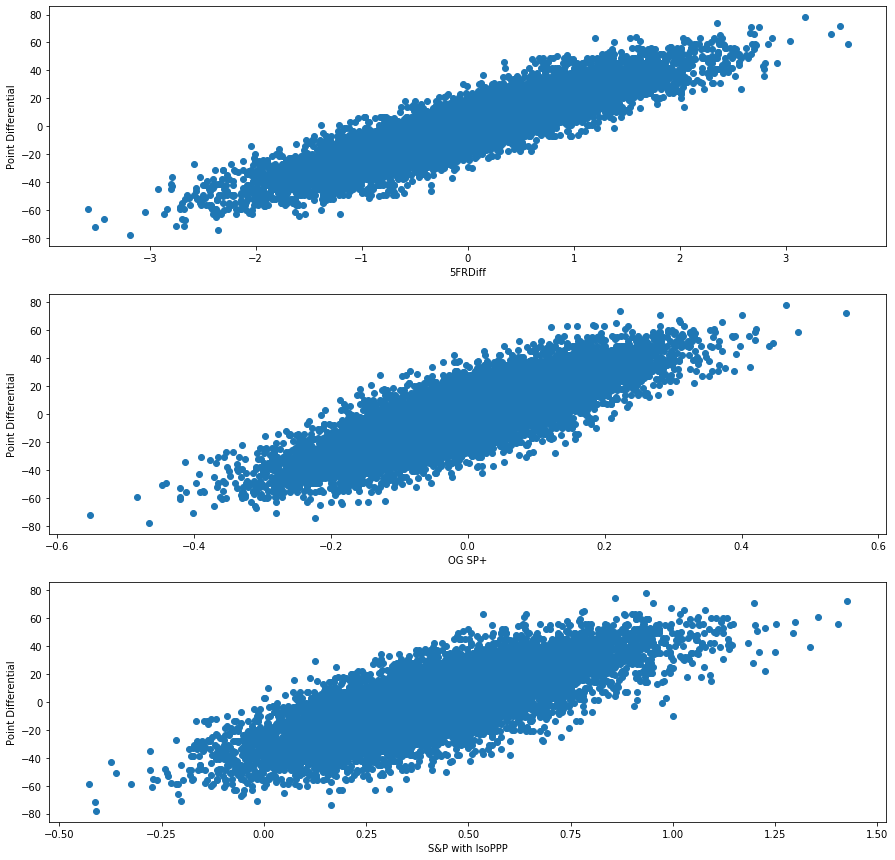

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [15]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912025,0.758809
S&PIsoPPPDiff,0.912025,1.000000,0.815979
PtsDiff,0.758809,0.815979,1.000000


In [16]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.424200,0.848400,0.939239,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.575800,-0.848400,0.939239,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.144444,0.288888,0.319820,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.855556,-0.288888,0.319820,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.756652,-0.486696,0.538808,0.499553


In [17]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [18]:
# outliers

In [19]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.424200,0.848400,0.939239,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.575800,-0.848400,0.939239,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.144444,0.288888,0.319820,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.756652,-0.486696,0.538808,0.499553
1,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0.00,0,-0.087917,6.578618,-0.26167,-0.059391,5.243348,0.486696,0.538808,0.499553


In [20]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [21]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 21.86231x + 0.00015
Mean Pred Score: 0.4410255537377802
Pred Std Dev: 19.701699957924525
Mean Abs Error: 7.452276464794163
Mdn Abs Error: 6.132360496245305
R-squared: 0.8156207114904015



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.771840,0.562696,0.517089,0.801142,0.636602,0.628224,0.982378,0.547666,0.773930,-0.462750,-0.462277,0.717422,0.754403,0.193563,0.555196,0.903154,0.903154,0.903154
OffSRDiff,0.771840,1.000000,0.485553,0.316664,0.713055,0.440665,0.463279,0.769721,0.758602,0.724065,-0.299743,-0.168914,0.645914,0.765740,-0.085630,0.555977,0.837513,0.837513,0.837513
OffERDiff,0.562696,0.485553,1.000000,0.179133,0.505046,0.316872,0.348160,0.556952,0.369572,0.794138,-0.195438,-0.113263,0.753652,0.608339,0.537298,0.194591,0.525446,0.525446,0.525446
FPDiff,0.517089,0.316664,0.179133,1.000000,0.605882,0.162769,0.144319,0.494252,0.083693,0.255526,-0.288544,-0.390805,0.228112,0.234302,-0.004337,0.284392,0.609552,0.609552,0.609552
OppRateDiff,0.801142,0.713055,0.505046,0.605882,1.000000,0.254060,0.243234,0.799690,0.316316,0.672392,-0.316040,-0.311647,0.586521,0.744314,0.089966,0.518288,0.808164,0.808164,0.808164
OppEffDiff,0.636602,0.440665,0.316872,0.162769,0.254060,1.000000,0.767096,0.634228,0.531969,0.463311,-0.316561,-0.353449,0.435321,0.392341,0.152657,0.355509,0.558202,0.558202,0.558202
OppPPDDiff,0.628224,0.463279,0.348160,0.144319,0.243234,0.767096,1.000000,0.635614,0.567899,0.502352,-0.333804,-0.315154,0.480579,0.400284,0.178623,0.387753,0.589685,0.589685,0.589685
PPDDiff,0.982378,0.769721,0.556952,0.494252,0.799690,0.634228,0.635614,1.000000,0.551457,0.766081,-0.451859,-0.452333,0.708216,0.733892,0.184483,0.563207,0.895381,0.895381,0.895381
OppSRDiff,0.547666,0.758602,0.369572,0.083693,0.316316,0.531969,0.567899,0.551457,1.000000,0.559420,-0.257661,-0.115322,0.517049,0.493168,-0.029213,0.396670,0.616471,0.616471,0.616471
YPPDiff,0.773930,0.724065,0.794138,0.255526,0.672392,0.463311,0.502352,0.766081,0.559420,1.000000,-0.335599,-0.198054,0.924068,0.800712,0.499385,0.452242,0.736714,0.736714,0.736714


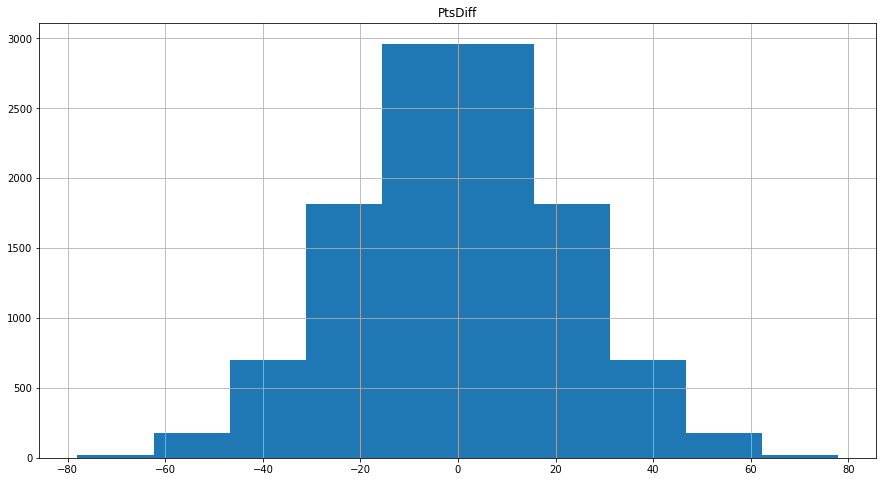

In [22]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

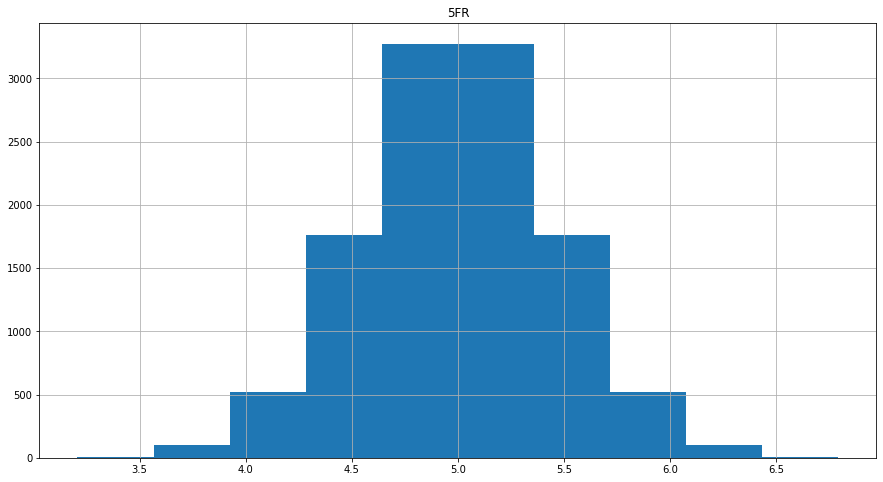

In [23]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

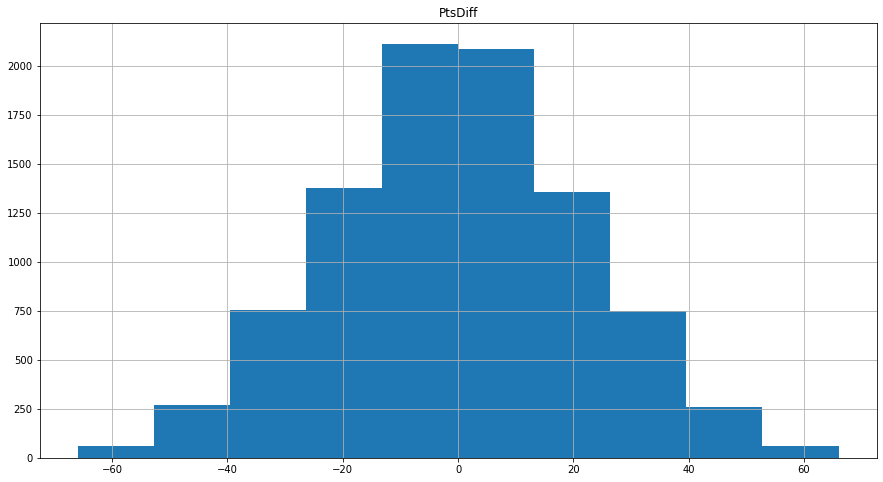

In [24]:
train_data.hist(column='PtsDiff', figsize=(15,8));

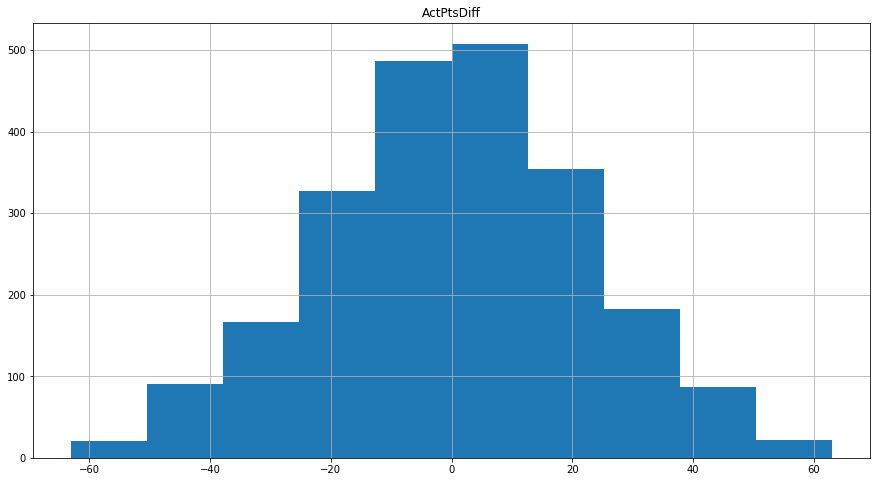

In [25]:
test.hist(column='ActPtsDiff', figsize=(15,8));

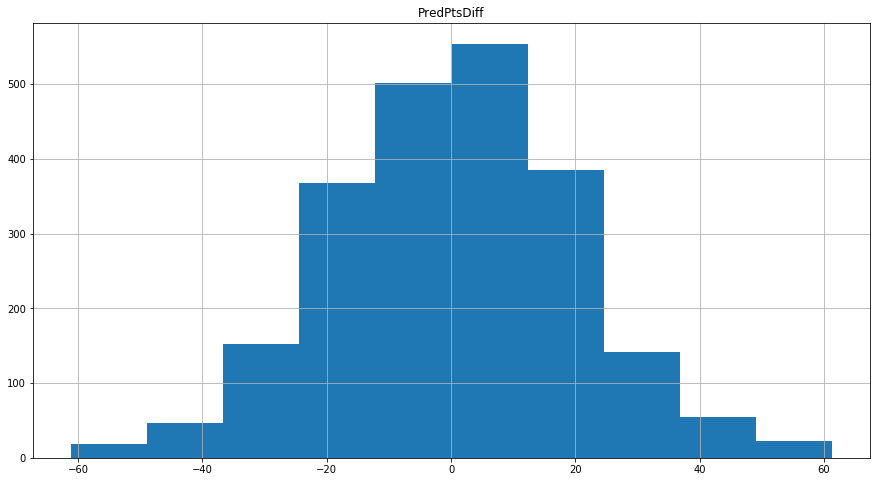

In [26]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [27]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [28]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -5.0 (exact value: -4.63582754090916)
Z score: -0.2576860425998367
Win Prob for Virginia Tech: 39.83%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.106027,0.212053
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.893973,-0.212053


In [29]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -17.0 (exact value: -16.84218030042169)
Z score: -0.8772443947004545
Win Prob for Georgia Tech: 19.02%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.614809,-0.770382
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.385191,0.770382


In [30]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -5.0 (exact value: -5.463517754047306)
Z score: -0.29969714899704014
Win Prob for Georgia Tech: 38.22%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.124956,0.249913
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.875044,-0.249913


In [31]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 5.0 (exact value: 5.301652217101617)
Z score: 0.24671102867997793
Win Prob for Mississippi State: 59.74%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.878752,-0.242495
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.121248,0.242495


In [32]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -7.0 (exact value: -6.587424031796065)
Z score: -0.35674330644279373
Win Prob for Texas A&M: 36.06%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.15066,0.301321
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.84934,-0.301321


In [33]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.930474,13,12.0,1.0
2,Clemson,0.928372,13,12.0,1.0
3,Alabama,0.917449,12,11.0,1.0
4,LSU,0.896189,13,12.0,1.0
5,Wisconsin,0.827936,13,11.0,2.0
6,Oregon,0.816268,13,11.0,2.0
7,Utah,0.804710,13,10.0,3.0
8,Appalachian State,0.795955,13,10.0,3.0
9,Notre Dame,0.795571,12,10.0,2.0
10,Oklahoma,0.782259,13,10.0,3.0


In [34]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.202516,1.797484
21,Clemson,10.475790,2.524210
53,LSU,10.209947,2.790053
2,Alabama,9.298199,2.701801
128,Wisconsin,9.003181,3.996819
115,Utah,8.926874,4.073126
3,Appalachian State,8.799951,4.200049
82,Oregon,8.644104,4.355896
30,Florida Atlantic,8.608051,4.391949
78,Oklahoma,8.546572,4.453428


In [35]:
# Matchup Predictor?
def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    if (~(teams[teams.school == team1].conference.isin(p5).all())):
        team1_avg_ffr *= 0.85 # arbitrary
    if (~(teams[teams.school == team2].conference.isin(p5).all())):
        team2_avg_ffr *= 0.85 # arbitrary
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.03500651111086331, -35.255034851319955]

In [36]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Clemson,Ohio State,2.5,13.325834,0.743442,True,Clemson,Clemson
0,Penn State,Memphis,7.0,10.477027,0.694763,True,Penn State,Penn State
0,Florida,Virginia,14.0,8.115238,0.651554,False,Florida,Virginia
0,LSU,Oklahoma,11.0,8.035944,0.650065,False,LSU,Oklahoma
0,Wisconsin,Oregon,2.5,-4.025135,0.410333,False,Oregon,Oregon
0,Georgia,Baylor,7.5,-5.322909,0.384929,False,Baylor,Baylor


In [37]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 8.0 (exact value: 8.075764033853867)
Z score: 0.38751673695270145
Win Prob for Virginia: 65.08%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.815307,-0.369385
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,5.184693,0.369385


In [38]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.827319633141798)
Z score: 0.5271775583622359
Win Prob for North Carolina: 70.10%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.247622,0.495244
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.752378,-0.495244


In [39]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 12.0 (exact value: 12.330940540043413)
Z score: 0.603496906952093
Win Prob for Pittsburgh: 72.69%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.28201,0.564021
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.71799,-0.564021


In [40]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -7.0 (exact value: -7.063402830861739)
Z score: -0.3809025820424723
Win Prob for Auburn: 35.16%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,5.161546,0.323093
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.838454,-0.323093


In [41]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 27.0 (exact value: 27.384479056521528)
Z score: 1.3675699843325655
Win Prob for Georgia: 91.43%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.626291,1.252582
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.373709,-1.252582


In [42]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 20.0 (exact value: 19.773795191955028)
Z score: 0.981274188496669
Win Prob for Clemson: 83.68%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 2.0 (exact value: 1.704019870206608)
Z score: 0.06410585478238488
Win Prob for Georgia Tech: 52.56%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -16.0 (exact value: -15.704587133609564)
Z score: -0.8195035312601626
Win Prob for The Citadel: 20.62%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 25.0 (exact value: 24.522218739188585)
Z score: 1.2222901189683755
Win Prob for Temple: 88.92%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.827319633141798)
Z score: 0.527177558362

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Georgia Tech,Clemson,-38.0,16.322877
5900,401112441,2019,Georgia Tech,South Florida,4.0,52.555703
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,79.375041
6107,401112469,2019,Georgia Tech,Temple,-22.0,11.079897
6164,401112475,2019,Georgia Tech,North Carolina,-16.0,29.903515
6198,401112480,2019,Georgia Tech,Duke,-18.0,30.648219
6251,401112488,2019,Georgia Tech,Miami,7.0,19.017695
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,27.308909
6418,401112504,2019,Georgia Tech,Virginia,-5.0,23.041161
6475,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.100681


In [43]:
# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)